These first few blocks are just the simulator code, I could have imported them, but this was simpler

In [1]:
#these are the classes used in the simulation
class PhysicalQubit:
#relatively simple, only holds location and if it has undergone an x or z error

    def __init__(self, row, col):
        self.Xvalue = 0
        self.Zvalue = 0
        self.locationRow = row
        self.locationCol = col

    def flip_value(self, gate_type):
        if gate_type == 'x' or gate_type == 'y':
            if self.Xvalue == 1:
                self.Xvalue = 0
            else:
                self.Xvalue = 1

        if gate_type == 'z' or gate_type == 'y':
            if self.Zvalue == 1:
                self.Zvalue = 0
            else:
                self.Zvalue = 1

    def clear(self):
        self.Xvalue = 0
        self.Zvalue = 0

    def return_Xvalue(self):
        return self.Xvalue

    def return_Zvalue(self):
        return self.Zvalue

In [2]:
class AncillaQubit:

    def __init__(self, type, name):
        self.AType = type
        self.qubits = []
        self.on = False
        self.name = name
        self.row = 0
        self.col = 0

    def add_qubit(self, new_qubit):
        self.qubits.append(new_qubit)

    def setLocation(self, row, col):
        self.row = row
        self.col = col

    def connected(self, phys_qubit):
        if phys_qubit in self.qubits:
            return True
        else:
            return False

    #returns the measurement based on the error observed on its physical qubits
    def measure(self):
        total = 0
        if self.AType == "x":
            if len(self.qubits) == 2:
                if self.qubits[0].return_Xvalue() == self.qubits[1].return_Xvalue():
                    total = 1
                else:
                    total = -1
            if len(self.qubits) == 4:
                if (self.qubits[0].return_Xvalue() + self.qubits[1].return_Xvalue() + self.qubits[2].return_Xvalue() + self.qubits[3].return_Xvalue()) % 2 == 0:
                    total = 1
                else:
                    total = -1

        elif self.AType == "z":
            if len(self.qubits) == 2:
                if self.qubits[0].return_Zvalue() == self.qubits[1].return_Zvalue():
                    total += 1
                else:
                    total -= 1
            if len(self.qubits) == 4:
                if (self.qubits[0].return_Zvalue() + self.qubits[1].return_Zvalue() + self.qubits[2].return_Zvalue() + self.qubits[3].return_Zvalue()) % 2 == 0:
                    total = 1
                else:
                    total = -1
        return total

In [3]:
# Inspired by rotated surface code of different depths, as described here:https://arxiv.org/pdf/1811.12456.pdf
import itertools
from random import *
import numpy as np
from collections import defaultdict, Counter


#representation of the rotated surface code for arbitary depth
#contains all the ancilla and physical qubits
#also includes methods to add error on both the physical qubits and the ancilla
class ToricCircuit:

    def __init__(self, depth):
        self.depth = depth
        # initialize qubits to zero
        self.qubits = {}
        self.ancilla = []
        self.ancilla_matrix = [[1]*depth for _ in range(depth+1)]
        self.error_qubits_x = []
        self.error_qubits_z = []
        self.measurement_errs = {}
        for i in range(depth):
            for j in range(depth):
                qubit = PhysicalQubit(i, j)
                self.qubits.update({str(i) + str(j): qubit})
        self.create_ancilla()

    def add_random_error(self, num):
        # random flips with equal probability of x,z,or y on any qubits
        # could possibly flip already corrupted qubits to fix them
        # choose the number of physical qubits to put errors on
        error_types = ['x', 'y', 'z']
        logical_dict = []
        for i in range(num):
            a = randint(0, self.depth-1)
            b = randint(0, self.depth-1)

            type = choice(error_types)
            self.qubits.get(str(a) + str(b)).flip_value(type)
            if type == "x" or type == "y":
                self.error_qubits_x.append(self.qubits.get(str(a) + str(b)))

            if type == "z" or type == "y":
                self.error_qubits_z.append(self.qubits.get(str(a) + str(b)))

    def get_syndrome(self, prob_err):

        return_dict = {}
        for a in self.ancilla:
            return_dict.update({a.name: a.measure()})

        num_errs = 0
        if prob_err > 0:
            for a in return_dict:
                rand = random()
                if rand <= prob_err:
                    num_errs += 1
                    if return_dict[a] == -1:
                        return_dict[a] = 1
                    else:
                        return_dict[a] = -1

        else:
            errs = Counter()
            for x in self.error_qubits_x:
                errs.update({"X" + str(x.locationRow) + str(x.locationCol)})
            for z in self.error_qubits_z:
                errs.update({"Z" + str(z.locationRow) + str(z.locationCol)})

            errors_to_remove = []
            for e in errs: #for decoding, duplicate errors flip back the qubit to its intended state, so remove pairs
                if errs[e] %2 == 0:
                    errors_to_remove.append(e)
            for x in errors_to_remove:
                del errs[x]
            return_dict.update({"Labels": list(errs)})

        return return_dict


    def add_physical_errs(self, err_list):
        for err in err_list:
            if err[0] == 'x':
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('x')
                self.error_qubits_x.append(self.qubits.get(str(err[1]) + str(err[2])))
            elif err[0] == 'z':
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('z')
                self.error_qubits_z.append(self.qubits.get(str(err[1]) + str(err[2])))
            elif err[0] == 'y':
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('x')
                self.error_qubits_x.append(self.qubits.get(str(err[1]) + str(err[2])))
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('z')
                self.error_qubits_z.append(self.qubits.get(str(err[1]) + str(err[2])))
            else:
                print("invalid input in circuit")
        return

    def clear_errors(self):
        for err_x in self.error_qubits_x:
            self.qubits.get(str(err_x.locationRow) + str(err_x.locationCol)).clear()

        for err_z in self.error_qubits_z:
            self.qubits.get(str(err_z.locationRow) + str(err_z.locationCol)).clear()

        self.error_qubits_z.clear()
        self.error_qubits_x.clear()

    def get_physical_errs(self):
        return_dict = {}
        errs = []
        for x in self.error_qubits_x:
            errs.append("X" + str(x.locationRow) + str(x.locationCol))
        for z in self.error_qubits_z:
            errs.append("Z" + str(z.locationRow) + str(z.locationCol))
        return_dict.update({"Labels": errs})

        return return_dict

    def correct_errs(self, err_list):
        err_list = err_list[0]
        for err in err_list:
            if err[0] == 'X':
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('x')
                if self.qubits.get(str(err[1]) + str(err[2])) in self.error_qubits_x:
                    self.error_qubits_x.remove(self.qubits.get(str(err[1]) + str(err[2])))
                    print("Corrected qubit X"+str(err[1]) + str(err[2]))
                else:
                    self.error_qubits_x.append(self.qubits.get(str(err[1]) + str(err[2])))
                    print("Incorrectly flipped qubit X" + str(err[1]) + str(err[2]))
            elif err[0] == 'Z':
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('z')
                if self.qubits.get(str(err[1]) + str(err[2])) in self.error_qubits_z:
                    self.error_qubits_z.remove(self.qubits.get(str(err[1]) + str(err[2])))
                    print("Corrected qubit Z" + str(err[1]) + str(err[2]))
                else:
                    self.error_qubits_z.append(self.qubits.get(str(err[1]) + str(err[2])))
                    print("Incorrectly flipped qubit Z" + str(err[1]) + str(err[2]))
            else:
                return

    def check_max_errs(self, max_errors):
        if len(self.error_qubits_x) + len(self.error_qubits_z) > max_errors:
            return False
        else:
            return True

    def create_ancilla(self):
        # This adds the ancilla with their correct physical qubits attached
        # only for depth of 3,5,7 code described here:https://arxiv.org/pdf/1811.12456.pdf
        count = 0

        for i in range(self.depth - 1):

            if i % 2 == 0:
                #start with z ancilla
                j = 0
                while j < self.depth:
                    if i == 0 and j != (self.depth - 1):
                        #ancilla located about the grid
                        newX = AncillaQubit("x", "X" + str(count))
                        newX.add_qubit(self.qubits.get(str(i) + str(j)))
                        newX.add_qubit(self.qubits.get(str(i) + str(j + 1)))
                        newX.setLocation(i,j)
                        self.ancilla.append(newX)
                        count += 1
                    if j == (self.depth - 1):
                        #at the right most edge ancilla
                        newZ = AncillaQubit("z", "Z" + str(count))
                        newZ.add_qubit(self.qubits.get(str(i) + str(j)))
                        newZ.add_qubit(self.qubits.get(str(i + 1) + str(j)))
                        newZ.setLocation(i+1, j)
                        self.ancilla.append(newZ)
                        count += 1

                    #those two if statements check to see if the code is at the upper boundary and adds the ancilla at the top
                    else:
                        newZ = AncillaQubit("z", "Z" + str(count))
                        newZ.add_qubit(self.qubits.get(str(i) + str(j))) #upper left corner
                        newZ.add_qubit(self.qubits.get(str(i) + str(j+1))) # upper right corner
                        newZ.add_qubit(self.qubits.get(str(i+1) + str(j)))  #lower left corner
                        newZ.add_qubit(self.qubits.get(str(i+1) + str(j + 1)))  #lower right corner
                        newZ.setLocation(i+1, j)
                        count += 1

                        newX = AncillaQubit("x", "X" + str(count))
                        newX.add_qubit(self.qubits.get(str(i) + str(j+1)))
                        newX.add_qubit(self.qubits.get(str(i) + str(j + 2)))
                        newX.add_qubit(self.qubits.get(str(i + 1) + str(j+1)))
                        newX.add_qubit(self.qubits.get(str(i + 1) + str(j + 2)))
                        newX.setLocation(i+1, j+1)
                        count += 1

                        self.ancilla.append(newZ)
                        self.ancilla.append(newX)
                    j = j+2
            else:
                #start witth x ancilla, new row
                j = 0
                while j < self.depth-1:
                    if j == 0:
                        #add z ancilla to the far left
                        newZ = AncillaQubit("z","Z" + str(count))
                        newZ.add_qubit(self.qubits.get(str(i) + str(j)))
                        newZ.add_qubit(self.qubits.get(str(i + 1) + str(j)))
                        newZ.setLocation(i+1, j)
                        self.ancilla.append(newZ)
                        count += 1

                    newX = AncillaQubit("x", "X" + str(count))
                    newX.add_qubit(self.qubits.get(str(i) + str(j)))
                    newX.add_qubit(self.qubits.get(str(i) + str(j + 1)))
                    newX.add_qubit(self.qubits.get(str(i + 1) + str(j)))
                    newX.add_qubit(self.qubits.get(str(i + 1) + str(j + 1)))
                    newX.setLocation(i+1, j+1)
                    self.ancilla.append(newX)
                    count += 1

                    if i == (self.depth - 2) and j < (self.depth - 1):
                        #checks if this is the last row, if it is, then add the ancilla on the bottom
                        newX =AncillaQubit("x", "X" + str(count))
                        newX.add_qubit(self.qubits.get(str(i + 1) + str(j + 1)))
                        newX.add_qubit(self.qubits.get(str(i + 1) + str(j + 2)))
                        newX.setLocation(i+2, j+2)
                        self.ancilla.append(newX)
                        count += 1

                    newZ = AncillaQubit("z", "Z" + str(count))
                    newZ.add_qubit(self.qubits.get(str(i) + str(j + 1)))
                    newZ.add_qubit(self.qubits.get(str(i) + str(j + 2)))
                    newZ.add_qubit(self.qubits.get(str(i + 1) + str(j + 1)))
                    newZ.add_qubit(self.qubits.get(str(i + 1) + str(j + 2)))
                    newZ.setLocation(i+1, j+2)
                    count += 1

                    self.ancilla.append(newZ)
                    j = j + 2
        return

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer
import keras

def create_list_from_string(err_list):
    newstring = err_list.replace("'", "")
    new_err_list = newstring.strip('][').split(', ')
    return set(new_err_list)

In [5]:
#this is the same for all depths so I'm just going to comment this portion
#make circuit for sim
circuit = ToricCircuit(3)
d3_dist = []

#make the multilabel binarizer
mlb = MultiLabelBinarizer()
mlb.fit([['X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20',
 'X21', 'X22','Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 
 'Z20', 'Z21', 'Z22']])

#load NN model
model = keras.models.load_model('model_d3.h5')

#repeat test 1000 times
for i in range (1000):
    count = 0

    while circuit.check_max_errs(3): #while total data qubit errors < depth
        
        circuit.add_random_error(1) #add an error to the circuit
        syn = circuit.get_syndrome(0) #get the syndrome
        del syn['Labels'] #forget about the labels, not needed at this time
        vals = list(syn.values())
        vals = np.array(vals)
        vals = np.expand_dims(vals, axis=0) #these few lines are just to get the data in the right format

        errors = circuit.get_physical_errs() #get the data qubit errors
        errors = errors.get('Labels')
        print(errors)
        multilabelerrs = mlb.transform([errors])

        prediction = model.predict(vals) #use NN model to predict corrections
        prediction[prediction>=.3]=1 #use threshold found in training 
        prediction[prediction<.3]=0
        correction =mlb.inverse_transform(prediction) #Do the inverse transform to get corrections to use in sim
        print(correction)
        circuit.correct_errs(correction) #correct errrors predicted
        count += 1 #increase count of error correction cycles
        
    circuit.clear_errors() #clear errors of 
    d3_dist.append(count) #k
    
print(d3_dist)

OSError: SavedModel file does not exist at: model_d3.h5\{saved_model.pbtxt|saved_model.pb}

In [6]:
circuit = ToricCircuit(5)
d5_dist = []
mlb = MultiLabelBinarizer()
mlb.fit([['', 'X00', 'X01', 'X02', 'X03', 'X04', 'X10', 'X11', 'X12', 'X13', 'X14', 'X20',
 'X21', 'X22', 'X23', 'X24', 'X30', 'X31', 'X32', 'X33', 'X34', 'X40', 'X41', 'X42',
 'X43', 'X44', 'Z00', 'Z01', 'Z02', 'Z03', 'Z04', 'Z10', 'Z11', 'Z12', 'Z13', 'Z14',
 'Z20', 'Z21', 'Z22', 'Z23', 'Z24', 'Z30', 'Z31', 'Z32', 'Z33', 'Z34', 'Z40', 'Z41',
 'Z42', 'Z43', 'Z44']])
model = keras.models.load_model('model_d5.h5')
for i in range(1000):
    count = 0
    while circuit.check_max_errs(5):
        circuit.add_random_error(1)
        syn = circuit.get_syndrome(0)
        del syn['Labels']
        vals = list(syn.values())
        vals = np.array(vals)
        #vals = np.where(vals == -1, 0, vals)
        vals = np.expand_dims(vals, axis=0)

        errors = circuit.get_physical_errs()
        errors = errors.get('Labels')
        print(errors)
        multilabelerrs = mlb.transform([errors])
        #print(multilabelerrs[0])

        prediction = model.predict(vals)
        prediction[prediction>=.5]=1
        prediction[prediction<.5]=0
        correction =mlb.inverse_transform(prediction)
        print(correction)
        circuit.correct_errs(correction)
        count += 1
    circuit.clear_errors()
    d5_dist.append(count)
    
print(d5_dist)

['X44', 'Z44']
[('X43', 'X44', 'Z44')]
Incorrectly flipped qubit X43
Corrected qubit X44
Corrected qubit Z44
['X43', 'Z02']
[('X43',)]
Corrected qubit X43
['X40', 'Z02', 'Z40']
[('X40', 'Z40')]
Corrected qubit X40
Corrected qubit Z40
['Z02', 'Z13']
[('Z24',)]
Incorrectly flipped qubit Z24
['X41', 'Z02', 'Z13', 'Z24', 'Z41']
[('X41', 'Z41')]
Corrected qubit X41
Corrected qubit Z41
['Z02', 'Z13', 'Z24', 'Z24']
[('Z24',)]
Corrected qubit Z24
['Z02', 'Z13', 'Z24', 'Z21']
[('Z21',)]
Corrected qubit Z21
['X13', 'Z02', 'Z13', 'Z24']
[('X13', 'Z24', 'Z34')]
Corrected qubit X13
Corrected qubit Z24
Incorrectly flipped qubit Z34
['X43', 'Z02', 'Z13', 'Z34', 'Z43']
[('X43', 'Z24')]
Corrected qubit X43
Incorrectly flipped qubit Z24
['X44', 'Z02', 'Z13', 'Z34', 'Z43', 'Z24']
[('X43', 'X44')]
Incorrectly flipped qubit X43
Corrected qubit X44
['X22']
[('X22',)]
Corrected qubit X22
['Z42']
[('Z31', 'Z41', 'Z42')]
Incorrectly flipped qubit Z31
Incorrectly flipped qubit Z41
Corrected qubit Z42
['X24', 'Z

[('Z10', 'Z20')]
Corrected qubit Z10
Incorrectly flipped qubit Z20
['X14', 'Z00', 'Z03', 'Z02', 'Z20']
[('X04', 'X14', 'Z10', 'Z20')]
Incorrectly flipped qubit X04
Corrected qubit X14
Incorrectly flipped qubit Z10
Corrected qubit Z20
['X04', 'X44', 'Z00', 'Z03', 'Z02', 'Z10']
[('X44', 'Z20')]
Corrected qubit X44
Incorrectly flipped qubit Z20
['Z01']
[('Z00', 'Z01')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X01', 'Z00', 'Z01']
[('X01', 'Z01')]
Corrected qubit X01
Corrected qubit Z01
['X11', 'Z00', 'Z11']
[('X11', 'Z11', 'Z21')]
Corrected qubit X11
Corrected qubit Z11
Incorrectly flipped qubit Z21
['Z00', 'Z21', 'Z11']
[('Z21',)]
Corrected qubit Z21
['Z00', 'Z11', 'Z41']
[('Z21', 'Z41', 'Z42')]
Incorrectly flipped qubit Z21
Corrected qubit Z41
Incorrectly flipped qubit Z42
['X32', 'Z00', 'Z11', 'Z21', 'Z42']
[('X31', 'X32', 'Z31')]
Incorrectly flipped qubit X31
Corrected qubit X32
Incorrectly flipped qubit Z31
['X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit

[('Z12',)]
Corrected qubit Z12
['X13', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['Z22']
[('Z22',)]
Corrected qubit Z22
['X01', 'Z01']
[('X01', 'Z01')]
Corrected qubit X01
Corrected qubit Z01
['Z12']
[('Z12',)]
Corrected qubit Z12
['X00', 'Z00']
[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['X34']
[('X24', 'X34')]
Incorrectly flipped qubit X24
Corrected qubit X34
['X24', 'X31']
[('X23', 'X24', 'X31')]
Incorrectly flipped qubit X23
Corrected qubit X24
Corrected qubit X31
['X23', 'Z14']
[('X23', 'Z14', 'Z23')]
Corrected qubit X23
Corrected qubit Z14
Incorrectly flipped qubit Z23
['X12', 'Z23', 'Z12']
[('Z12', 'Z22')]
Corrected qubit Z12
Incorrectly flipped qubit Z22
['X12', 'X11', 'Z23', 'Z22', 'Z11']
[('Z13',)]
Incorrectly flipped qubit Z13
['X42', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['Z13']
[('Z13',)]
Corrected qubit Z13
['X31']
[('X31',)]
Corrected qubit X31
['X12', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubi

['X20', 'X10', 'X11', 'Z01', 'Z10']
[('X10', 'X11', 'X20', 'Z10', 'Z20')]
Corrected qubit X10
Corrected qubit X11
Corrected qubit X20
Corrected qubit Z10
Incorrectly flipped qubit Z20
['Z01', 'Z20', 'Z12']
[('Z12', 'Z20')]
Corrected qubit Z12
Corrected qubit Z20
['X23', 'Z01']
[('X23', 'Z01')]
Corrected qubit X23
Corrected qubit Z01
['X22']
[('X22',)]
Corrected qubit X22
['Z21']
[('Z21',)]
Corrected qubit Z21
['Z02']
[('Z02', 'Z03', 'Z12')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z12
['Z03', 'Z12', 'Z21']
[('Z21',)]
Corrected qubit Z21
['X11', 'Z03', 'Z12']
[('X11', 'Z11', 'Z21')]
Corrected qubit X11
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z21
['Z03', 'Z12', 'Z11', 'Z21', 'Z34']
[('Z21', 'Z34')]
Corrected qubit Z21
Corrected qubit Z34
['X41', 'Z03', 'Z12', 'Z11']
[('X41', 'Z41')]
Corrected qubit X41
Incorrectly flipped qubit Z41
['Z03', 'Z12', 'Z11', 'Z41', 'Z03']
[('Z00', 'Z01', 'Z41', 'Z42')]
Incorrectly flipped qubit Z00
Incorrectl

[('X11',)]
Corrected qubit X11
['X24', 'Z42', 'Z41', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X44', 'Z42', 'Z41']
[('X43', 'X44')]
Incorrectly flipped qubit X43
Corrected qubit X44
['X43', 'Z42', 'Z41', 'Z20']
[('X43', 'Z20')]
Corrected qubit X43
Corrected qubit Z20
['X20', 'Z42', 'Z41', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X43', 'Z42', 'Z41']
[('X43',)]
Corrected qubit X43
['Z42', 'Z41', 'Z00']
[('Z00', 'Z01')]
Corrected qubit Z00
Incorrectly flipped qubit Z01
['X42', 'Z42', 'Z41', 'Z01']
[('X42', 'Z01', 'Z42')]
Corrected qubit X42
Corrected qubit Z01
Corrected qubit Z42
['Z41', 'Z10']
[('Z10', 'Z42')]
Corrected qubit Z10
Incorrectly flipped qubit Z42
['X13', 'Z41', 'Z42', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['Z41', 'Z42', 'Z41']
[('Z31', 'Z41', 'Z42')]
Incorrectly flipped qubit Z31
Corrected qubit Z41
Corrected qubit Z42
['X12', 'Z41', 'Z31']
[('X12', 'Z21')]
Corrected qubit X12
Incorrectly flipped qubi

[('X24', 'Z24')]
Incorrectly flipped qubit X24
Corrected qubit Z24
['X24', 'X40']
[('X24', 'X34', 'X40', 'X41')]
Corrected qubit X24
Incorrectly flipped qubit X34
Corrected qubit X40
Incorrectly flipped qubit X41
['X34', 'X41', 'Z11']
[('X11', 'X24', 'X41', 'Z11')]
Incorrectly flipped qubit X11
Incorrectly flipped qubit X24
Corrected qubit X41
Corrected qubit Z11
['X34', 'X11', 'X24', 'X22', 'Z22']
[('X22', 'Z22')]
Corrected qubit X22
Corrected qubit Z22
['X34', 'X11', 'X24', 'X32', 'Z32']
[('X11', 'X32', 'Z32')]
Corrected qubit X11
Corrected qubit X32
Corrected qubit Z32
['X34', 'X24', 'X34', 'Z34']
[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['X24', 'X34', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X34', 'X34', 'Z34']
[('Z34',)]
Corrected qubit Z34
['X34', 'X34', 'X11', 'Z11']
[('X11', 'Z11')]
Corrected qubit X11
Corrected qubit Z11
['X34', 'X34', 'X24']
[('X24', 'X34')]
Corrected qubit X24
Corrected qubit X34
['X34', 'X42', 'Z42']
[('X24', 'X33', 

Corrected qubit X23
Corrected qubit Z23
['X22', 'Z43', 'Z44', 'Z22']
[('X22', 'Z22')]
Corrected qubit X22
Corrected qubit Z22
['X42', 'Z43', 'Z44', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['X21', 'Z43', 'Z44']
[('X21',)]
Corrected qubit X21
['X20', 'Z43', 'Z44']
[('X10', 'X20', 'X21')]
Incorrectly flipped qubit X10
Corrected qubit X20
Incorrectly flipped qubit X21
['X10', 'X21', 'X23', 'Z43', 'Z44', 'Z23']
[('X23', 'X24', 'Z23')]
Corrected qubit X23
Incorrectly flipped qubit X24
Corrected qubit Z23
['X10', 'X21', 'X24', 'X00', 'Z43', 'Z44', 'Z00']
[('X00', 'X23', 'Z00', 'Z10')]
Corrected qubit X00
Incorrectly flipped qubit X23
Corrected qubit Z00
Incorrectly flipped qubit Z10
['Z32']
[('Z32',)]
Corrected qubit Z32
['Z24']
[('X24', 'Z24')]
Incorrectly flipped qubit X24
Corrected qubit Z24
['X24', 'X32', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X24', 'X30']
[('X24', 'X34', 'X40', 'X41')]
Corrected qubit X24
Incorrectly flipped qubit X34
In

[('X22', 'X23', 'X33', 'Z22')]
Incorrectly flipped qubit X22
Corrected qubit X23
Corrected qubit X33
Incorrectly flipped qubit Z22
['X34', 'X22', 'X40', 'Z02', 'Z12', 'Z22']
[('X23', 'X31', 'Z23')]
Incorrectly flipped qubit X23
Incorrectly flipped qubit X31
Incorrectly flipped qubit Z23
['X24']
[('X24', 'X34')]
Corrected qubit X24
Incorrectly flipped qubit X34
['X34', 'X01']
[('X01', 'X24', 'X34')]
Corrected qubit X01
Incorrectly flipped qubit X24
Corrected qubit X34
['X24', 'X10', 'Z10']
[('X10', 'X24', 'X33', 'Z10')]
Corrected qubit X10
Corrected qubit X24
Incorrectly flipped qubit X33
Corrected qubit Z10
['X33', 'X13', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X33', 'Z13']
[('X33', 'X42', 'Z13')]
Corrected qubit X33
Incorrectly flipped qubit X42
Corrected qubit Z13
['X42', 'Z40']
[('X42', 'Z40')]
Corrected qubit X42
Corrected qubit Z40
['X13']
[('X13',)]
Corrected qubit X13
['X12', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['X43']
[('X43

[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X40']
[('X30', 'X40', 'X41')]
Incorrectly flipped qubit X30
Corrected qubit X40
Incorrectly flipped qubit X41
['X30', 'X41', 'X31', 'Z31']
[('X31', 'X41', 'Z31', 'Z41')]
Corrected qubit X31
Corrected qubit X41
Corrected qubit Z31
Incorrectly flipped qubit Z41
['X30', 'Z41', 'Z12']
[('X02', 'Z12')]
Incorrectly flipped qubit X02
Corrected qubit Z12
['X30', 'X02', 'X00', 'Z41', 'Z00']
[('X01', 'X02', 'Z01')]
Incorrectly flipped qubit X01
Corrected qubit X02
Incorrectly flipped qubit Z01
['X41', 'Z41']
[('X41', 'Z41')]
Corrected qubit X41
Corrected qubit Z41
['X20']
[('X10', 'X20', 'X21')]
Incorrectly flipped qubit X10
Corrected qubit X20
Incorrectly flipped qubit X21
['X10', 'X21', 'Z34']
[('X21', 'Z34')]
Corrected qubit X21
Corrected qubit Z34
['X10', 'Z40']
[('X20', 'Z30', 'Z40')]
Incorrectly flipped qubit X20
Incorrectly flipped qubit Z30
Corrected qubit Z40
['X10', 'X20', 'X31', 'Z30', 'Z31']
[('X31', 'X40', 'Z32', 'Z40')]
Cor

[('X21',)]
Corrected qubit X21
['Z31']
[('Z31', 'Z41')]
Corrected qubit Z31
Incorrectly flipped qubit Z41
['Z41', 'Z43']
[('Z41', 'Z42', 'Z44')]
Corrected qubit Z41
Incorrectly flipped qubit Z42
Incorrectly flipped qubit Z44
['Z43', 'Z42', 'Z44', 'Z30']
[('Z30', 'Z31')]
Corrected qubit Z30
Incorrectly flipped qubit Z31
['X00', 'Z43', 'Z42', 'Z44', 'Z31']
[('X00', 'Z00', 'Z30')]
Corrected qubit X00
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z30
['X01', 'Z01']
[('X01', 'Z01')]
Corrected qubit X01
Corrected qubit Z01
['Z21']
[('Z21',)]
Corrected qubit Z21
['X14']
[('X04', 'X13', 'X14')]
Incorrectly flipped qubit X04
Incorrectly flipped qubit X13
Corrected qubit X14
['X04', 'X13', 'Z04']
[('Z04',)]
Corrected qubit Z04
['X04', 'X13', 'X43', 'Z43']
[('X43', 'Z33', 'Z43', 'Z44')]
Corrected qubit X43
Incorrectly flipped qubit Z33
Corrected qubit Z43
Incorrectly flipped qubit Z44
['X04', 'X13', 'X23', 'Z33', 'Z44', 'Z23']
[('X24', 'Z24')]
Incorrectly flipped qubit X24
Incorrectly f

[('X23', 'X34')]
Corrected qubit X23
Incorrectly flipped qubit X34
['X34', 'Z12']
[('X24', 'X34', 'Z12')]
Incorrectly flipped qubit X24
Corrected qubit X34
Corrected qubit Z12
['X24', 'X30']
[('X24', 'X34', 'X40', 'X41')]
Corrected qubit X24
Incorrectly flipped qubit X34
Incorrectly flipped qubit X40
Incorrectly flipped qubit X41
['X30', 'X34', 'X40', 'X41', 'X33']
[('X41', 'X42')]
Corrected qubit X41
Incorrectly flipped qubit X42
['X30', 'X34', 'X40', 'X33', 'X42', 'X31']
[('X41', 'Z41')]
Incorrectly flipped qubit X41
Incorrectly flipped qubit Z41
['X41', 'Z41']
[('X41', 'Z41')]
Corrected qubit X41
Corrected qubit Z41
['X10', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X02']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['X22', 'Z02']
[('X22',)]
Corrected qubit X22
['Z02', 'Z20']
[('Z02', 'Z03', 'Z20')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z20
['X42', 'Z03']
[('X42', 'Z02')]
Corrected qubit X42
Incorrectly flipped

Corrected qubit Z20
['X10', 'X04', 'Z01', 'Z42', 'Z41', 'Z10']
[('X04', 'X10', 'X20', 'Z10', 'Z20')]
Corrected qubit X04
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit Z10
Incorrectly flipped qubit Z20
['X20', 'X43', 'Z01', 'Z42', 'Z41', 'Z20']
[('X10', 'X20', 'Z10', 'Z20')]
Incorrectly flipped qubit X10
Corrected qubit X20
Incorrectly flipped qubit Z10
Corrected qubit Z20
['X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X22']
[('X22',)]
Corrected qubit X22
['Z24']
[('X24', 'Z24')]
Incorrectly flipped qubit X24
Corrected qubit Z24
['X24', 'Z31']
[('X24', 'X34', 'Z20', 'Z31')]
Corrected qubit X24
Incorrectly flipped qubit X34
Incorrectly flipped qubit Z20
Corrected qubit Z31
['X34', 'X31', 'Z20', 'Z31']
[('X24', 'X31', 'X33', 'Z20')]
Incorrectly flipped qubit X24
Corrected qubit X31
Incorrectly flipped qubit X33
Corrected qubit Z20
['X34', 'X24', 'X33', 'X12', 'Z31', 'Z12']
[('X12', 'X22', 'Z22')]
Corrected qubit X12
Incorrectly flipped qubit 

[('Z11', 'Z12', 'Z21', 'Z22')]
Corrected qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['X40']
[('X30', 'X40', 'X41')]
Incorrectly flipped qubit X30
Corrected qubit X40
Incorrectly flipped qubit X41
['X30', 'X41', 'Z01']
[('X41', 'X42')]
Corrected qubit X41
Incorrectly flipped qubit X42
['X30', 'X42', 'X42', 'Z01']
[('Z00', 'Z01')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X30', 'X42', 'X42', 'Z00', 'Z41']
[('Z31', 'Z41')]
Incorrectly flipped qubit Z31
Corrected qubit Z41
['X30', 'X42', 'X42', 'X32', 'Z00', 'Z31']
[('X31', 'X32', 'Z31')]
Incorrectly flipped qubit X31
Corrected qubit X32
Corrected qubit Z31
['X30', 'X42', 'X42', 'X31', 'X43', 'Z00']
[('X21', 'X32')]
Incorrectly flipped qubit X21
Incorrectly flipped qubit X32
['Z41']
[('Z31', 'Z41', 'Z42')]
Incorrectly flipped qubit Z31
Corrected qubit Z41
Incorrectly flipped qubit Z42
['X22', 'Z31', 'Z42', 'Z22']
[('X22', 'Z21', 'Z22')]
Corrected qubit X22
Incorrectly flipp

Corrected qubit X32
['X20', 'X21', 'X04', 'Z34']
[('X22', 'Z34')]
Incorrectly flipped qubit X22
Corrected qubit Z34
['X20', 'X21', 'X04', 'X22', 'Z41']
[('X13', 'Z32')]
Incorrectly flipped qubit X13
Incorrectly flipped qubit Z32
['X30']
[('X30', 'X40', 'X41')]
Corrected qubit X30
Incorrectly flipped qubit X40
Incorrectly flipped qubit X41
['X40', 'X41', 'X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X40', 'X41', 'X44', 'Z44']
[('X43', 'X44', 'Z43', 'Z44')]
Incorrectly flipped qubit X43
Corrected qubit X44
Incorrectly flipped qubit Z43
Corrected qubit Z44
['X40', 'X41', 'X43', 'X44', 'Z43']
[('X42', 'X43', 'Z43')]
Incorrectly flipped qubit X42
Corrected qubit X43
Corrected qubit Z43
['X40', 'X41', 'X44', 'X42', 'X02']
[('X02', 'X43')]
Corrected qubit X02
Incorrectly flipped qubit X43
['X40', 'X41', 'X44', 'X42', 'X43', 'X02', 'Z02']
[('X02', 'Z02')]
Corrected qubit X02
Corrected qubit Z02
['X40', 'X41', 'X44', 'X42', 'X43', 'Z41']
[('Z31', 'Z41', 'Z42')]
Incorr

[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X10', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['Z02']
[('Z02', 'Z03', 'Z12')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z12
['X43', 'Z03', 'Z12', 'Z43']
[('X43', 'X44', 'Z43')]
Corrected qubit X43
Incorrectly flipped qubit X44
Corrected qubit Z43
['X44', 'X01', 'Z03', 'Z12']
[('X01', 'X44')]
Corrected qubit X01
Corrected qubit X44
['Z03', 'Z12', 'Z12']
[('Z02', 'Z03', 'Z12')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Corrected qubit Z12
['X44', 'Z12', 'Z02']
[('X44', 'Z12', 'Z21')]
Corrected qubit X44
Corrected qubit Z12
Incorrectly flipped qubit Z21
['X03', 'Z02', 'Z21', 'Z03']
[('X03', 'Z21')]
Corrected qubit X03
Corrected qubit Z21
['X11', 'Z02', 'Z03']
[('X11',)]
Corrected qubit X11
['Z02', 'Z03', 'Z23']
[('Z23',)]
Corrected qubit Z23
['Z02', 'Z03', 'Z43']
[('Z43', 'Z44')]
Corrected qubit Z43
Incorrectly flipped qubit Z44
['X11', 'Z02', 'Z03', 'Z44']
[('X11',

[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X40', 'X41', 'X42', 'X24']
[('X24', 'X33')]
Corrected qubit X24
Incorrectly flipped qubit X33
['X40', 'X41', 'X42', 'X33', 'X34', 'Z34']
[('Z34',)]
Corrected qubit Z34
['X40', 'X41', 'X42', 'X33', 'X34', 'X34']
[('X24', 'X34')]
Incorrectly flipped qubit X24
Corrected qubit X34
['Z41']
[('Z31', 'Z41', 'Z42')]
Incorrectly flipped qubit Z31
Corrected qubit Z41
Incorrectly flipped qubit Z42
['Z31', 'Z42', 'Z00']
[('Z00', 'Z21')]
Corrected qubit Z00
Incorrectly flipped qubit Z21
['Z31', 'Z42', 'Z21', 'Z43']
[('Z21', 'Z43', 'Z44')]
Corrected qubit Z21
Corrected qubit Z43
Incorrectly flipped qubit Z44
['X41', 'Z31', 'Z42', 'Z44']
[('X41', 'Z44')]
Corrected qubit X41
Corrected qubit Z44
['Z31', 'Z42', 'Z22']
[('Z21', 'Z22')]
Incorrectly flipped qubit Z21
Corrected qubit Z22
['Z31', 'Z42', 'Z21', 'Z22']
[('Z22', 'Z32')]
Corrected qubit Z22
Incorrectly flipped qubit Z32
['X13', 'Z31', 'Z42', 'Z21', 'Z32']
[('X13', 'X22', 'Z22')]
Correcte

[('X21', 'X31', 'Z21')]
Corrected qubit X21
Incorrectly flipped qubit X31
Corrected qubit Z21
['X40', 'X31', 'X00', 'Z42', 'Z31', 'Z31']
[('X00', 'Z00', 'Z31', 'Z41')]
Corrected qubit X00
Incorrectly flipped qubit Z00
Corrected qubit Z31
Incorrectly flipped qubit Z41
['X33']
[('X24', 'X33')]
Incorrectly flipped qubit X24
Corrected qubit X33
['X24', 'X10', 'Z10']
[('X10', 'X24', 'X33', 'Z10')]
Corrected qubit X10
Corrected qubit X24
Incorrectly flipped qubit X33
Corrected qubit Z10
['X33', 'X42']
[('X24', 'X33', 'X41', 'X42')]
Incorrectly flipped qubit X24
Corrected qubit X33
Incorrectly flipped qubit X41
Corrected qubit X42
['X24', 'X41', 'X44']
[('X24', 'X41')]
Corrected qubit X24
Corrected qubit X41
['X44', 'X11']
[('X11', 'X44')]
Corrected qubit X11
Corrected qubit X44
['X44']
[('X43', 'X44')]
Incorrectly flipped qubit X43
Corrected qubit X44
['X43', 'Z13']
[('X42', 'X43', 'Z13', 'Z43')]
Incorrectly flipped qubit X42
Corrected qubit X43
Corrected qubit Z13
Incorrectly flipped qubit 

[('X33', 'Z04', 'Z14')]
Corrected qubit X33
Incorrectly flipped qubit Z04
Corrected qubit Z14
['X24', 'X30', 'Z04', 'Z30']
[('X30', 'Z30')]
Corrected qubit X30
Corrected qubit Z30
['X24', 'Z04', 'Z13']
[('X24', 'Z14')]
Corrected qubit X24
Incorrectly flipped qubit Z14
['Z04', 'Z13', 'Z14', 'Z41']
[('X03', 'Z02', 'Z03', 'Z41', 'Z42')]
Incorrectly flipped qubit X03
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z41
Incorrectly flipped qubit Z42
['X42', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['Z24']
[('X24', 'Z24')]
Incorrectly flipped qubit X24
Corrected qubit Z24
['X24', 'X10', 'Z10']
[('X10', 'X24', 'X33', 'Z10')]
Corrected qubit X10
Corrected qubit X24
Incorrectly flipped qubit X33
Corrected qubit Z10
['X33', 'Z01']
[('X33', 'Z00', 'Z01')]
Corrected qubit X33
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X44', 'Z00', 'Z44']
[('X44', 'Z00', 'Z34', 'Z44')]
Corrected qubit X44
Corrected qubit Z00
Incorrectly flipped qubit Z34
Co

[('X40', 'Z30', 'Z40')]
Corrected qubit X40
Incorrectly flipped qubit Z30
Corrected qubit Z40
['Z44', 'Z30', 'Z02']
[('Z12', 'Z20', 'Z30', 'Z44')]
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z20
Corrected qubit Z30
Corrected qubit Z44
['X12', 'Z02', 'Z12', 'Z20', 'Z12']
[('X12', 'Z12', 'Z20', 'Z44')]
Corrected qubit X12
Corrected qubit Z12
Corrected qubit Z20
Incorrectly flipped qubit Z44
['X23', 'Z02', 'Z12', 'Z44']
[('X23',)]
Corrected qubit X23
['X40', 'Z02', 'Z12', 'Z44', 'Z40']
[('X30', 'Z30', 'Z40')]
Incorrectly flipped qubit X30
Incorrectly flipped qubit Z30
Corrected qubit Z40
['X31']
[('X31',)]
Corrected qubit X31
['Z44']
[('Z43', 'Z44')]
Incorrectly flipped qubit Z43
Corrected qubit Z44
['X02', 'Z43']
[('X02', 'Z44')]
Corrected qubit X02
Incorrectly flipped qubit Z44
['Z43', 'Z44', 'Z30']
[('Z30',)]
Corrected qubit Z30
['X32', 'Z43', 'Z44', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X24', 'Z43', 'Z44', 'Z24']
[('X24', 'Z24')]
Corrected qubit

Corrected qubit X21
Corrected qubit Z21
['X34', 'Z00', 'Z01', 'Z34']
[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['X32', 'Z00', 'Z01']
[('X32',)]
Corrected qubit X32
['X21', 'Z00', 'Z01', 'Z21']
[('X21', 'Z21')]
Corrected qubit X21
Corrected qubit Z21
['X30', 'Z00', 'Z01']
[('X30', 'X40', 'X41')]
Corrected qubit X30
Incorrectly flipped qubit X40
Incorrectly flipped qubit X41
['X40', 'X41', 'Z00', 'Z01', 'Z14']
[('X42', 'Z14')]
Incorrectly flipped qubit X42
Corrected qubit Z14
['X40', 'X41', 'X42', 'X22', 'Z00', 'Z01']
[('X22', 'X32')]
Corrected qubit X22
Incorrectly flipped qubit X32
['X12', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['X32']
[('X32',)]
Corrected qubit X32
['X12']
[('X12',)]
Corrected qubit X12
['Z40']
[('X40', 'Z30', 'Z40')]
Incorrectly flipped qubit X40
Incorrectly flipped qubit Z30
Corrected qubit Z40
['X40', 'Z30', 'Z31']
[('X40', 'X41', 'Z40')]
Corrected qubit X40
Incorrectly flipped qubit X41
Incorrectly flipped qubit Z40
['X41', 

[('X24', 'X34')]
Incorrectly flipped qubit X24
Corrected qubit X34
['X24', 'Z00']
[('X24', 'X34', 'Z00', 'Z01')]
Corrected qubit X24
Incorrectly flipped qubit X34
Corrected qubit Z00
Incorrectly flipped qubit Z01
['X34', 'Z01', 'Z33']
[('X34', 'Z33', 'Z34')]
Corrected qubit X34
Corrected qubit Z33
Incorrectly flipped qubit Z34
['Z01', 'Z34', 'Z23']
[('Z24', 'Z34')]
Incorrectly flipped qubit Z24
Corrected qubit Z34
['X14', 'Z01', 'Z23', 'Z24']
[('Z11', 'Z24', 'Z34')]
Incorrectly flipped qubit Z11
Corrected qubit Z24
Incorrectly flipped qubit Z34
['X14', 'X00', 'Z01', 'Z23', 'Z11', 'Z34', 'Z00']
[('X13', 'Z24', 'Z34')]
Incorrectly flipped qubit X13
Incorrectly flipped qubit Z24
Corrected qubit Z34
['X33', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['Z20']
[('X20', 'Z20')]
Incorrectly flipped qubit X20
Corrected qubit Z20
['X20', 'X00', 'Z00']
[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['X20', 'Z01']
[('X10', 'Z10')]
Incorrectly flipped qubit X10
Incorre

Corrected qubit Z04
Incorrectly flipped qubit Z14
['X02', 'Z14', 'Z02']
[('X02', 'Z02', 'Z14')]
Corrected qubit X02
Corrected qubit Z02
Corrected qubit Z14
['X03', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X20', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['Z41']
[('Z31', 'Z41', 'Z42')]
Incorrectly flipped qubit Z31
Corrected qubit Z41
Incorrectly flipped qubit Z42
['Z31', 'Z42', 'Z42']
[('Z31', 'Z41')]
Corrected qubit Z31
Incorrectly flipped qubit Z41
['X10', 'Z42', 'Z42', 'Z41']
[('X10', 'X20', 'Z41', 'Z42')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit Z41
Corrected qubit Z42
['X20', 'Z42', 'Z13']
[('X10', 'Z13', 'Z42')]
Incorrectly flipped qubit X10
Corrected qubit Z13
Corrected qubit Z42
['X20', 'X10', 'X20', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X10', 'X20', 'X10']
[('X10', 'X20', 'X21')]
Corrected qubit X10
Corrected qubit X20
Incorrectly flipped qubit X21
['X10', 'X21', 'X40', 'Z40']
[(

['X24', 'X04', 'Z04']
[('X04', 'X24', 'Z04', 'Z14')]
Corrected qubit X04
Corrected qubit X24
Corrected qubit Z04
Incorrectly flipped qubit Z14
['X32', 'Z14']
[('X32', 'Z14', 'Z24')]
Corrected qubit X32
Corrected qubit Z14
Incorrectly flipped qubit Z24
['X43', 'Z24']
[('X43', 'Z24')]
Corrected qubit X43
Corrected qubit Z24
['Z00']
[('Z00', 'Z01')]
Corrected qubit Z00
Incorrectly flipped qubit Z01
['X43', 'Z01']
[('X43', 'Z00')]
Corrected qubit X43
Incorrectly flipped qubit Z00
['Z01', 'Z00', 'Z42']
[('Z31', 'Z41', 'Z42')]
Incorrectly flipped qubit Z31
Incorrectly flipped qubit Z41
Corrected qubit Z42
['Z01', 'Z00', 'Z31', 'Z41', 'Z42']
[('Z31', 'Z41')]
Corrected qubit Z31
Corrected qubit Z41
['X13', 'Z01', 'Z00', 'Z42']
[('X13', 'Z32')]
Corrected qubit X13
Incorrectly flipped qubit Z32
['Z01', 'Z00', 'Z42', 'Z32', 'Z23']
[('Z24',)]
Incorrectly flipped qubit Z24
['X34']
[('X24', 'X34')]
Incorrectly flipped qubit X24
Corrected qubit X34
['X24', 'X33', 'Z33']
[('X33', 'Z33')]
Corrected qub

[('Z34',)]
Corrected qubit Z34
['Z02']
[('Z02', 'Z03', 'Z12')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z12
['X24', 'Z03', 'Z12']
[('X24', 'X34', 'Z11', 'Z22')]
Corrected qubit X24
Incorrectly flipped qubit X34
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z22
['X34', 'X14', 'Z03', 'Z12', 'Z11', 'Z22']
[('Z11', 'Z22')]
Corrected qubit Z11
Corrected qubit Z22
['X34', 'X14', 'X04', 'Z03', 'Z12', 'Z04']
[('X24', 'X33', 'Z04', 'Z14', 'Z22')]
Incorrectly flipped qubit X24
Incorrectly flipped qubit X33
Corrected qubit Z04
Incorrectly flipped qubit Z14
Incorrectly flipped qubit Z22
['X44', 'Z44']
[('X43', 'X44', 'Z44')]
Incorrectly flipped qubit X43
Corrected qubit X44
Corrected qubit Z44
['X43', 'Z14']
[('X43', 'Z14')]
Corrected qubit X43
Corrected qubit Z14
['X31', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['X22']
[('X22',)]
Corrected qubit X22
['X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['Z44']
[

[('X42', 'Z02')]
Corrected qubit X42
Incorrectly flipped qubit Z02
['X21', 'Z21']
[('X21', 'Z21')]
Corrected qubit X21
Corrected qubit Z21
['X41']
[('X41', 'Z41')]
Corrected qubit X41
Incorrectly flipped qubit Z41
['X02', 'Z41']
[('X02', 'Z41')]
Corrected qubit X02
Corrected qubit Z41
['Z10']
[('X10', 'Z10')]
Incorrectly flipped qubit X10
Corrected qubit Z10
['X10', 'Z40']
[('X20', 'Z30', 'Z40')]
Incorrectly flipped qubit X20
Incorrectly flipped qubit Z30
Corrected qubit Z40
['X10', 'X20', 'X31', 'Z30', 'Z31']
[('X31', 'X40', 'Z32', 'Z40')]
Corrected qubit X31
Incorrectly flipped qubit X40
Incorrectly flipped qubit Z32
Incorrectly flipped qubit Z40
['Z20']
[('X20', 'Z20')]
Incorrectly flipped qubit X20
Corrected qubit Z20
['X20', 'Z44']
[('X10', 'X20', 'Z43', 'Z44')]
Incorrectly flipped qubit X10
Corrected qubit X20
Incorrectly flipped qubit Z43
Corrected qubit Z44
['X10', 'Z43', 'Z21']
[('Z21',)]
Corrected qubit Z21
['X10', 'Z43', 'Z01']
[('X10', 'X11', 'Z10', 'Z43')]
Corrected qubit 

Incorrectly flipped qubit X20
Corrected qubit Z02
['X20', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X44']
[('X43', 'X44')]
Incorrectly flipped qubit X43
Corrected qubit X44
['X43', 'Z31']
[('X43', 'Z31')]
Corrected qubit X43
Corrected qubit Z31
['X43']
[('X43',)]
Corrected qubit X43
['X23', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X03', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X03']
[('X03',)]
Corrected qubit X03
['X13']
[('X13',)]
Corrected qubit X13
['X23']
[('X23', 'X34')]
Corrected qubit X23
Incorrectly flipped qubit X34
['X34', 'X20', 'Z20']
[('X20', 'X24', 'X33', 'Z20')]
Corrected qubit X20
Incorrectly flipped qubit X24
Incorrectly flipped qubit X33
Corrected qubit Z20
['X34', 'X24', 'X33', 'X10', 'Z10']
[('X10', 'X33', 'Z10')]
Corrected qubit X10
Corrected qubit X33
Corrected qubit Z10
['X34', 'X24', 'Z03']
[('Z02', 'Z03', 'Z12')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit 

[('Z02', 'Z03', 'Z12')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z12
['X13']
[('X13',)]
Corrected qubit X13
['X02', 'Z02']
[('X02', 'Z02')]
Corrected qubit X02
Corrected qubit Z02
['Z32']
[('Z32',)]
Corrected qubit Z32
['Z01']
[('Z00', 'Z01')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
['Z00', 'Z43']
[('Z00', 'Z01', 'Z10', 'Z43', 'Z44')]
Corrected qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z10
Corrected qubit Z43
Incorrectly flipped qubit Z44
['Z01', 'Z10', 'Z44', 'Z32']
[('Z20', 'Z32', 'Z33')]
Incorrectly flipped qubit Z20
Corrected qubit Z32
Incorrectly flipped qubit Z33
['X30', 'Z01', 'Z10', 'Z44', 'Z20', 'Z33', 'Z30']
[('X40', 'Z40')]
Incorrectly flipped qubit X40
Incorrectly flipped qubit Z40
['Z11']
[('Z11',)]
Corrected qubit Z11
['X20']
[('X10', 'X20', 'X21')]
Incorrectly flipped qubit X10
Corrected qubit X20
Incorrectly flipped qubit X21
['X10', 'X21', 'Z33']
[('X22', 'Z22', 'Z33')]
Incorrectly flipped qubit X22
I

[('X24', 'X33', 'Z20')]
Corrected qubit X24
Corrected qubit X33
Corrected qubit Z20
['X34', 'X44']
[('X24', 'X34', 'X43', 'X44')]
Incorrectly flipped qubit X24
Corrected qubit X34
Incorrectly flipped qubit X43
Corrected qubit X44
['X24', 'X43', 'X34', 'Z34']
[('X43', 'Z34', 'Z43')]
Corrected qubit X43
Corrected qubit Z34
Incorrectly flipped qubit Z43
['X24', 'X34', 'X10', 'Z43']
[('X10', 'X20', 'Z43', 'Z44')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit Z43
Incorrectly flipped qubit Z44
['X24', 'X34', 'X20', 'X42', 'Z44']
[('X10', 'X42')]
Incorrectly flipped qubit X10
Corrected qubit X42
['X24', 'X34', 'X20', 'X10', 'X14', 'Z44']
[('X13', 'Z43', 'Z44')]
Incorrectly flipped qubit X13
Incorrectly flipped qubit Z43
Corrected qubit Z44
['X34', 'Z34']
[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['X30', 'Z30']
[('X30', 'Z30')]
Corrected qubit X30
Corrected qubit Z30
['X32']
[('X32',)]
Corrected qubit X32
['Z41']
[('Z31', 'Z41', 'Z42')]
Incorrectly flipped qu

[('X00', 'X20')]
Corrected qubit X00
Incorrectly flipped qubit X20
['X34', 'X24', 'X10', 'X20', 'X20']
[('X10', 'X20', 'X21')]
Corrected qubit X10
Corrected qubit X20
Incorrectly flipped qubit X21
['X34', 'X24', 'X20', 'X21', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X34', 'X20', 'X21', 'X01', 'Z01']
[('X01', 'Z01')]
Corrected qubit X01
Corrected qubit Z01
['X34', 'X20', 'X21', 'X41']
[('X23', 'X24', 'X41')]
Incorrectly flipped qubit X23
Incorrectly flipped qubit X24
Corrected qubit X41
['X34', 'X20', 'X21', 'X23', 'X24', 'X42', 'Z42']
[('X22', 'X23', 'X42', 'Z42')]
Incorrectly flipped qubit X22
Corrected qubit X23
Corrected qubit X42
Corrected qubit Z42
['X34', 'X20', 'X21', 'X24', 'X22', 'X23', 'Z23']
[('X23', 'X24', 'Z23')]
Corrected qubit X23
Corrected qubit X24
Corrected qubit Z23
['X34', 'X20', 'X21', 'X22', 'X10']
[('X10', 'X23')]
Corrected qubit X10
Incorrectly flipped qubit X23
['X34', 'X20', 'X21', 'X22', 'X23', 'Z01']
[('Z00', 'Z01')]
Incorrectly flip

[('X24', 'X31', 'Z31')]
Incorrectly flipped qubit X24
Corrected qubit X31
Corrected qubit Z31
['X34', 'X24', 'X04']
[('X04', 'X13', 'X14')]
Corrected qubit X04
Incorrectly flipped qubit X13
Incorrectly flipped qubit X14
['X34', 'X24', 'X13', 'X14', 'X01']
[('X01', 'X12', 'Z01')]
Corrected qubit X01
Incorrectly flipped qubit X12
Incorrectly flipped qubit Z01
['X40']
[('X30', 'X40', 'X41')]
Incorrectly flipped qubit X30
Corrected qubit X40
Incorrectly flipped qubit X41
['X30', 'X41', 'X01']
[('X01', 'X41')]
Corrected qubit X01
Corrected qubit X41
['X30', 'Z30']
[('X30', 'Z30')]
Corrected qubit X30
Corrected qubit Z30
['Z33']
[('Z33',)]
Corrected qubit Z33
['Z24']
[('X24', 'Z24')]
Incorrectly flipped qubit X24
Corrected qubit Z24
['X24', 'X11', 'Z11']
[('X11', 'X24', 'Z11')]
Corrected qubit X11
Corrected qubit X24
Corrected qubit Z11
['X34', 'Z34']
[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['X23', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X14']
[('X0

['X32', 'Z41', 'Z42', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X11', 'Z41', 'Z42']
[('X11',)]
Corrected qubit X11
['Z41', 'Z42', 'Z32']
[('Z32',)]
Corrected qubit Z32
['X34', 'Z41', 'Z42']
[('X24', 'X34')]
Incorrectly flipped qubit X24
Corrected qubit X34
['X24', 'X22', 'Z41', 'Z42']
[('X22', 'X23', 'X24')]
Corrected qubit X22
Incorrectly flipped qubit X23
Corrected qubit X24
['X23', 'Z41', 'Z42', 'Z00']
[('X23', 'Z01')]
Corrected qubit X23
Incorrectly flipped qubit Z01
['X14', 'Z41', 'Z42', 'Z00', 'Z01', 'Z14']
[('X14', 'Z14')]
Corrected qubit X14
Corrected qubit Z14
['X24', 'Z41', 'Z42', 'Z00', 'Z01']
[('X24', 'X34')]
Corrected qubit X24
Incorrectly flipped qubit X34
['X34', 'X14', 'Z41', 'Z42', 'Z00', 'Z01', 'Z14']
[('X14', 'X24', 'Z14')]
Corrected qubit X14
Incorrectly flipped qubit X24
Corrected qubit Z14
['X14']
[('X04', 'X13', 'X14')]
Incorrectly flipped qubit X04
Incorrectly flipped qubit X13
Corrected qubit X14
['X04', 'X13', 'X34']
[('X23', 'X34')]
In

[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X34', 'Z43', 'Z44', 'Z41', 'Z34']
[('X34', 'Z34', 'Z42')]
Corrected qubit X34
Corrected qubit Z34
Incorrectly flipped qubit Z42
['Z43', 'Z44', 'Z41', 'Z42', 'Z33']
[('Z33',)]
Corrected qubit Z33
['Z43', 'Z44', 'Z41', 'Z42', 'Z31']
[('Z31', 'Z41')]
Corrected qubit Z31
Corrected qubit Z41
['X24', 'Z43', 'Z44', 'Z42', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['Z43', 'Z44', 'Z42', 'Z30']
[('Z30', 'Z31')]
Corrected qubit Z30
Incorrectly flipped qubit Z31
['X00', 'Z43', 'Z44', 'Z42', 'Z31']
[('X00', 'Z00', 'Z30')]
Corrected qubit X00
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z30
['X31']
[('X31',)]
Corrected qubit X31
['X21']
[('X21',)]
Corrected qubit X21
['Z33']
[('Z33',)]
Corrected qubit Z33
['Z01']
[('Z00', 'Z01')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
['Z00', 'Z04']
[('Z04',)]
Corrected qubit Z04
['X23', 'Z00', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X33',

Corrected qubit X22
Incorrectly flipped qubit X32
Corrected qubit X43
['X32', 'Z04']
[('X32', 'Z04')]
Corrected qubit X32
Corrected qubit Z04
['Z22']
[('Z22',)]
Corrected qubit Z22
['X43', 'Z43']
[('X43', 'Z43')]
Corrected qubit X43
Corrected qubit Z43
['X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['Z04']
[('Z04',)]
Corrected qubit Z04
['X14']
[('X04', 'X13', 'X14')]
Incorrectly flipped qubit X04
Incorrectly flipped qubit X13
Corrected qubit X14
['X04', 'X13', 'X24']
[('X23', 'X34')]
Incorrectly flipped qubit X23
Incorrectly flipped qubit X34
['X04', 'X13', 'X24', 'X23', 'X34', 'X00']
[('X00', 'X24')]
Corrected qubit X00
Corrected qubit X24
['X04', 'X13', 'X23', 'X34', 'X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X04', 'X13', 'X23', 'X34', 'X40']
[('X30', 'X40', 'X41')]
Incorrectly flipped qubit X30
Corrected qubit X40
Incorrectly flipped qubit X41
['X03']
[('X03',)]
Corrected qubit X03
['X40', 'Z40']
[('X40', 'Z40')]
Corrected qubi

[('X01', 'X41')]
Corrected qubit X01
Corrected qubit X41
['X40', 'Z00']
[('Z00', 'Z01')]
Corrected qubit Z00
Incorrectly flipped qubit Z01
['X40', 'X20', 'Z01', 'Z20']
[('X10', 'X20', 'Z20')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit Z20
['X40', 'X10', 'Z01', 'Z31']
[('X31', 'Z31')]
Incorrectly flipped qubit X31
Corrected qubit Z31
['X40', 'X10', 'X31', 'Z01', 'Z40']
[('X21',)]
Incorrectly flipped qubit X21
['Z44']
[('Z43', 'Z44')]
Incorrectly flipped qubit Z43
Corrected qubit Z44
['X00', 'Z43', 'Z00']
[('X00', 'X01', 'Z00')]
Corrected qubit X00
Incorrectly flipped qubit X01
Corrected qubit Z00
['X01', 'X34', 'Z43']
[('X01', 'X34')]
Corrected qubit X01
Corrected qubit X34
['Z43', 'Z40']
[('Z40', 'Z43')]
Corrected qubit Z40
Corrected qubit Z43
['X12']
[('X12',)]
Corrected qubit X12
['X11']
[('X11',)]
Corrected qubit X11
['Z30']
[('Z30',)]
Corrected qubit Z30
['X33', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['X24']
[('X24', 'X34')]
Corrected

[('X41',)]
Corrected qubit X41
['X42', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['Z33']
[('Z33',)]
Corrected qubit Z33
['X43', 'Z43']
[('X43', 'Z43')]
Corrected qubit X43
Corrected qubit Z43
['X23']
[('X23', 'X34')]
Corrected qubit X23
Incorrectly flipped qubit X34
['X34', 'X00', 'Z00']
[('X00', 'X24', 'Z00', 'Z10')]
Corrected qubit X00
Incorrectly flipped qubit X24
Corrected qubit Z00
Incorrectly flipped qubit Z10
['X34', 'X24', 'X04', 'Z10']
[('Z10',)]
Corrected qubit Z10
['X34', 'X24', 'X04', 'Z13']
[('X13', 'Z13')]
Incorrectly flipped qubit X13
Corrected qubit Z13
['X34', 'X24', 'X04', 'X13', 'X03', 'Z03']
[('X03', 'X13', 'Z03')]
Corrected qubit X03
Corrected qubit X13
Corrected qubit Z03
['X34', 'X24', 'X04', 'X40']
[('X14', 'X30')]
Incorrectly flipped qubit X14
Incorrectly flipped qubit X30
['X03']
[('X03',)]
Corrected qubit X03
['X03']
[('X03',)]
Corrected qubit X03
['Z32']
[('Z32',)]
Corrected qubit Z32
['Z10']
[('X10', 'Z10')]
Incorrectly flipped qubit X

[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['X12', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['X21']
[('X21',)]
Corrected qubit X21
['X30']
[('X30', 'X40', 'X41')]
Corrected qubit X30
Incorrectly flipped qubit X40
Incorrectly flipped qubit X41
['X40', 'X41', 'X32']
[('X32', 'X42')]
Corrected qubit X32
Incorrectly flipped qubit X42
['X40', 'X41', 'X42', 'Z44']
[('X43', 'Z33', 'Z43')]
Incorrectly flipped qubit X43
Incorrectly flipped qubit Z33
Incorrectly flipped qubit Z43
['X03', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['Z44']
[('Z43', 'Z44')]
Incorrectly flipped qubit Z43
Corrected qubit Z44
['X20', 'Z43', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X34', 'Z43', 'Z34']
[('X24', 'X34', 'Z24', 'Z34')]
Incorrectly flipped qubit X24
Corrected qubit X34
Incorrectly flipped qubit Z24
Corrected qubit Z34
['X24', 'X44', 'Z43', 'Z24']
[('X24', 'Z24', 'Z34')]
Corrected qubit X24
Corrected qubit Z24
Incorrectly flip

[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X21', 'Z31', 'Z42']
[('X21', 'Z21')]
Corrected qubit X21
Incorrectly flipped qubit Z21
['Z31', 'Z42', 'Z21', 'Z12']
[('Z02', 'Z03', 'Z12')]
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z12
['X24', 'Z31', 'Z42', 'Z21', 'Z02', 'Z03']
[('X24', 'X34', 'Z11', 'Z22')]
Corrected qubit X24
Incorrectly flipped qubit X34
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z22
['X10', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['Z01']
[('Z00', 'Z01')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X13', 'Z00']
[('X13',)]
Corrected qubit X13
['X43', 'Z00']
[('X43', 'Z00')]
Corrected qubit X43
Corrected qubit Z00
['Z24']
[('X24', 'Z24')]
Incorrectly flipped qubit X24
Corrected qubit Z24
['X24', 'X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X24', 'X40']
[('X24', 'X34', 'X40', 'X41')]
Corrected qubit X24
Incorrectly flipped qubit X34
Corrected qubit X40
In

[('X30', 'X40', 'X41')]
Incorrectly flipped qubit X30
Corrected qubit X40
Incorrectly flipped qubit X41
['X30', 'X41', 'X34', 'Z03', 'Z03', 'Z34']
[('X24', 'X34', 'Z34')]
Incorrectly flipped qubit X24
Corrected qubit X34
Corrected qubit Z34
['X30', 'X41', 'X24', 'Z03', 'Z03', 'Z11']
[('X11', 'X24', 'Z11')]
Incorrectly flipped qubit X11
Corrected qubit X24
Corrected qubit Z11
['X30', 'X41', 'X11', 'Z03', 'Z03', 'Z22']
[('X11', 'Z11')]
Corrected qubit X11
Incorrectly flipped qubit Z11
['Z41']
[('Z31', 'Z41', 'Z42')]
Incorrectly flipped qubit Z31
Corrected qubit Z41
Incorrectly flipped qubit Z42
['X43', 'Z31', 'Z42']
[('X43', 'Z43')]
Corrected qubit X43
Incorrectly flipped qubit Z43
['X13', 'Z31', 'Z42', 'Z43', 'Z13']
[('X13', 'Z13', 'Z44')]
Corrected qubit X13
Corrected qubit Z13
Incorrectly flipped qubit Z44
['X10', 'Z31', 'Z42', 'Z43', 'Z44', 'Z10']
[('X10', 'X20', 'Z10', 'Z20')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit Z10
Incorrectly flipped qubit Z20
['X42',

[('X22', 'Z22', 'Z33')]
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z22
Corrected qubit Z33
['X10', 'X21', 'X22', 'Z22', 'Z44']
[('X22', 'Z22', 'Z33')]
Corrected qubit X22
Corrected qubit Z22
Incorrectly flipped qubit Z33
['X10', 'X21', 'X10', 'Z44', 'Z33']
[('X21',)]
Corrected qubit X21
['X10', 'X10', 'X34', 'Z44', 'Z33', 'Z34']
[('X34', 'Z33', 'Z34')]
Corrected qubit X34
Corrected qubit Z33
Corrected qubit Z34
['X10', 'X10', 'Z44', 'Z21']
[('Z21', 'Z44')]
Corrected qubit Z21
Corrected qubit Z44
['X10', 'X10', 'Z33']
[('Z33',)]
Corrected qubit Z33
['X10', 'X10', 'Z24']
[('X24', 'Z24')]
Incorrectly flipped qubit X24
Corrected qubit Z24
['X10', 'X10', 'X24', 'X31', 'Z31']
[('X24', 'X31', 'Z31')]
Corrected qubit X24
Corrected qubit X31
Corrected qubit Z31
['X10', 'X10', 'Z32']
[('Z32',)]
Corrected qubit Z32
['X10', 'X10', 'Z33']
[('Z33',)]
Corrected qubit Z33
['X10', 'X10', 'X01', 'Z01']
[('X01', 'Z01')]
Corrected qubit X01
Corrected qubit Z01
['X10', 'X10', 'X12', 'Z12']
[('

[('X24', 'X34')]
Incorrectly flipped qubit X24
Corrected qubit X34
['X13', 'X23', 'X34', 'X24', 'X13']
[('X23', 'X34')]
Corrected qubit X23
Corrected qubit X34
['X13', 'X24', 'X13', 'X24']
[()]
['X13', 'X24', 'X13', 'X24', 'X13', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X24', 'X13', 'X24', 'X13', 'X32']
[('X32',)]
Corrected qubit X32
['X24', 'X13', 'X24', 'X13', 'Z41']
[('Z31', 'Z41', 'Z42')]
Incorrectly flipped qubit Z31
Corrected qubit Z41
Incorrectly flipped qubit Z42
['X44']
[('X43', 'X44')]
Incorrectly flipped qubit X43
Corrected qubit X44
['X43', 'Z10']
[('X43', 'Z10')]
Corrected qubit X43
Corrected qubit Z10
['Z40']
[('X40', 'Z30', 'Z40')]
Incorrectly flipped qubit X40
Incorrectly flipped qubit Z30
Corrected qubit Z40
['X40', 'X42', 'Z30', 'Z42']
[('X41', 'Z30')]
Incorrectly flipped qubit X41
Corrected qubit Z30
['X40', 'X42', 'X41', 'Z42', 'Z40']
[('X42', 'Z04', 'Z40', 'Z42')]
Corrected qubit X42
Incorrectly flipped qubit Z04
Corrected qubit Z40
Correct

Incorrectly flipped qubit Z00
Corrected qubit Z01
['X03', 'Z00']
[('X03', 'Z10')]
Corrected qubit X03
Incorrectly flipped qubit Z10
['X40', 'Z00', 'Z10']
[('Z20',)]
Incorrectly flipped qubit Z20
['X40', 'Z00', 'Z10', 'Z20', 'Z41']
[('X31', 'Z31')]
Incorrectly flipped qubit X31
Incorrectly flipped qubit Z31
['X32']
[('X32',)]
Corrected qubit X32
['X24']
[('X24', 'X34')]
Corrected qubit X24
Incorrectly flipped qubit X34
['X34', 'X30']
[('X24', 'X34', 'X40', 'X41')]
Incorrectly flipped qubit X24
Corrected qubit X34
Incorrectly flipped qubit X40
Incorrectly flipped qubit X41
['X30', 'X24', 'X40', 'X41', 'X24']
[('X41', 'Z41')]
Corrected qubit X41
Incorrectly flipped qubit Z41
['X30', 'X24', 'X40', 'X24', 'X04', 'Z41']
[('Z31', 'Z42')]
Incorrectly flipped qubit Z31
Incorrectly flipped qubit Z42
['Z11']
[('Z11',)]
Corrected qubit Z11
['Z40']
[('X40', 'Z30', 'Z40')]
Incorrectly flipped qubit X40
Incorrectly flipped qubit Z30
Corrected qubit Z40
['X40', 'X30', 'Z30']
[('Z30',)]
Corrected qubit

['Z20']
[('X20', 'Z20')]
Incorrectly flipped qubit X20
Corrected qubit Z20
['X20', 'X20', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X20', 'X34', 'Z34']
[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['X20', 'X04']
[('X04', 'X10', 'X14', 'X20', 'X21')]
Corrected qubit X04
Incorrectly flipped qubit X10
Incorrectly flipped qubit X14
Corrected qubit X20
Incorrectly flipped qubit X21
['X10', 'X14', 'X21', 'X10']
[('X14', 'X21')]
Corrected qubit X14
Corrected qubit X21
['X10', 'X10', 'X30', 'Z30']
[('X30', 'Z30')]
Corrected qubit X30
Corrected qubit Z30
['X10', 'X10', 'X32', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X10', 'X10', 'X13', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X10', 'X10', 'X22']
[('X22',)]
Corrected qubit X22
['X10', 'X10', 'Z43']
[('Z43', 'Z44')]
Corrected qubit Z43
Incorrectly flipped qubit Z44
['X10', 'X10', 'X11', 'Z44', 'Z11']
[('X11', 'Z11')]
Corrected qubit X11
Corrected qubit Z11
['X10

[('X43',)]
Incorrectly flipped qubit X43
['X20', 'X21', 'X32', 'X43', 'X11', 'Z02']
[('X02', 'X44')]
Incorrectly flipped qubit X02
Incorrectly flipped qubit X44
['Z30']
[('Z30',)]
Corrected qubit Z30
['X04', 'Z04']
[('X04', 'Z04', 'Z14')]
Corrected qubit X04
Corrected qubit Z04
Incorrectly flipped qubit Z14
['Z14', 'Z40']
[('Z04', 'Z14', 'Z40')]
Incorrectly flipped qubit Z04
Corrected qubit Z14
Corrected qubit Z40
['X11', 'Z04', 'Z11']
[('X11', 'Z11')]
Corrected qubit X11
Corrected qubit Z11
['X03', 'Z04', 'Z03']
[('X03', 'Z04')]
Corrected qubit X03
Corrected qubit Z04
['X31', 'Z03']
[('X31',)]
Corrected qubit X31
['X12', 'Z03', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['X34', 'Z03']
[('X24', 'X33', 'X34', 'Z03', 'Z13')]
Incorrectly flipped qubit X24
Incorrectly flipped qubit X33
Corrected qubit X34
Corrected qubit Z03
Incorrectly flipped qubit Z13
['X24', 'X33', 'X43', 'Z13']
[('X43', 'X44', 'Z13')]
Corrected qubit X43
Incorrectly flipped qubit X44
Corrected qub

Corrected qubit Z11
['Z21']
[('Z21',)]
Corrected qubit Z21
['X31']
[('X31',)]
Corrected qubit X31
['X41', 'Z41']
[('X41', 'Z41')]
Corrected qubit X41
Corrected qubit Z41
['X31']
[('X31',)]
Corrected qubit X31
['Z14']
[('Z14', 'Z24')]
Corrected qubit Z14
Incorrectly flipped qubit Z24
['X11', 'Z24']
[('X11', 'Z24')]
Corrected qubit X11
Corrected qubit Z24
['X00']
[('X00', 'Z00')]
Corrected qubit X00
Incorrectly flipped qubit Z00
['X31', 'Z00']
[('X31',)]
Corrected qubit X31
['Z00', 'Z42']
[('Z00', 'Z01', 'Z41', 'Z42')]
Corrected qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z41
Corrected qubit Z42
['X40', 'Z01', 'Z41', 'Z40']
[('X41', 'Z41')]
Incorrectly flipped qubit X41
Corrected qubit Z41
['X40', 'X41', 'X12', 'Z01', 'Z40', 'Z12']
[('Z12',)]
Corrected qubit Z12
['X40', 'X41', 'X12', 'X41', 'Z01', 'Z40']
[('X01', 'Z01', 'Z40')]
Incorrectly flipped qubit X01
Corrected qubit Z01
Corrected qubit Z40
['X40', 'X41', 'X12', 'X41', 'X01', 'Z44']
[('X01', 'X23')]
Corrected 

[('X13', 'X22', 'Z22')]
Corrected qubit X13
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z22
['X33']
[('X24', 'X33')]
Incorrectly flipped qubit X24
Corrected qubit X33
['X24', 'X44', 'Z44']
[('X34', 'X43', 'X44', 'Z44')]
Incorrectly flipped qubit X34
Incorrectly flipped qubit X43
Corrected qubit X44
Corrected qubit Z44
['X24', 'X34', 'X43', 'X21']
[('X21', 'X32', 'X43')]
Corrected qubit X21
Incorrectly flipped qubit X32
Corrected qubit X43
['X24', 'X34', 'X32', 'Z33']
[('X32', 'X33', 'Z32', 'Z33')]
Corrected qubit X32
Incorrectly flipped qubit X33
Incorrectly flipped qubit Z32
Corrected qubit Z33
['X24', 'X34', 'X33', 'X02', 'Z32', 'Z02']
[('X02', 'X33', 'X42')]
Corrected qubit X02
Corrected qubit X33
Incorrectly flipped qubit X42
['X24', 'X34', 'X42', 'X23', 'Z32', 'Z02']
[('X23', 'X33', 'X42', 'Z42')]
Corrected qubit X23
Incorrectly flipped qubit X33
Corrected qubit X42
Incorrectly flipped qubit Z42
['Z20']
[('X20', 'Z20')]
Incorrectly flipped qubit X20
Corrected qubit Z20

[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['X41', 'Z43', 'Z41']
[('X41', 'Z41')]
Corrected qubit X41
Corrected qubit Z41
['X40', 'Z43']
[('X40', 'Z44')]
Corrected qubit X40
Incorrectly flipped qubit Z44
['Z43', 'Z44', 'Z40']
[('X40', 'Z30', 'Z40')]
Incorrectly flipped qubit X40
Incorrectly flipped qubit Z30
Corrected qubit Z40
['X40', 'X13', 'Z43', 'Z44', 'Z30', 'Z13']
[('X13', 'X30', 'Z13', 'Z30')]
Corrected qubit X13
Incorrectly flipped qubit X30
Corrected qubit Z13
Corrected qubit Z30
['X40', 'X30', 'X11', 'Z43', 'Z44']
[('X11',)]
Corrected qubit X11
['X40', 'X30', 'X31', 'Z43', 'Z44']
[('X31',)]
Corrected qubit X31
['X40', 'X30', 'X32', 'Z43', 'Z44', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X40', 'X30', 'X41', 'Z43', 'Z44', 'Z41']
[('X41', 'Z41')]
Corrected qubit X41
Corrected qubit Z41
['X40', 'X30', 'X10', 'Z43', 'Z44', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X40', 'X30', 'X32', 'Z43', 'Z44']
[('X32',)]
Corrected q

[('Z30',)]
Corrected qubit Z30
['X10', 'X20', 'X03', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X10', 'X20', 'X11']
[('X11',)]
Corrected qubit X11
['X10', 'X20', 'X01']
[('X01', 'Z01')]
Corrected qubit X01
Incorrectly flipped qubit Z01
['X10', 'X20', 'X42', 'Z01', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['X10', 'X20', 'X04', 'Z01']
[('Z00', 'Z10')]
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z10
['X14', 'Z14']
[('X14', 'Z14')]
Corrected qubit X14
Corrected qubit Z14
['X32', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X02']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['X13', 'Z02', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X23', 'Z02']
[('X23', 'X34', 'Z13')]
Corrected qubit X23
Incorrectly flipped qubit X34
Incorrectly flipped qubit Z13
['X34', 'Z02', 'Z13', 'Z43']
[('X24', 'Z24')]
Incorrectly flipped qubit X24
Incorrectly flipped qubit Z24
['X11', 'Z11']
[('X

[('Z32',)]
Corrected qubit Z32
['X10', 'Z00', 'Z01', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X33', 'Z00', 'Z01']
[('X24', 'X33')]
Incorrectly flipped qubit X24
Corrected qubit X33
['X24', 'X21', 'Z00', 'Z01', 'Z21']
[('X21', 'X24', 'X34', 'Z21')]
Corrected qubit X21
Corrected qubit X24
Incorrectly flipped qubit X34
Corrected qubit Z21
['X34', 'Z00', 'Z01', 'Z13']
[('X24', 'Z13')]
Incorrectly flipped qubit X24
Corrected qubit Z13
['X34', 'X24', 'X24', 'Z00', 'Z01']
[('X24', 'X34')]
Corrected qubit X24
Corrected qubit X34
['X24', 'X10', 'Z00', 'Z01', 'Z10']
[('X10', 'X24', 'X33', 'Z10')]
Corrected qubit X10
Corrected qubit X24
Incorrectly flipped qubit X33
Corrected qubit Z10
['X33', 'X02', 'Z00', 'Z01']
[('X02', 'X33')]
Corrected qubit X02
Corrected qubit X33
['Z00', 'Z01', 'Z04']
[('Z04',)]
Corrected qubit Z04
['X30', 'Z00', 'Z01', 'Z30']
[('X30', 'Z30')]
Corrected qubit X30
Corrected qubit Z30
['X40', 'Z00', 'Z01']
[('X30', 'X40', 'X41')]
Incorrectly flipped 

[('Z11', 'Z21')]
Incorrectly flipped qubit Z11
Corrected qubit Z21
['X44', 'Z01', 'Z11', 'Z44']
[('X44', 'Z21', 'Z44')]
Corrected qubit X44
Incorrectly flipped qubit Z21
Corrected qubit Z44
['Z01', 'Z11', 'Z21', 'Z21']
[('Z11', 'Z12', 'Z21', 'Z22')]
Corrected qubit Z11
Incorrectly flipped qubit Z12
Corrected qubit Z21
Incorrectly flipped qubit Z22
['Z01', 'Z21', 'Z12', 'Z22', 'Z13']
[('X21', 'Z21', 'Z22')]
Incorrectly flipped qubit X21
Corrected qubit Z21
Corrected qubit Z22
['X21', 'X02', 'Z01', 'Z12', 'Z13', 'Z02']
[('X11', 'Z11', 'Z13')]
Incorrectly flipped qubit X11
Incorrectly flipped qubit Z11
Corrected qubit Z13
['X43']
[('X43',)]
Corrected qubit X43
['X32', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X11', 'Z11']
[('X11', 'Z11')]
Corrected qubit X11
Corrected qubit Z11
['X02', 'Z02']
[('X02', 'Z02')]
Corrected qubit X02
Corrected qubit Z02
['X33']
[('X24', 'X33')]
Incorrectly flipped qubit X24
Corrected qubit X33
['X24', 'X44', 'Z44']
[('X34', 'X43', 'X44'

['X04', 'X13', 'X32', 'X22', 'X00', 'Z00']
[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['X04', 'X13', 'X32', 'X22', 'Z12']
[('X43', 'Z12')]
Incorrectly flipped qubit X43
Corrected qubit Z12
['X04', 'X13', 'X32', 'X22', 'X43', 'X32']
[('X32', 'X43')]
Corrected qubit X32
Corrected qubit X43
['X04', 'X13', 'X22', 'X32', 'Z23']
[('Z23',)]
Corrected qubit Z23
['X04', 'X13', 'X22', 'X32', 'Z44']
[('X43', 'Z33', 'Z43')]
Incorrectly flipped qubit X43
Incorrectly flipped qubit Z33
Incorrectly flipped qubit Z43
['X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X23', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['Z22']
[('Z22',)]
Corrected qubit Z22
['X21']
[('X21',)]
Corrected qubit X21
['X00', 'Z00']
[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['Z43']
[('Z43', 'Z44')]
Corrected qubit Z43
Incorrectly flipped qubit Z44
['X14', 'Z44']
[('X13', 'Z43', 'Z44')]
Incorrectly flipped qubit X13
Incorrectly flipped qubit Z43
Corrected qu

[()]
['Z31']
[('Z31', 'Z41')]
Corrected qubit Z31
Incorrectly flipped qubit Z41
['X32', 'Z41']
[('X32', 'Z32')]
Corrected qubit X32
Incorrectly flipped qubit Z32
['X04', 'Z41', 'Z32', 'Z04']
[('X04', 'Z04', 'Z14')]
Corrected qubit X04
Corrected qubit Z04
Incorrectly flipped qubit Z14
['X03', 'Z41', 'Z32', 'Z14', 'Z03']
[('X03',)]
Corrected qubit X03
['X10', 'Z41', 'Z32', 'Z14', 'Z03']
[('X10', 'Z14', 'Z23')]
Corrected qubit X10
Corrected qubit Z14
Incorrectly flipped qubit Z23
['Z41', 'Z32', 'Z03', 'Z23', 'Z22']
[('Z12', 'Z13', 'Z22', 'Z23')]
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z13
Corrected qubit Z22
Corrected qubit Z23
['X24', 'Z41', 'Z32', 'Z03', 'Z12', 'Z13', 'Z24']
[('X24', 'X34', 'Z11', 'Z22', 'Z24', 'Z34')]
Corrected qubit X24
Incorrectly flipped qubit X34
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z22
Corrected qubit Z24
Incorrectly flipped qubit Z34
['X44', 'Z44']
[('X43', 'X44', 'Z44')]
Incorrectly flipped qubit X43
Corrected qubit X44
Correct

[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X42']
[('X42',)]
Corrected qubit X42
['Z00']
[('Z00', 'Z01')]
Corrected qubit Z00
Incorrectly flipped qubit Z01
['X40', 'Z01', 'Z40']
[('X40', 'Z40')]
Corrected qubit X40
Corrected qubit Z40
['X02', 'Z01']
[('X02',)]
Corrected qubit X02
['X01', 'Z01', 'Z01']
[('X01', 'Z01')]
Corrected qubit X01
Corrected qubit Z01
['X22', 'Z01', 'Z22']
[('X22', 'Z11', 'Z22')]
Corrected qubit X22
Incorrectly flipped qubit Z11
Corrected qubit Z22
['X02', 'Z01', 'Z11']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['X21', 'Z01', 'Z11', 'Z02', 'Z21']
[('X21', 'Z21')]
Corrected qubit X21
Corrected qubit Z21
['X23', 'Z01', 'Z11', 'Z02', 'Z23']
[('X23', 'Z13', 'Z23')]
Corrected qubit X23
Incorrectly flipped qubit Z13
Corrected qubit Z23
['X21', 'Z01', 'Z11', 'Z02', 'Z13']
[('X21', 'Z21')]
Corrected qubit X21
Incorrectly flipped qubit Z21
['Z01', 'Z11', 'Z02', 'Z13', 'Z21', 'Z22']
[('Z21', 'Z23')]
Corrected qubit Z21
Incorrectly fl

[('X43',)]
Corrected qubit X43
['X33', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['X32', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X32']
[('X32',)]
Corrected qubit X32
['Z12']
[('Z12',)]
Corrected qubit Z12
['Z20']
[('X20', 'Z20')]
Incorrectly flipped qubit X20
Corrected qubit Z20
['X20', 'Z12']
[('X10', 'X11', 'Z12')]
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Corrected qubit Z12
['X20', 'X10', 'X11', 'Z23']
[('X11', 'Z23')]
Corrected qubit X11
Corrected qubit Z23
['X20', 'X10', 'X12']
[('X12',)]
Corrected qubit X12
['X20', 'X10', 'X40']
[('X30', 'X40', 'X41')]
Incorrectly flipped qubit X30
Corrected qubit X40
Incorrectly flipped qubit X41
['X20', 'X10', 'X30', 'X41', 'X01', 'Z01']
[('X01', 'X41', 'Z01')]
Corrected qubit X01
Corrected qubit X41
Corrected qubit Z01
['X20', 'X10', 'X30', 'X23']
[('X23',)]
Corrected qubit X23
['X20', 'X10', 'X30', 'Z20']
[('Z20', 'Z30')]
Corrected qubit Z20
Incorrectly flipped qubit Z30
['X20

Corrected qubit X42
Corrected qubit Z30
['X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['Z43']
[('Z43', 'Z44')]
Corrected qubit Z43
Incorrectly flipped qubit Z44
['X13', 'Z44', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X14', 'Z44']
[('X13', 'Z43', 'Z44')]
Incorrectly flipped qubit X13
Incorrectly flipped qubit Z43
Corrected qubit Z44
['X14', 'X13', 'X42', 'Z43', 'Z42']
[('X42', 'Z33', 'Z42')]
Corrected qubit X42
Incorrectly flipped qubit Z33
Corrected qubit Z42
['X14', 'X13', 'X41', 'Z43', 'Z33', 'Z41']
[('X41', 'Z32', 'Z41')]
Corrected qubit X41
Incorrectly flipped qubit Z32
Corrected qubit Z41
['X14', 'X13', 'X42', 'Z43', 'Z33', 'Z32']
[('X42', 'Z42')]
Corrected qubit X42
Incorrectly flipped qubit Z42
['Z12']
[('Z12',)]
Corrected qubit Z12
['Z11']
[('Z11',)]
Corrected qubit Z11
['X31', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X41']
[('X41',

[('X03',)]
Corrected qubit X03
['Z32']
[('Z32',)]
Corrected qubit Z32
['Z34']
[('Z34',)]
Corrected qubit Z34
['X21', 'Z21']
[('X21', 'Z21')]
Corrected qubit X21
Corrected qubit Z21
['Z44']
[('Z43', 'Z44')]
Incorrectly flipped qubit Z43
Corrected qubit Z44
['Z43', 'Z31']
[('Z31', 'Z34', 'Z44')]
Corrected qubit Z31
Incorrectly flipped qubit Z34
Incorrectly flipped qubit Z44
['X24', 'Z43', 'Z34', 'Z44', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X44', 'Z43', 'Z34', 'Z44']
[('X43', 'X44', 'Z34')]
Incorrectly flipped qubit X43
Corrected qubit X44
Corrected qubit Z34
['X43', 'Z43', 'Z44', 'Z02']
[('X43',)]
Corrected qubit X43
['Z43', 'Z44', 'Z02', 'Z44']
[('Z02', 'Z03', 'Z43', 'Z44')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z43
Corrected qubit Z44
['X40', 'Z44', 'Z03']
[('X40', 'X44', 'Z44')]
Corrected qubit X40
Incorrectly flipped qubit X44
Corrected qubit Z44
['X44', 'X02', 'Z03']
[('X02', 'X44', 'Z02')]
Corrected qubit X02
Corrected qubit X

[('X11', 'Z31')]
Corrected qubit X11
Corrected qubit Z31
['X23', 'Z00', 'Z01', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X00', 'Z00', 'Z01']
[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['X00', 'Z01']
[('X00', 'Z00')]
Corrected qubit X00
Incorrectly flipped qubit Z00
['X04', 'Z01', 'Z00', 'Z04']
[('X04', 'Z04', 'Z14')]
Corrected qubit X04
Corrected qubit Z04
Incorrectly flipped qubit Z14
['X43', 'Z01', 'Z00', 'Z14', 'Z43']
[('X43', 'Z14', 'Z43')]
Corrected qubit X43
Corrected qubit Z14
Corrected qubit Z43
['Z01', 'Z00', 'Z03']
[('Z02', 'Z03', 'Z12')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z12
['Z01', 'Z00', 'Z02', 'Z12', 'Z03']
[('Z12',)]
Corrected qubit Z12
['X31', 'Z01', 'Z00', 'Z02', 'Z03']
[('X31',)]
Corrected qubit X31
['X40', 'Z01', 'Z00', 'Z02', 'Z03']
[('X30', 'X40', 'X41')]
Incorrectly flipped qubit X30
Corrected qubit X40
Incorrectly flipped qubit X41
['X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
C

[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['Z01']
[('Z00', 'Z01')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X31', 'Z00', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['Z00', 'Z02']
[('Z00', 'Z01', 'Z11')]
Corrected qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z11
['Z02', 'Z01', 'Z11', 'Z12']
[()]
['Z02', 'Z01', 'Z11', 'Z12', 'Z10']
[('X10', 'Z10')]
Incorrectly flipped qubit X10
Corrected qubit Z10
['X10', 'Z02', 'Z01', 'Z11', 'Z12', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['Z02', 'Z01', 'Z11', 'Z12', 'Z44']
[('Z43', 'Z44')]
Incorrectly flipped qubit Z43
Corrected qubit Z44
['X41', 'Z02', 'Z01', 'Z11', 'Z12', 'Z43']
[('X41', 'Z44')]
Corrected qubit X41
Incorrectly flipped qubit Z44
['X02', 'Z02']
[('X02', 'Z02')]
Corrected qubit X02
Corrected qubit Z02
['Z31']
[('Z31', 'Z41')]
Corrected qubit Z31
Incorrectly flipped qubit Z41
['Z41', 'Z43']
[('Z41', 'Z42', 'Z44')]
Corrected qubit Z41
Incorrectly fl

[('X10', 'Z10')]
Incorrectly flipped qubit X10
Corrected qubit Z10
['X10', 'X30']
[('X10', 'X20', 'X41')]
Corrected qubit X10
Incorrectly flipped qubit X20
Incorrectly flipped qubit X41
['X30', 'X20', 'X41', 'Z42']
[('X41', 'X42', 'Z41')]
Corrected qubit X41
Incorrectly flipped qubit X42
Incorrectly flipped qubit Z41
['X30', 'X20', 'X42', 'Z42', 'Z41', 'Z30']
[('X41',)]
Incorrectly flipped qubit X41
['Z33']
[('Z33',)]
Corrected qubit Z33
['X44', 'Z44']
[('X43', 'X44', 'Z44')]
Incorrectly flipped qubit X43
Corrected qubit X44
Corrected qubit Z44
['X43', 'X13']
[('X13', 'X43')]
Corrected qubit X13
Corrected qubit X43
['X03', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['Z23']
[('Z23',)]
Corrected qubit Z23
['X04', 'Z04']
[('X04', 'Z04', 'Z14')]
Corrected qubit X04
Corrected qubit Z04
Incorrectly flipped qubit Z14
['X42', 'Z14', 'Z42']
[('X42', 'Z14', 'Z42')]
Corrected qubit X42
Corrected qubit Z14

[('Z21', 'Z30', 'Z40')]
Incorrectly flipped qubit Z21
Corrected qubit Z30
Incorrectly flipped qubit Z40
['Z10']
[('X10', 'Z10')]
Incorrectly flipped qubit X10
Corrected qubit Z10
['X10', 'Z43']
[('X10', 'X20', 'Z43', 'Z44')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit Z43
Incorrectly flipped qubit Z44
['X20', 'Z44', 'Z43']
[('X10', 'X20', 'X21')]
Incorrectly flipped qubit X10
Corrected qubit X20
Incorrectly flipped qubit X21
['X10', 'X21', 'X02', 'Z44', 'Z43']
[('X02',)]
Corrected qubit X02
['X10', 'X21', 'X24', 'Z44', 'Z43', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X10', 'X21', 'X13', 'Z44', 'Z43']
[('X13', 'X22')]
Corrected qubit X13
Incorrectly flipped qubit X22
['X10', 'X21', 'X22', 'Z44', 'Z43', 'Z33']
[('X23', 'Z33')]
Incorrectly flipped qubit X23
Corrected qubit Z33
['X44']
[('X43', 'X44')]
Incorrectly flipped qubit X43
Corrected qubit X44
['X43', 'X33']
[('X24', 'X34', 'X43', 'X44')]
Incorrectly flipped qubit X24
Incorrectly flippe

Incorrectly flipped qubit X31
Incorrectly flipped qubit X32
Incorrectly flipped qubit Z31
Incorrectly flipped qubit Z32
Corrected qubit Z42
['Z41']
[('Z31', 'Z41', 'Z42')]
Incorrectly flipped qubit Z31
Corrected qubit Z41
Incorrectly flipped qubit Z42
['X01', 'Z31', 'Z42', 'Z01']
[('X01', 'Z01')]
Corrected qubit X01
Corrected qubit Z01
['Z31', 'Z42', 'Z14']
[('Z14', 'Z24', 'Z30')]
Corrected qubit Z14
Incorrectly flipped qubit Z24
Incorrectly flipped qubit Z30
['Z31', 'Z42', 'Z24', 'Z30', 'Z00']
[('X24', 'Z14', 'Z24')]
Incorrectly flipped qubit X24
Incorrectly flipped qubit Z14
Corrected qubit Z24
['X20']
[('X10', 'X20', 'X21')]
Incorrectly flipped qubit X10
Corrected qubit X20
Incorrectly flipped qubit X21
['X10', 'X21', 'Z20']
[('Z20',)]
Corrected qubit Z20
['X10', 'X21', 'X34']
[('X21', 'X22', 'X24', 'X34')]
Corrected qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit X24
Corrected qubit X34
['X10', 'X22', 'X24', 'X13', 'Z13']
[('X10', 'Z13')]
Corrected qubit X10
Corre

[('X41',)]
Corrected qubit X41
['Z43']
[('Z43', 'Z44')]
Corrected qubit Z43
Incorrectly flipped qubit Z44
['X32', 'Z44', 'Z32']
[('X32', 'Z32', 'Z33')]
Corrected qubit X32
Corrected qubit Z32
Incorrectly flipped qubit Z33
['Z44', 'Z33', 'Z30']
[('Z22', 'Z30')]
Incorrectly flipped qubit Z22
Corrected qubit Z30
['X43', 'Z44', 'Z33', 'Z22', 'Z43']
[('X43', 'X44', 'Z43')]
Corrected qubit X43
Incorrectly flipped qubit X44
Corrected qubit Z43
['X44', 'X13', 'Z44', 'Z33', 'Z22', 'Z13']
[('X13', 'X44', 'Z12', 'Z13')]
Corrected qubit X13
Corrected qubit X44
Incorrectly flipped qubit Z12
Corrected qubit Z13
['X04', 'Z44', 'Z33', 'Z22', 'Z12', 'Z04']
[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['Z44', 'Z33', 'Z22', 'Z12', 'Z03']
[()]
['X12', 'Z44', 'Z33', 'Z22', 'Z12', 'Z03', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['Z44', 'Z33', 'Z22', 'Z03', 'Z12', 'Z03']
[('Z02', 'Z03', 'Z12')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Corrected qubit Z12
['X00', 'Z

[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['Z02']
[('Z02', 'Z03', 'Z12')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z12
['X32', 'Z03', 'Z12']
[('X32',)]
Corrected qubit X32
['X34', 'Z03', 'Z12', 'Z34']
[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['X14', 'Z03', 'Z12', 'Z14']
[('X14', 'Z14', 'Z21')]
Corrected qubit X14
Corrected qubit Z14
Incorrectly flipped qubit Z21
['Z03', 'Z12', 'Z21', 'Z04']
[('Z04',)]
Corrected qubit Z04
['X33', 'Z03', 'Z12', 'Z21']
[('X33', 'Z20')]
Corrected qubit X33
Incorrectly flipped qubit Z20
['X12', 'Z03', 'Z12', 'Z21', 'Z20', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['X42', 'Z03', 'Z21', 'Z20', 'Z12']
[('X33', 'X42')]
Incorrectly flipped qubit X33
Corrected qubit X42
['X33', 'Z03', 'Z21', 'Z20', 'Z12', 'Z03']
[('X33', 'Z33')]
Corrected qubit X33
Incorrectly flipped qubit Z33
['Z00']
[('Z00', 'Z01')]
Corrected qubit Z00
Incorrectly flipped qubit Z01
['X44', 'Z01', 'Z44']
[('

[('X12', 'Z12', 'Z20')]
Corrected qubit X12
Corrected qubit Z12
Corrected qubit Z20
['X31', 'Z00']
[('X31',)]
Corrected qubit X31
['X40', 'Z00', 'Z40']
[('X40', 'Z40')]
Corrected qubit X40
Corrected qubit Z40
['X02', 'Z00']
[('X02',)]
Corrected qubit X02
['X23', 'Z00', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X31', 'Z00']
[('X31',)]
Corrected qubit X31
['X23', 'Z00', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['Z00', 'Z44']
[('Z00', 'Z01', 'Z10', 'Z43', 'Z44')]
Corrected qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z43
Corrected qubit Z44
['X14', 'Z01', 'Z10', 'Z43']
[('Z10', 'Z20', 'Z33')]
Corrected qubit Z10
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z33
['X14', 'X01', 'Z01', 'Z43', 'Z20', 'Z33']
[('X04', 'Z04')]
Incorrectly flipped qubit X04
Incorrectly flipped qubit Z04
['Z40']
[('X40', 'Z30', 'Z40')]
Incorrectly flipped qubit X40
Incorrectly flipped qubit Z30
Corrected qub

['X24', 'X40', 'X44', 'Z24', 'Z24', 'Z44']
[('X44', 'Z44')]
Corrected qubit X44
Corrected qubit Z44
['X24', 'X40', 'X42', 'Z24', 'Z24']
[('X24', 'X33', 'X41', 'X42')]
Corrected qubit X24
Incorrectly flipped qubit X33
Incorrectly flipped qubit X41
Corrected qubit X42
['X40', 'X33', 'X41', 'X10', 'Z24', 'Z24']
[('X24', 'X33', 'X42')]
Incorrectly flipped qubit X24
Corrected qubit X33
Incorrectly flipped qubit X42
['Z20']
[('X20', 'Z20')]
Incorrectly flipped qubit X20
Corrected qubit Z20
['X20', 'X04']
[('X04', 'X10', 'X14', 'X20', 'X21')]
Corrected qubit X04
Incorrectly flipped qubit X10
Incorrectly flipped qubit X14
Corrected qubit X20
Incorrectly flipped qubit X21
['X10', 'X14', 'X21', 'Z02']
[('X03', 'X22')]
Incorrectly flipped qubit X03
Incorrectly flipped qubit X22
['X12', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['Z31']
[('Z31', 'Z41')]
Corrected qubit Z31
Incorrectly flipped qubit Z41
['Z41', 'Z22']
[('Z22', 'Z32')]
Corrected qubit Z22
Incorrectly flipped qub

[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['Z21']
[('Z21',)]
Corrected qubit Z21
['X31']
[('X31',)]
Corrected qubit X31
['X04', 'Z04']
[('X04', 'Z04', 'Z14')]
Corrected qubit X04
Corrected qubit Z04
Incorrectly flipped qubit Z14
['X01', 'Z14', 'Z01']
[('X01', 'Z14')]
Corrected qubit X01
Corrected qubit Z14
['Z01', 'Z23']
[('Z01', 'Z23')]
Corrected qubit Z01
Corrected qubit Z23
['X13']
[('X13',)]
Corrected qubit X13
['X30']
[('X30', 'X40', 'X41')]
Corrected qubit X30
Incorrectly flipped qubit X40
Incorrectly flipped qubit X41
['X40', 'X41', 'Z43']
[('X41', 'X42', 'Z43')]
Corrected qubit X41
Incorrectly flipped qubit X42
Corrected qubit Z43
['X40', 'X42', 'Z41']
[('X41', 'X42', 'Z42')]
Incorrectly flipped qubit X41
Corrected qubit X42
Incorrectly flipped qubit Z42
['X40', 'X41', 'Z41', 'Z42', 'Z34']
[('X34', 'Z34')]
Incorrectly flipped qubit X34
Corrected qubit Z34
['X40', 'X41', 'X34', 'X33', 'Z41', 'Z42']
[('X42',)]
Incorrectly flipped qubit X42
['X10', 'Z10']
[('X10', '

[('X32', 'X33', 'Z33')]
Incorrectly flipped qubit X32
Corrected qubit X33
Corrected qubit Z33
['X10', 'X21', 'X04', 'X14', 'X32', 'X44', 'Z44']
[('X43', 'Z43')]
Incorrectly flipped qubit X43
Incorrectly flipped qubit Z43
['X03', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['Z13']
[('Z13',)]
Corrected qubit Z13
['X41', 'Z41']
[('X41', 'Z41')]
Corrected qubit X41
Corrected qubit Z41
['Z12']
[('Z12',)]
Corrected qubit Z12
['X33', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['Z24']
[('X24', 'Z24')]
Incorrectly flipped qubit X24
Corrected qubit Z24
['X24', 'X01']
[('X01', 'X24', 'X34')]
Corrected qubit X01
Corrected qubit X24
Incorrectly flipped qubit X34
['X34', 'X03', 'Z03']
[('X03', 'X34', 'Z03')]
Corrected qubit X03
Corrected qubit X34
Corrected qubit Z03
['Z34']
[('Z34',)]
Corrected qubit Z34
['X02']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['X11', 'Z02']
[('X02', 'X10', 'X11', 'X20', 'Z02')]
Incorrectly flipped qubit X0

Corrected qubit Z44
['X31', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['X01', 'Z01']
[('X01', 'Z01')]
Corrected qubit X01
Corrected qubit Z01
['Z03']
[('Z02', 'Z03', 'Z12')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z12
['X13', 'Z02', 'Z12']
[('X13', 'X22', 'Z22')]
Corrected qubit X13
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z22
['X22', 'X23', 'Z02', 'Z12', 'Z22']
[('X23', 'X24', 'X33', 'Z22')]
Corrected qubit X23
Incorrectly flipped qubit X24
Incorrectly flipped qubit X33
Corrected qubit Z22
['X22', 'X24', 'X33', 'X34', 'Z02', 'Z12', 'Z34']
[('X22', 'X34', 'Z22', 'Z34')]
Corrected qubit X22
Corrected qubit X34
Incorrectly flipped qubit Z22
Corrected qubit Z34
['X24', 'X33', 'Z02', 'Z12', 'Z22', 'Z32']
[('X32', 'X42', 'Z32', 'Z42')]
Incorrectly flipped qubit X32
Incorrectly flipped qubit X42
Corrected qubit Z32
Incorrectly flipped qubit Z42
['X43']
[('X43',)]
Corrected qubit X43
['X33', 'Z33']
[('X33', 'Z33')]
Corre

[('X40', 'X41', 'Z40')]
Corrected qubit X40
Incorrectly flipped qubit X41
Corrected qubit Z40
['X24', 'X41', 'X22', 'Z22']
[('X22', 'X23', 'X41', 'Z22')]
Corrected qubit X22
Incorrectly flipped qubit X23
Corrected qubit X41
Corrected qubit Z22
['X24', 'X23', 'X02', 'Z02']
[('X02', 'X12', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit X12
Corrected qubit Z02
['X24', 'X23', 'X12', 'X33']
[('X33', 'X42')]
Corrected qubit X33
Incorrectly flipped qubit X42
['X24', 'X23', 'X12', 'X42', 'X41']
[('X02', 'X41')]
Incorrectly flipped qubit X02
Corrected qubit X41
['X24', 'X23', 'X12', 'X42', 'X02', 'Z32']
[('X42', 'Z32', 'Z42')]
Corrected qubit X42
Corrected qubit Z32
Incorrectly flipped qubit Z42
['X24', 'X23', 'X12', 'X02', 'X02', 'Z42']
[('X01', 'X02', 'X11', 'Z41', 'Z42')]
Incorrectly flipped qubit X01
Corrected qubit X02
Incorrectly flipped qubit X11
Incorrectly flipped qubit Z41
Corrected qubit Z42
['X14', 'Z14']
[('X14', 'Z14')]
Corrected qubit X14
Corrected qubit Z14
['Z14']
[('Z14

[('X24', 'X34')]
Corrected qubit X24
Incorrectly flipped qubit X34
['X34', 'X33']
[('X32',)]
Incorrectly flipped qubit X32
['X34', 'X33', 'X32', 'X11']
[('X11', 'X21')]
Corrected qubit X11
Incorrectly flipped qubit X21
['X34', 'X33', 'X32', 'X21', 'Z34']
[('Z34',)]
Corrected qubit Z34
['X34', 'X33', 'X32', 'X21', 'X30']
[('X10', 'X20', 'X41')]
Incorrectly flipped qubit X10
Incorrectly flipped qubit X20
Incorrectly flipped qubit X41
['Z33']
[('Z33',)]
Corrected qubit Z33
['Z40']
[('X40', 'Z30', 'Z40')]
Incorrectly flipped qubit X40
Incorrectly flipped qubit Z30
Corrected qubit Z40
['X40', 'X41', 'Z30']
[('X41', 'Z30')]
Corrected qubit X41
Corrected qubit Z30
['X40', 'X43']
[('X43',)]
Corrected qubit X43
['X40', 'X30']
[()]
['X40', 'X30', 'X30', 'Z30']
[('X30', 'Z30')]
Corrected qubit X30
Corrected qubit Z30
['X40', 'X30', 'Z10']
[('X10', 'Z10')]
Incorrectly flipped qubit X10
Corrected qubit Z10
['X40', 'X30', 'X10', 'X23', 'Z23']
[('X10', 'X23', 'Z23')]
Corrected qubit X10
Corrected qub

[('X03', 'X31')]
Incorrectly flipped qubit X03
Corrected qubit X31
['X04', 'X03', 'X44', 'Z14', 'Z13', 'Z04', 'Z44']
[('X44', 'Z03', 'Z44')]
Corrected qubit X44
Incorrectly flipped qubit Z03
Corrected qubit Z44
['X42', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['Z33']
[('Z33',)]
Corrected qubit Z33
['X03', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X13', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X22']
[('X22',)]
Corrected qubit X22
['Z03']
[('Z02', 'Z03', 'Z12')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z12
['Z02', 'Z12', 'Z41']
[('Z21', 'Z41', 'Z42')]
Incorrectly flipped qubit Z21
Corrected qubit Z41
Incorrectly flipped qubit Z42
['X11', 'Z02', 'Z12', 'Z21', 'Z42']
[('X11', 'Z31')]
Corrected qubit X11
Incorrectly flipped qubit Z31
['Z02', 'Z12', 'Z21', 'Z42', 'Z31', 'Z02']
[('Z02', 'Z03', 'Z12')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z12
['Z21', 'Z42', 'Z

[('X24', 'X34')]
Incorrectly flipped qubit X24
Corrected qubit X34
['X24', 'X43', 'Z43']
[('X33', 'X43', 'Z43')]
Incorrectly flipped qubit X33
Corrected qubit X43
Corrected qubit Z43
['X24', 'X33', 'X14', 'Z14']
[('X33', 'Z14')]
Corrected qubit X33
Corrected qubit Z14
['X24', 'X14', 'Z10']
[('Z10',)]
Corrected qubit Z10
['X24', 'X14', 'X14', 'Z14']
[('X24', 'Z14')]
Corrected qubit X24
Corrected qubit Z14
['X14', 'X14', 'X23']
[('X23', 'X34')]
Corrected qubit X23
Incorrectly flipped qubit X34
['X14', 'X14', 'X34', 'X20']
[('X10', 'X20', 'X24', 'X33', 'X34')]
Incorrectly flipped qubit X10
Corrected qubit X20
Incorrectly flipped qubit X24
Incorrectly flipped qubit X33
Corrected qubit X34
['X14', 'X14', 'X10', 'X24', 'X33', 'X30']
[('X20',)]
Incorrectly flipped qubit X20
['X33']
[('X24', 'X33')]
Incorrectly flipped qubit X24
Corrected qubit X33
['X24', 'X14']
[('X24', 'X34')]
Corrected qubit X24
Incorrectly flipped qubit X34
['X14', 'X34', 'X12']
[('X23',)]
Incorrectly flipped qubit X23
['

['X20', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X04']
[('X04', 'X13', 'X14')]
Corrected qubit X04
Incorrectly flipped qubit X13
Incorrectly flipped qubit X14
['X13', 'X14', 'Z30']
[('Z30',)]
Corrected qubit Z30
['X13', 'X14', 'X14', 'Z14']
[('Z14', 'Z23')]
Corrected qubit Z14
Incorrectly flipped qubit Z23
['X13', 'X14', 'X14', 'X44', 'Z23']
[('X13', 'X23', 'Z13', 'Z23')]
Corrected qubit X13
Incorrectly flipped qubit X23
Incorrectly flipped qubit Z13
Corrected qubit Z23
['X14', 'X14', 'X44', 'X23', 'Z13', 'Z40']
[('Z03', 'Z13')]
Incorrectly flipped qubit Z03
Corrected qubit Z13
['Z13']
[('Z13',)]
Corrected qubit Z13
['X20']
[('X10', 'X20', 'X21')]
Incorrectly flipped qubit X10
Corrected qubit X20
Incorrectly flipped qubit X21
['X10', 'X21', 'X14']
[('X14',)]
Corrected qubit X14
['X10', 'X21', 'Z10']
[('Z10',)]
Corrected qubit Z10
['X10', 'X21', 'X03', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X10', 'X21', 'X43']
[('X32', 'X43')]
Incorrec

[('X40', 'Z40')]
Corrected qubit X40
Corrected qubit Z40
['X22']
[('X22',)]
Corrected qubit X22
['X44', 'Z44']
[('X43', 'X44', 'Z44')]
Incorrectly flipped qubit X43
Corrected qubit X44
Corrected qubit Z44
['X43', 'Z23']
[('X43', 'Z23')]
Corrected qubit X43
Corrected qubit Z23
['X10']
[('X10', 'X20', 'X21')]
Corrected qubit X10
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
['X20', 'X21', 'X34']
[('X21', 'X22', 'X24', 'X34')]
Corrected qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit X24
Corrected qubit X34
['X20', 'X22', 'X24', 'X01', 'Z01']
[('X01', 'X23')]
Corrected qubit X01
Incorrectly flipped qubit X23
['X20', 'X22', 'X24', 'X23', 'Z01', 'Z32']
[('Z32',)]
Corrected qubit Z32
['X20', 'X22', 'X24', 'X23', 'Z01', 'Z30']
[('X21',)]
Incorrectly flipped qubit X21
['X12', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['X14']
[('X04', 'X13', 'X14')]
Incorrectly flipped qubit X04
Incorrectly flipped qubit X13
Corrected qubit X14
['X04', 'X13'

Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
['X20', 'X21', 'X13']
[('X13', 'X22')]
Corrected qubit X13
Incorrectly flipped qubit X22
['X20', 'X21', 'X22', 'X02', 'Z02']
[('X02', 'X12', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit X12
Corrected qubit Z02
['X20', 'X21', 'X22', 'X12', 'Z14']
[('X01', 'Z04', 'Z14', 'Z24')]
Incorrectly flipped qubit X01
Incorrectly flipped qubit Z04
Corrected qubit Z14
Incorrectly flipped qubit Z24
['X02']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['X03', 'Z02', 'Z03']
[('X03',)]
Corrected qubit X03
['X40', 'Z02', 'Z03']
[('X30', 'X40', 'X41')]
Incorrectly flipped qubit X30
Corrected qubit X40
Incorrectly flipped qubit X41
['X30', 'X41', 'X03', 'Z02', 'Z03', 'Z03']
[('X03', 'Z02', 'Z03')]
Corrected qubit X03
Corrected qubit Z02
Corrected qubit Z03
['X30', 'X41', 'X22', 'Z03', 'Z22']
[('X22', 'Z22')]
Corrected qubit X22
Corrected qubit Z22
['X30', 'X41', 'X02', 'Z03']
[('X02', 'Z02')]
Corrected qubit X02
Inco

[('X10', 'Z10')]
Incorrectly flipped qubit X10
Corrected qubit Z10
['X10', 'Z34']
[('Z34',)]
Corrected qubit Z34
['X10', 'X10']
[()]
['X10', 'X10', 'X03', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X10', 'X10', 'X32', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X10', 'X10', 'Z31']
[('Z31', 'Z41')]
Corrected qubit Z31
Incorrectly flipped qubit Z41
['X10', 'X10', 'Z41', 'Z13']
[('Z13', 'Z42')]
Corrected qubit Z13
Incorrectly flipped qubit Z42
['X10', 'X10', 'Z41', 'Z42', 'Z41']
[('Z31', 'Z41', 'Z42')]
Incorrectly flipped qubit Z31
Corrected qubit Z41
Corrected qubit Z42
['X10', 'X10', 'X31', 'Z41', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['X10', 'X10', 'Z41', 'Z43']
[('Z41', 'Z42', 'Z44')]
Corrected qubit Z41
Incorrectly flipped qubit Z42
Incorrectly flipped qubit Z44
['X10', 'X10', 'Z43', 'Z42', 'Z44', 'Z23']
[('Z23', 'Z32')]
Corrected qubit Z23
Incorrectly flipped qubit Z32
['X30']
[('X30', 'X40', 'X41')]
Corrected qu

[('Z12', 'Z41')]
Corrected qubit Z12
Incorrectly flipped qubit Z41
['X23', 'Z43', 'Z33', 'Z32', 'Z41']
[('X23', 'X34')]
Corrected qubit X23
Incorrectly flipped qubit X34
['X34', 'Z43', 'Z33', 'Z32', 'Z41', 'Z11']
[('X24', 'Z11')]
Incorrectly flipped qubit X24
Corrected qubit Z11
['Z30']
[('Z30',)]
Corrected qubit Z30
['X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X30', 'Z30']
[('X30', 'Z30')]
Corrected qubit X30
Corrected qubit Z30
['Z20']
[('X20', 'Z20')]
Incorrectly flipped qubit X20
Corrected qubit Z20
['X20', 'X30', 'Z30']
[('X20', 'X30', 'Z30')]
Corrected qubit X20
Corrected qubit X30
Corrected qubit Z30
['X01']
[('X01', 'Z01')]
Corrected qubit X01
Incorrectly flipped qubit Z01
['X34', 'Z01']
[('X24', 'X34', 'Z00', 'Z01')]
Incorrectly flipped qubit X24
Corrected qubit X34
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X24', 'X42', 'Z00']
[('X33', 'X42')]
Incorrectly flipped qubit X33
Corrected qubit X42
['X24', 'X33', 'Z00', 'Z04']
[('X33', 'Z04')]


[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['Z01', 'Z41', 'Z01', 'Z42', 'Z02', 'Z12']
[('Z11', 'Z12', 'Z21', 'Z22')]
Incorrectly flipped qubit Z11
Corrected qubit Z12
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['X13', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['Z33']
[('Z33',)]
Corrected qubit Z33
['Z12']
[('Z12',)]
Corrected qubit Z12
['X11', 'Z11']
[('X11', 'Z11')]
Corrected qubit X11
Corrected qubit Z11
['X30']
[('X30', 'X40', 'X41')]
Corrected qubit X30
Incorrectly flipped qubit X40
Incorrectly flipped qubit X41
['X40', 'X41', 'X11', 'Z11']
[('X11', 'Z11')]
Corrected qubit X11
Corrected qubit Z11
['X40', 'X41', 'Z13']
[('X42', 'Z13')]
Incorrectly flipped qubit X42
Corrected qubit Z13
['X40', 'X41', 'X42', 'X20', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X40', 'X41', 'X42', 'X30', 'Z30']
[('Z30', 'Z40')]
Corrected qubit Z30
Incorrectly flipped qubit Z40
['X40', 'X41', 'X42', 'X30', 'X32', 'Z40', '

[('Z30', 'Z40')]
Corrected qubit Z30
Incorrectly flipped qubit Z40
['X30', 'X04', 'Z43', 'Z33', 'Z40']
[('Z30', 'Z40')]
Incorrectly flipped qubit Z30
Corrected qubit Z40
['X30', 'X04', 'X24', 'Z43', 'Z33', 'Z30']
[('Z23', 'Z30')]
Incorrectly flipped qubit Z23
Corrected qubit Z30
['X24']
[('X24', 'X34')]
Corrected qubit X24
Incorrectly flipped qubit X34
['X34', 'X20']
[('X10', 'X20', 'X24', 'X33', 'X34')]
Incorrectly flipped qubit X10
Corrected qubit X20
Incorrectly flipped qubit X24
Incorrectly flipped qubit X33
Corrected qubit X34
['X10', 'X24', 'X33', 'Z24']
[('Z24',)]
Corrected qubit Z24
['X10', 'X24', 'X33', 'Z34']
[('Z34',)]
Corrected qubit Z34
['X10', 'X24', 'X33', 'Z12']
[('X10', 'Z12')]
Corrected qubit X10
Corrected qubit Z12
['X24', 'X33', 'X00']
[('X00', 'X42')]
Corrected qubit X00
Incorrectly flipped qubit X42
['X24', 'X33', 'X42', 'X03']
[('X03', 'X42', 'Z42')]
Corrected qubit X03
Corrected qubit X42
Incorrectly flipped qubit Z42
['X24', 'X33', 'X22', 'Z42', 'Z22']
[('X22',

[('X23', 'X24', 'Z22', 'Z23')]
Corrected qubit X23
Incorrectly flipped qubit X24
Incorrectly flipped qubit Z22
Corrected qubit Z23
['X24', 'Z03', 'Z12', 'Z22', 'Z23']
[('X24', 'Z24')]
Corrected qubit X24
Incorrectly flipped qubit Z24
['X14', 'Z03', 'Z12', 'Z22', 'Z23', 'Z24']
[('X14', 'Z24', 'Z34')]
Corrected qubit X14
Corrected qubit Z24
Incorrectly flipped qubit Z34
['X34', 'Z03', 'Z12', 'Z22', 'Z23', 'Z34', 'Z34']
[('X24', 'Z24')]
Incorrectly flipped qubit X24
Incorrectly flipped qubit Z24
['Z03']
[('Z02', 'Z03', 'Z12')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z12
['X22', 'Z02', 'Z12']
[('X22', 'Z22')]
Corrected qubit X22
Incorrectly flipped qubit Z22
['X13', 'Z02', 'Z12', 'Z22']
[('X13', 'X23')]
Corrected qubit X13
Incorrectly flipped qubit X23
['X23', 'X11', 'Z02', 'Z12', 'Z22']
[('X11', 'X23', 'Z33')]
Corrected qubit X11
Corrected qubit X23
Incorrectly flipped qubit Z33
['X31', 'Z02', 'Z12', 'Z22', 'Z33', 'Z31']
[('X31', 'Z31')]
Corrected qubit

[('X01', 'X12', 'Z01')]
Incorrectly flipped qubit X01
Corrected qubit X12
Incorrectly flipped qubit Z01
['X01', 'Z00', 'Z01', 'Z34']
[('X01', 'Z34')]
Corrected qubit X01
Corrected qubit Z34
['X20', 'Z00', 'Z01', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X04', 'Z00', 'Z01', 'Z04']
[('X04', 'Z04', 'Z14')]
Corrected qubit X04
Corrected qubit Z04
Incorrectly flipped qubit Z14
['X02', 'Z00', 'Z01', 'Z14', 'Z02']
[('X02', 'Z02', 'Z14')]
Corrected qubit X02
Corrected qubit Z02
Corrected qubit Z14
['X30', 'Z00', 'Z01']
[('X30', 'X40', 'X41')]
Corrected qubit X30
Incorrectly flipped qubit X40
Incorrectly flipped qubit X41
['X40', 'X41', 'X02', 'Z00', 'Z01', 'Z02']
[('X02', 'Z02')]
Corrected qubit X02
Corrected qubit Z02
['X40', 'X41', 'X03', 'Z00', 'Z01', 'Z03']
[('X03', 'Z02', 'Z03')]
Corrected qubit X03
Incorrectly flipped qubit Z02
Corrected qubit Z03
['X40', 'X41', 'X20', 'Z00', 'Z01', 'Z02']
[('X42',)]
Incorrectly flipped qubit X42
['Z41']
[('Z31', 'Z41', 'Z42')]
In

[('Z31', 'Z42')]
Incorrectly flipped qubit Z31
Incorrectly flipped qubit Z42
['X14', 'X30', 'Z41', 'Z31', 'Z42', 'Z30']
[('Z40',)]
Incorrectly flipped qubit Z40
['X13', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['Z34']
[('Z34',)]
Corrected qubit Z34
['Z44']
[('Z43', 'Z44')]
Incorrectly flipped qubit Z43
Corrected qubit Z44
['X12', 'Z43', 'Z12']
[('X12', 'Z12', 'Z44')]
Corrected qubit X12
Corrected qubit Z12
Incorrectly flipped qubit Z44
['X12', 'Z43', 'Z44']
[('X12',)]
Corrected qubit X12
['X42', 'Z43', 'Z44', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['X02', 'Z43', 'Z44', 'Z02']
[('X02', 'Z02')]
Corrected qubit X02
Corrected qubit Z02
['X24', 'Z43', 'Z44']
[('X24', 'X34')]
Corrected qubit X24
Incorrectly flipped qubit X34
['X34', 'Z43', 'Z44', 'Z01']
[('X24', 'X34', 'Z00', 'Z01')]
Incorrectly flipped qubit X24
Corrected qubit X34
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X24', 'X03', 'Z43', 'Z44', 'Z00']
[('X03', 'X34', 'Z10')]
Cor

[('Z12',)]
Corrected qubit Z12
['X20', 'Z00', 'Z01']
[('X10', 'X20', 'X21')]
Incorrectly flipped qubit X10
Corrected qubit X20
Incorrectly flipped qubit X21
['X10', 'X21', 'X04', 'Z00', 'Z01', 'Z04']
[('X04', 'X14', 'Z04', 'Z14')]
Corrected qubit X04
Incorrectly flipped qubit X14
Corrected qubit Z04
Incorrectly flipped qubit Z14
['X03', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X34', 'Z34']
[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['X40', 'Z40']
[('X40', 'Z40')]
Corrected qubit X40
Corrected qubit Z40
['Z12']
[('Z12',)]
Corrected qubit Z12
['Z13']
[('Z13',)]
Corrected qubit Z13
['X23', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X21']
[('X21',)]
Corrected qubit X21
['Z43']
[('Z43', 'Z44')]
Corrected qubit Z43
Incorrectly flipped qubit Z44
['X33', 'Z44', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['X24', 'Z44', 'Z24']
[('X24', 'Z24', 'Z34')]
Corrected qubit X24
Corrected qubit Z24
Incorrectly flipped qubi

[('X24', 'Z20', 'Z21')]
Corrected qubit X24
Corrected qubit Z20
Incorrectly flipped qubit Z21
['Z03', 'Z12', 'Z21', 'Z33']
[('Z20', 'Z33')]
Incorrectly flipped qubit Z20
Corrected qubit Z33
['X23', 'Z03', 'Z12', 'Z21', 'Z20']
[('X23', 'Z20')]
Corrected qubit X23
Corrected qubit Z20
['X01', 'Z03', 'Z12', 'Z21', 'Z01']
[('X01', 'Z01')]
Corrected qubit X01
Corrected qubit Z01
['X40', 'Z03', 'Z12', 'Z21', 'Z40']
[('X30', 'Z30')]
Incorrectly flipped qubit X30
Incorrectly flipped qubit Z30
['X04', 'Z04']
[('X04', 'Z04', 'Z14')]
Corrected qubit X04
Corrected qubit Z04
Incorrectly flipped qubit Z14
['Z14', 'Z32']
[('Z14', 'Z32')]
Corrected qubit Z14
Corrected qubit Z32
['X43']
[('X43',)]
Corrected qubit X43
['Z32']
[('Z32',)]
Corrected qubit Z32
['X00', 'Z00']
[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['X41']
[('X41', 'Z41')]
Corrected qubit X41
Incorrectly flipped qubit Z41
['X12', 'Z41', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['X13', 'Z41', 'Z13']
[('X

[('X21',)]
Corrected qubit X21
['X10', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['Z34']
[('Z34',)]
Corrected qubit Z34
['Z00']
[('Z00', 'Z01')]
Corrected qubit Z00
Incorrectly flipped qubit Z01
['X43', 'Z01', 'Z43']
[('X43', 'Z43')]
Corrected qubit X43
Corrected qubit Z43
['X24', 'Z01', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X20', 'Z01', 'Z20']
[('X10', 'X20', 'Z10', 'Z20')]
Incorrectly flipped qubit X10
Corrected qubit X20
Incorrectly flipped qubit Z10
Corrected qubit Z20
['X10', 'X34', 'Z01', 'Z10']
[('X10', 'X20', 'X24', 'X33', 'Z10', 'Z20')]
Corrected qubit X10
Incorrectly flipped qubit X20
Incorrectly flipped qubit X24
Incorrectly flipped qubit X33
Corrected qubit Z10
Incorrectly flipped qubit Z20
['X43']
[('X43',)]
Corrected qubit X43
['X12']
[('X12',)]
Corrected qubit X12
['Z01']
[('Z00', 'Z01')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X01', 'Z00']
[('X01', 'Z01')]
Corrected qubit X01
Incorrectly flipped qubit Z01
['X

[('X30', 'X40', 'X41')]
Corrected qubit X30
Incorrectly flipped qubit X40
Incorrectly flipped qubit X41
['X40', 'X41', 'X02']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['X40', 'X41', 'X32', 'Z02']
[('X42', 'Z12')]
Incorrectly flipped qubit X42
Incorrectly flipped qubit Z12
['X10']
[('X10', 'X20', 'X21')]
Corrected qubit X10
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
['X20', 'X21', 'X22', 'Z22']
[('X22', 'Z22')]
Corrected qubit X22
Corrected qubit Z22
['X20', 'X21', 'X00', 'Z00']
[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['X20', 'X21', 'X40']
[('X31',)]
Incorrectly flipped qubit X31
['X20', 'X21', 'X40', 'X31', 'Z13']
[('Z13',)]
Corrected qubit Z13
['X20', 'X21', 'X40', 'X31', 'X22']
[('X22',)]
Corrected qubit X22
['X20', 'X21', 'X40', 'X31', 'X30', 'Z30']
[('X30', 'Z30')]
Corrected qubit X30
Corrected qubit Z30
['X20', 'X21', 'X40', 'X31', 'X23']
[('X23', 'X34')]
Corrected qubit X23
Incorrectly flipped qubit X34
['X20', 'X21', 'X

[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X34', 'Z34']
[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['Z14']
[('Z14', 'Z24')]
Corrected qubit Z14
Incorrectly flipped qubit Z24
['Z24', 'Z42']
[('Z24', 'Z42')]
Corrected qubit Z24
Corrected qubit Z42
['X02']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['X13', 'Z02']
[('X13', 'Z13')]
Corrected qubit X13
Incorrectly flipped qubit Z13
['Z02', 'Z13', 'Z20']
[('Z14', 'Z20', 'Z24')]
Incorrectly flipped qubit Z14
Corrected qubit Z20
Incorrectly flipped qubit Z24
['X40', 'Z02', 'Z13', 'Z14', 'Z24', 'Z40']
[('X30', 'Z14', 'Z24')]
Incorrectly flipped qubit X30
Corrected qubit Z14
Corrected qubit Z24
['X40', 'X30', 'X02', 'Z02', 'Z13', 'Z40', 'Z02']
[('X02', 'Z02')]
Corrected qubit X02
Corrected qubit Z02
['X40', 'X30', 'X14', 'Z13', 'Z40', 'Z02', 'Z14']
[('X04', 'Z04', 'Z40')]
Incorrectly flipped qubit X04
Incorrectly flipped qubit Z04
Corrected qubit Z40
['X20']
[('X10', 'X20', 'X21')]
Incorrectly

In [7]:
circuit = ToricCircuit(7)
d7_dist = []
mlb = MultiLabelBinarizer()
mlb.fit([['','X00', 'X01', 'X02', 'X03', 'X04','X05', 'X06', 'X10', 'X11', 'X12', 'X13',
 'X14', 'X15', 'X16', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X30', 'X31',
 'X32', 'X33', 'X34', 'X35', 'X36', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46',
 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X60', 'X61', 'X62', 'X63', 'X64',
 'X65', 'X66', 'Z00', 'Z01', 'Z02', 'Z03', 'Z04', 'Z05', 'Z06', 'Z10', 'Z11', 'Z12',
 'Z13', 'Z14', 'Z15', 'Z16', 'Z20', 'Z21', 'Z22', 'Z23', 'Z24', 'Z25', 'Z26', 'Z30',
 'Z31', 'Z32', 'Z33', 'Z34', 'Z35', 'Z36', 'Z40', 'Z41', 'Z42', 'Z43', 'Z44', 'Z45',
 'Z46', 'Z50', 'Z51', 'Z52', 'Z53', 'Z54', 'Z55', 'Z56', 'Z60', 'Z61', 'Z62', 'Z63',
 'Z64', 'Z65', 'Z66']])
model = keras.models.load_model('model_d7.h5')

for i in range(1000):
    count = 0
    while circuit.check_max_errs(7):
        circuit.add_random_error(1)
        syn = circuit.get_syndrome(0)
        del syn['Labels']
        vals = list(syn.values())
        vals = np.array(vals)
        #vals = np.where(vals == -1, 0, vals)
        vals = np.expand_dims(vals, axis=0)

        errors = circuit.get_physical_errs()
        errors = errors.get('Labels')
        print(errors)
        multilabelerrs = mlb.transform([errors])
        #print(multilabelerrs[0])

        prediction = model.predict(vals)
        prediction[prediction>=.4]=1
        prediction[prediction<.4]=0
        correction =mlb.inverse_transform(prediction)
        print(correction)
        circuit.correct_errs(correction)
        count += 1

    circuit.clear_errors()
    d7_dist.append(count)
    
print(d7_dist)

['X11']
[('X11',)]
Corrected qubit X11
['X02', 'Z02']
[('X02', 'Z02')]
Corrected qubit X02
Corrected qubit Z02
['X44', 'Z44']
[('X44', 'Z05', 'Z44')]
Corrected qubit X44
Incorrectly flipped qubit Z05
Corrected qubit Z44
['X50', 'Z05']
[('X60',)]
Incorrectly flipped qubit X60
['X50', 'X60', 'X62', 'Z05']
[('X62', 'Z04')]
Corrected qubit X62
Incorrectly flipped qubit Z04
['X50', 'X60', 'Z05', 'Z04', 'Z43']
[('Z43',)]
Corrected qubit Z43
['X50', 'X60', 'X65', 'Z05', 'Z04']
[('X65', 'X66')]
Corrected qubit X65
Incorrectly flipped qubit X66
['X50', 'X60', 'X66', 'Z05', 'Z04', 'Z22']
[('X66', 'Z22')]
Corrected qubit X66
Corrected qubit Z22
['X50', 'X60', 'Z05', 'Z04', 'Z36']
[('X36', 'Z36')]
Incorrectly flipped qubit X36
Corrected qubit Z36
['X50', 'X60', 'X36', 'X04', 'Z05', 'Z04', 'Z04']
[('X04', 'X35', 'Z04')]
Corrected qubit X04
Incorrectly flipped qubit X35
Corrected qubit Z04
['X50', 'X60', 'X36', 'X35', 'Z05', 'Z04', 'Z14']
[('X45', 'Z14')]
Incorrectly flipped qubit X45
Corrected qubi

[('X52', 'Z52')]
Corrected qubit X52
Corrected qubit Z52
['X60', 'Z04', 'Z15', 'Z25']
[()]
['X60', 'X03', 'Z04', 'Z15', 'Z25']
[('X03',)]
Corrected qubit X03
['X60', 'X21', 'Z04', 'Z15', 'Z25', 'Z21']
[('X21', 'X61', 'Z21')]
Corrected qubit X21
Incorrectly flipped qubit X61
Corrected qubit Z21
['X60', 'X61', 'X36', 'Z04', 'Z15', 'Z25']
[('X25', 'X61', 'X62', 'Z25')]
Incorrectly flipped qubit X25
Corrected qubit X61
Incorrectly flipped qubit X62
Corrected qubit Z25
['X60', 'X36', 'X25', 'X62', 'Z04', 'Z15', 'Z13']
[('X25', 'X61', 'Z13')]
Corrected qubit X25
Incorrectly flipped qubit X61
Corrected qubit Z13
['X60', 'X36', 'X62', 'X61', 'Z04', 'Z15', 'Z44']
[('X26', 'Z26', 'Z44')]
Incorrectly flipped qubit X26
Incorrectly flipped qubit Z26
Corrected qubit Z44
['X26', 'Z26']
[('X26', 'Z26')]
Corrected qubit X26
Corrected qubit Z26
['X12', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['X06', 'Z06']
[('X06', 'Z06')]
Corrected qubit X06
Corrected qubit Z06
['Z42']
[('Z42',)

[('X40', 'Z40')]
Corrected qubit X40
Corrected qubit Z40
['X20', 'X20', 'Z15']
[('X06', 'Z15')]
Incorrectly flipped qubit X06
Corrected qubit Z15
['X20', 'X20', 'X06', 'X14']
[('X06', 'X14', 'X16')]
Corrected qubit X06
Corrected qubit X14
Incorrectly flipped qubit X16
['X20', 'X20', 'X16', 'Z36']
[('Z36',)]
Corrected qubit Z36
['X20', 'X20', 'X16', 'X43']
[('X43',)]
Corrected qubit X43
['X20', 'X20', 'X16', 'X32']
[('X32',)]
Corrected qubit X32
['X20', 'X20', 'X16', 'X32', 'Z32']
[('X16', 'X32', 'Z32')]
Corrected qubit X16
Corrected qubit X32
Corrected qubit Z32
['X20', 'X20', 'X16', 'Z16']
[('X16', 'Z16')]
Corrected qubit X16
Corrected qubit Z16
['X20', 'X20', 'X26', 'Z26']
[('X26', 'Z26')]
Corrected qubit X26
Corrected qubit Z26
['X20', 'X20', 'X35', 'Z35']
[('X35', 'Z35')]
Corrected qubit X35
Corrected qubit Z35
['X20', 'X20', 'X53']
[('X53',)]
Corrected qubit X53
['X20', 'X20', 'Z53']
[('Z53',)]
Corrected qubit Z53
['X20', 'X20', 'X14', 'Z14']
[('X14', 'Z14')]
Corrected qubit X14
C

[('X31',)]
Corrected qubit X31
['X26', 'X25', 'X16', 'X15', 'Z66', 'Z43']
[('Z43',)]
Corrected qubit Z43
['X26', 'X25', 'X16', 'X15', 'X50', 'Z66']
[()]
['X26', 'X25', 'X16', 'X15', 'X50', 'X13', 'Z66', 'Z13']
[('X13', 'Z13', 'Z66')]
Corrected qubit X13
Corrected qubit Z13
Corrected qubit Z66
['X26', 'X25', 'X16', 'X15', 'X50', 'Z04']
[('X60',)]
Incorrectly flipped qubit X60
['X26', 'X25', 'X16', 'X15', 'X50', 'X60', 'X03', 'Z04', 'Z03']
[('X03', 'Z03', 'Z04')]
Corrected qubit X03
Corrected qubit Z03
Corrected qubit Z04
['X26', 'X25', 'X16', 'X15', 'X50', 'X60', 'X10', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X26', 'X25', 'X16', 'X15', 'X50', 'X60', 'Z30']
[('X30', 'Z30')]
Incorrectly flipped qubit X30
Corrected qubit Z30
['X26', 'X25', 'X16', 'X15', 'X50', 'X60', 'X30', 'X64', 'Z64']
[('X30', 'X40', 'X64', 'Z64')]
Corrected qubit X30
Incorrectly flipped qubit X40
Corrected qubit X64
Corrected qubit Z64
['X26', 'X25', 'X16', 'X15', 'X50', 'X60', 'X40', 'X05']
[

[('X31',)]
Corrected qubit X31
['Z61', 'Z52', 'Z34']
[('Z34', 'Z43')]
Corrected qubit Z34
Incorrectly flipped qubit Z43
['X56', 'Z61', 'Z52', 'Z43', 'Z56']
[('X56', 'Z33', 'Z43', 'Z44', 'Z56')]
Corrected qubit X56
Incorrectly flipped qubit Z33
Corrected qubit Z43
Incorrectly flipped qubit Z44
Corrected qubit Z56
['X23', 'Z61', 'Z52', 'Z33', 'Z44']
[('X23', 'Z33', 'Z44', 'Z54')]
Corrected qubit X23
Corrected qubit Z33
Corrected qubit Z44
Incorrectly flipped qubit Z54
['X30', 'Z61', 'Z52', 'Z54', 'Z30']
[('X30', 'Z30', 'Z53', 'Z54')]
Corrected qubit X30
Corrected qubit Z30
Incorrectly flipped qubit Z53
Corrected qubit Z54
['X33', 'Z61', 'Z52', 'Z53', 'Z33']
[('X33', 'Z33', 'Z63', 'Z64')]
Corrected qubit X33
Corrected qubit Z33
Incorrectly flipped qubit Z63
Incorrectly flipped qubit Z64
['X65', 'Z61', 'Z52', 'Z53', 'Z63', 'Z64', 'Z65']
[('X65', 'Z63', 'Z64', 'Z65')]
Corrected qubit X65
Corrected qubit Z63
Corrected qubit Z64
Corrected qubit Z65
['X55', 'Z61', 'Z52', 'Z53', 'Z55']
[('X55',

[('X66', 'Z51', 'Z62', 'Z66')]
Corrected qubit X66
Incorrectly flipped qubit Z51
Corrected qubit Z62
Corrected qubit Z66
['X26', 'X25', 'X15', 'X16', 'X50', 'X60', 'X14', 'Z51']
[('X14', 'Z51')]
Corrected qubit X14
Corrected qubit Z51
['X26', 'X25', 'X15', 'X16', 'X50', 'X60', 'Z33']
[('Z33',)]
Corrected qubit Z33
['X26', 'X25', 'X15', 'X16', 'X50', 'X60', 'Z40']
[('X40', 'Z40')]
Incorrectly flipped qubit X40
Corrected qubit Z40
['X26', 'X25', 'X15', 'X16', 'X50', 'X60', 'X40', 'X16']
[('X40',)]
Corrected qubit X40
['X26', 'X25', 'X15', 'X16', 'X50', 'X60', 'X16', 'X50', 'Z50']
[('X06', 'X16', 'X50', 'Z50')]
Incorrectly flipped qubit X06
Corrected qubit X16
Corrected qubit X50
Corrected qubit Z50
['X26', 'X25', 'X15', 'X60', 'X16', 'X50', 'X06', 'Z33']
[('Z33',)]
Corrected qubit Z33
['X26', 'X25', 'X15', 'X60', 'X16', 'X50', 'X06', 'Z56']
[('X56', 'Z56')]
Incorrectly flipped qubit X56
Corrected qubit Z56
['X03']
[('X03', 'Z03')]
Corrected qubit X03
Incorrectly flipped qubit Z03
['X36',

[('X06', 'Z15')]
Incorrectly flipped qubit X06
Corrected qubit Z15
['X06', 'Z50']
[('Z50',)]
Corrected qubit Z50
['X06', 'Z56']
[('X56', 'Z56')]
Incorrectly flipped qubit X56
Corrected qubit Z56
['X06', 'X56', 'X10', 'Z10']
[('X10', 'X46', 'Z10')]
Corrected qubit X10
Incorrectly flipped qubit X46
Corrected qubit Z10
['X06', 'X56', 'X46', 'Z52']
[('Z52',)]
Corrected qubit Z52
['X06', 'X56', 'X46', 'X36', 'Z36']
[('X36', 'Z36')]
Corrected qubit X36
Corrected qubit Z36
['X06', 'X56', 'X46', 'X33']
[('X33',)]
Corrected qubit X33
['X06', 'X56', 'X46', 'Z54']
[('Z54',)]
Corrected qubit Z54
['X06', 'X56', 'X46', 'X45', 'Z45']
[('X06', 'X45', 'Z45')]
Corrected qubit X06
Corrected qubit X45
Corrected qubit Z45
['X56', 'X46', 'X46', 'Z46']
[('X46', 'Z46')]
Corrected qubit X46
Corrected qubit Z46
['X56', 'X46', 'X25']
[('X25',)]
Corrected qubit X25
['X56', 'X46', 'X00', 'Z00']
[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['X56', 'X46', 'X40', 'Z40']
[('X40', 'Z40')]
Corrected qubit X4

[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['Z66', 'Z53']
[('Z53',)]
Corrected qubit Z53
['X55', 'Z66', 'Z55']
[('X55', 'Z55')]
Corrected qubit X55
Corrected qubit Z55
['Z66', 'Z15']
[('Z15',)]
Corrected qubit Z15
['X33', 'Z66', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['X00', 'Z66']
[('X00',)]
Corrected qubit X00
['Z66', 'Z04']
[('Z05',)]
Incorrectly flipped qubit Z05
['Z66', 'Z04', 'Z05', 'Z00']
[('Z00', 'Z01')]
Corrected qubit Z00
Incorrectly flipped qubit Z01
['Z66', 'Z04', 'Z05', 'Z01', 'Z13']
[('Z01', 'Z11', 'Z13', 'Z55')]
Corrected qubit Z01
Incorrectly flipped qubit Z11
Corrected qubit Z13
Incorrectly flipped qubit Z55
['Z66', 'Z04', 'Z05', 'Z11', 'Z55', 'Z32']
[('Z11', 'Z32', 'Z54')]
Corrected qubit Z11
Corrected qubit Z32
Incorrectly flipped qubit Z54
['X66', 'Z66', 'Z04', 'Z05', 'Z55', 'Z54']
[('X66', 'Z63', 'Z64')]
Corrected qubit X66
Incorrectly flipped qubit Z63
Incorrectly flipped qubit Z64
['X35', 'Z66', 'Z04', 'Z05', 'Z55', 'Z54', '

[('X25',)]
Incorrectly flipped qubit X25
['X36', 'X25', 'X06', 'Z06']
[('X06', 'X15', 'Z06', 'Z16')]
Corrected qubit X06
Incorrectly flipped qubit X15
Corrected qubit Z06
Incorrectly flipped qubit Z16
['X36', 'X25', 'X15', 'X56', 'Z16', 'Z56']
[('X16', 'X56', 'Z16', 'Z56')]
Incorrectly flipped qubit X16
Corrected qubit X56
Corrected qubit Z16
Corrected qubit Z56
['X36', 'X25', 'X15', 'X16', 'Z30']
[('X30', 'Z30')]
Incorrectly flipped qubit X30
Corrected qubit Z30
['X36', 'X25', 'X15', 'X16', 'X30', 'Z42']
[('X41', 'Z42')]
Incorrectly flipped qubit X41
Corrected qubit Z42
['X36', 'X25', 'X15', 'X16', 'X30', 'X41', 'X54']
[('X52', 'X54')]
Incorrectly flipped qubit X52
Corrected qubit X54
['X36', 'X25', 'X15', 'X16', 'X30', 'X41', 'X52', 'Z25']
[('Z25',)]
Corrected qubit Z25
['X36', 'X25', 'X15', 'X16', 'X30', 'X41', 'X52', 'Z61']
[('X52', 'X62', 'Z52', 'Z62')]
Corrected qubit X52
Incorrectly flipped qubit X62
Incorrectly flipped qubit Z52
Incorrectly flipped qubit Z62
['X14']
[('X14',)]


[('X31', 'Z02', 'Z03')]
Corrected qubit X31
Corrected qubit Z02
Incorrectly flipped qubit Z03
['X36', 'X36', 'X00', 'Z05', 'Z04', 'Z03']
[('X00', 'Z02', 'Z03')]
Corrected qubit X00
Incorrectly flipped qubit Z02
Corrected qubit Z03
['X36', 'X36', 'X54', 'Z05', 'Z04', 'Z02', 'Z54']
[('X54', 'Z02', 'Z03', 'Z13', 'Z54')]
Corrected qubit X54
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z13
Corrected qubit Z54
['X36', 'X36', 'X15', 'Z05', 'Z04', 'Z03', 'Z13', 'Z15']
[('X15', 'Z14', 'Z15')]
Corrected qubit X15
Incorrectly flipped qubit Z14
Corrected qubit Z15
['X36', 'X36', 'Z05', 'Z04', 'Z03', 'Z13', 'Z14', 'Z03']
[('Z02', 'Z03', 'Z13')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Corrected qubit Z13
['X36', 'X36', 'X04', 'Z05', 'Z04', 'Z14', 'Z03', 'Z02', 'Z04']
[('X04', 'Z04', 'Z14')]
Corrected qubit X04
Corrected qubit Z04
Corrected qubit Z14
['X36', 'X36', 'X66', 'Z05', 'Z03', 'Z02', 'Z04', 'Z66']
[('X66', 'Z66')]
Corrected qubit X66
Corrected qubit Z

['X44']
[('X44',)]
Corrected qubit X44
['Z25']
[('Z25',)]
Corrected qubit Z25
['X32']
[('X32',)]
Corrected qubit X32
['Z20']
[('Z20',)]
Corrected qubit Z20
['Z30']
[('X30', 'Z30')]
Incorrectly flipped qubit X30
Corrected qubit Z30
['X30', 'X33', 'Z33']
[('X30', 'X33', 'X40', 'Z33')]
Corrected qubit X30
Corrected qubit X33
Incorrectly flipped qubit X40
Corrected qubit Z33
['X40', 'X32']
[('X32',)]
Corrected qubit X32
['X40', 'X15', 'Z15']
[('X15', 'Z15')]
Corrected qubit X15
Corrected qubit Z15
['X40', 'Z20']
[('X20', 'X30', 'X40', 'Z20')]
Incorrectly flipped qubit X20
Incorrectly flipped qubit X30
Corrected qubit X40
Corrected qubit Z20
['X20', 'X30', 'Z42']
[('X21', 'X31', 'X41', 'Z42')]
Incorrectly flipped qubit X21
Incorrectly flipped qubit X31
Incorrectly flipped qubit X41
Corrected qubit Z42
['X20', 'X30', 'X21', 'X31', 'X41', 'Z32']
[('X41', 'Z32')]
Corrected qubit X41
Corrected qubit Z32
['X20', 'X30', 'X21', 'X31', 'X36']
[('X25',)]
Incorrectly flipped qubit X25
['X20', 'X30', 

[('X14', 'Z14')]
Corrected qubit X14
Corrected qubit Z14
['Z52']
[('Z52',)]
Corrected qubit Z52
['X44']
[('X44',)]
Corrected qubit X44
['X35']
[('X35',)]
Corrected qubit X35
['X36']
[('X25',)]
Incorrectly flipped qubit X25
['X36', 'X25', 'X22', 'Z22']
[('X22', 'Z22')]
Corrected qubit X22
Corrected qubit Z22
['X36', 'X25', 'Z60']
[('Z60',)]
Corrected qubit Z60
['X36', 'X25', 'Z36']
[('X36', 'Z36')]
Corrected qubit X36
Corrected qubit Z36
['X25', 'X63', 'Z63']
[('X25', 'X63', 'Z63')]
Corrected qubit X25
Corrected qubit X63
Corrected qubit Z63
['Z25']
[('Z25',)]
Corrected qubit Z25
['Z64']
[('Z63',)]
Incorrectly flipped qubit Z63
['X16', 'Z64', 'Z63', 'Z16']
[('X16', 'Z16')]
Corrected qubit X16
Corrected qubit Z16
['X31', 'Z64', 'Z63', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['X10', 'Z64', 'Z63']
[('X10', 'X20')]
Corrected qubit X10
Incorrectly flipped qubit X20
['X20', 'X14', 'Z64', 'Z63']
[('X10', 'X14', 'X20')]
Incorrectly flipped qubit X10
Corrected qubit X14
C

[('X15',)]
Corrected qubit X15
['X51', 'Z65', 'Z65', 'Z62', 'Z62', 'Z51']
[('X51', 'Z51', 'Z60')]
Corrected qubit X51
Corrected qubit Z51
Incorrectly flipped qubit Z60
['X11', 'Z65', 'Z65', 'Z62', 'Z62', 'Z60']
[('X11', 'Z60')]
Corrected qubit X11
Corrected qubit Z60
['X51', 'Z65', 'Z65', 'Z62', 'Z62', 'Z51']
[('X51', 'Z51', 'Z60')]
Corrected qubit X51
Corrected qubit Z51
Incorrectly flipped qubit Z60
['Z65', 'Z65', 'Z62', 'Z62', 'Z60', 'Z52']
[('Z52', 'Z60')]
Corrected qubit Z52
Corrected qubit Z60
['X42', 'Z65', 'Z65', 'Z62', 'Z62', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['X56', 'Z65', 'Z65', 'Z62', 'Z62']
[()]
['X56', 'Z65', 'Z65', 'Z62', 'Z62', 'Z12']
[('X46', 'Z12')]
Incorrectly flipped qubit X46
Corrected qubit Z12
['X56', 'X46', 'X33', 'Z65', 'Z65', 'Z62', 'Z62']
[('X33',)]
Corrected qubit X33
['X56', 'X46', 'Z65', 'Z65', 'Z62', 'Z62', 'Z34']
[('Z34',)]
Corrected qubit Z34
['X56', 'X46', 'X11', 'Z65', 'Z65', 'Z62', 'Z62', 'Z11']
[('X11', 'Z11')]
Correcte

[('X02', 'Z02')]
Corrected qubit X02
Corrected qubit Z02
['X04']
[('X04', 'Z04')]
Corrected qubit X04
Incorrectly flipped qubit Z04
['X64', 'Z04', 'Z64']
[('X64', 'Z05', 'Z64')]
Corrected qubit X64
Incorrectly flipped qubit Z05
Corrected qubit Z64
['Z04', 'Z05', 'Z44']
[('Z44',)]
Corrected qubit Z44
['X32', 'Z04', 'Z05', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X04', 'Z04', 'Z05', 'Z04']
[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['X63', 'Z05', 'Z04']
[('X63',)]
Corrected qubit X63
['Z05', 'Z04', 'Z43']
[('Z43',)]
Corrected qubit Z43
['X53', 'Z05', 'Z04', 'Z53']
[('X53', 'Z53')]
Corrected qubit X53
Corrected qubit Z53
['Z05', 'Z04', 'Z35']
[('Z35',)]
Corrected qubit Z35
['X22', 'Z05', 'Z04']
[('X22',)]
Corrected qubit X22
['Z05', 'Z04', 'Z40']
[('X40', 'Z40')]
Incorrectly flipped qubit X40
Corrected qubit Z40
['X40', 'X54', 'Z05', 'Z04', 'Z54']
[('X30', 'X40', 'X54', 'Z54')]
Incorrectly flipped qubit X30
Corrected qubit X40
Corrected qubit X54
Cor

[('X01', 'X50', 'Z01')]
Corrected qubit X01
Corrected qubit X50
Incorrectly flipped qubit Z01
['Z66', 'Z01', 'Z16']
[('Z01', 'Z16', 'Z55')]
Corrected qubit Z01
Corrected qubit Z16
Incorrectly flipped qubit Z55
['X44', 'Z66', 'Z55', 'Z44']
[('X44', 'Z43', 'Z44')]
Corrected qubit X44
Incorrectly flipped qubit Z43
Corrected qubit Z44
['X61', 'Z66', 'Z55', 'Z43', 'Z61']
[('X61', 'Z44', 'Z61')]
Corrected qubit X61
Incorrectly flipped qubit Z44
Corrected qubit Z61
['Z66', 'Z55', 'Z43', 'Z44', 'Z06']
[('Z06',)]
Corrected qubit Z06
['X15', 'Z66', 'Z55', 'Z43', 'Z44']
[('X15',)]
Corrected qubit X15
['X31', 'Z66', 'Z55', 'Z43', 'Z44']
[('X31',)]
Corrected qubit X31
['X56', 'Z66', 'Z55', 'Z43', 'Z44', 'Z56']
[('X56', 'Z56')]
Corrected qubit X56
Corrected qubit Z56
['X21', 'Z66', 'Z55', 'Z43', 'Z44', 'Z21']
[('X21', 'Z21')]
Corrected qubit X21
Corrected qubit Z21
['X51', 'Z66', 'Z55', 'Z43', 'Z44']
[('X51', 'Z52')]
Corrected qubit X51
Incorrectly flipped qubit Z52
['X56', 'Z66', 'Z55', 'Z43', 'Z44

[('X43',)]
Corrected qubit X43
['X50', 'X60', 'X03', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X50', 'X60', 'Z61']
[()]
['X50', 'X60', 'X03', 'Z61']
[('X03', 'Z61')]
Corrected qubit X03
Corrected qubit Z61
['X50', 'X60', 'X13']
[('X13',)]
Corrected qubit X13
['X50', 'X60', 'X42', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['X50', 'X60', 'X04', 'Z04']
[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['X50', 'X60', 'Z30']
[('X30', 'Z30')]
Incorrectly flipped qubit X30
Corrected qubit Z30
['X50', 'X60', 'X30', 'X43']
[('X31', 'X40', 'X43')]
Incorrectly flipped qubit X31
Incorrectly flipped qubit X40
Corrected qubit X43
['X50', 'X60', 'X30', 'X31', 'X40', 'X42', 'Z42']
[('X31', 'X42', 'Z42')]
Corrected qubit X31
Corrected qubit X42
Corrected qubit Z42
['X50', 'X60', 'X30', 'X40', 'X41']
[('X41',)]
Corrected qubit X41
['X50', 'X60', 'X30', 'X40', 'X44']
[('X44',)]
Corrected qubit X44
['X50', 'X60', 'X30', 'X40', 'X10', 'Z10']
[('X10', 'Z1

[('X21', 'X31', 'Z55')]
Corrected qubit X21
Incorrectly flipped qubit X31
Corrected qubit Z55
['X20', 'X40', 'X10', 'X31', 'Z42']
[('X21', 'X32', 'Z42')]
Incorrectly flipped qubit X21
Incorrectly flipped qubit X32
Corrected qubit Z42
['X20', 'X40', 'X10', 'X31', 'X21', 'X32', 'X00']
[('X00', 'X01', 'X32')]
Corrected qubit X00
Incorrectly flipped qubit X01
Corrected qubit X32
['X20', 'X40', 'X10', 'X31', 'X21', 'X01', 'X63', 'Z63']
[('X01', 'X63', 'Z10', 'Z63')]
Corrected qubit X01
Corrected qubit X63
Incorrectly flipped qubit Z10
Corrected qubit Z63
['X20', 'X40', 'X10', 'X31', 'X21', 'X04', 'Z10', 'Z04']
[('X04', 'X10', 'Z04', 'Z10')]
Corrected qubit X04
Corrected qubit X10
Corrected qubit Z04
Corrected qubit Z10
['X20', 'X40', 'X31', 'X21', 'X44']
[('X44',)]
Corrected qubit X44
['X20', 'X40', 'X31', 'X21', 'X00']
[('X00',)]
Corrected qubit X00
['X20', 'X40', 'X31', 'X21', 'X46']
[()]
['X20', 'X40', 'X31', 'X21', 'X46', 'X42', 'Z42']
[('X42', 'X46', 'X56', 'Z42')]
Corrected qubit X42


[('X22', 'Z23')]
Corrected qubit X22
Incorrectly flipped qubit Z23
['X66']
[('X66', 'Z66')]
Corrected qubit X66
Incorrectly flipped qubit Z66
['X52', 'Z66', 'Z52']
[('X52', 'Z52', 'Z65')]
Corrected qubit X52
Corrected qubit Z52
Incorrectly flipped qubit Z65
['Z66', 'Z65', 'Z11']
[('Z11',)]
Corrected qubit Z11
['Z66', 'Z65', 'Z35']
[('Z35',)]
Corrected qubit Z35
['Z66', 'Z65', 'Z42']
[('Z42',)]
Corrected qubit Z42
['X66', 'Z66', 'Z65', 'Z66']
[('X66', 'Z66')]
Corrected qubit X66
Corrected qubit Z66
['X22', 'Z65', 'Z66', 'Z22']
[('X22', 'Z22')]
Corrected qubit X22
Corrected qubit Z22
['X12', 'Z65', 'Z66', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['X41', 'Z65', 'Z66', 'Z41']
[('X41', 'Z41')]
Corrected qubit X41
Corrected qubit Z41
['X30', 'Z65', 'Z66', 'Z30']
[('X30', 'Z30')]
Corrected qubit X30
Corrected qubit Z30
['X22', 'Z65', 'Z66']
[('X22',)]
Corrected qubit X22
['X03', 'Z65', 'Z66', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X34', 'Z65',

Corrected qubit X42
Incorrectly flipped qubit Z52
['X26', 'Z64', 'Z63', 'Z61', 'Z52', 'Z51']
[('Z51', 'Z52')]
Corrected qubit Z51
Corrected qubit Z52
['X26', 'X56', 'Z64', 'Z63', 'Z61', 'Z56']
[('X26', 'X56', 'Z56', 'Z61')]
Corrected qubit X26
Corrected qubit X56
Corrected qubit Z56
Corrected qubit Z61
['X33', 'Z64', 'Z63']
[('X33',)]
Corrected qubit X33
['Z64', 'Z63', 'Z52']
[('Z52',)]
Corrected qubit Z52
['Z64', 'Z63', 'Z12']
[('Z12',)]
Corrected qubit Z12
['Z64', 'Z63', 'Z20']
[('Z20',)]
Corrected qubit Z20
['Z64', 'Z63', 'Z02']
[('Z02', 'Z03')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
['X56', 'Z64', 'Z63', 'Z03']
[('X45', 'Z13')]
Incorrectly flipped qubit X45
Incorrectly flipped qubit Z13
['X56', 'X45', 'X46', 'Z64', 'Z63', 'Z03', 'Z13']
[('X45', 'Z13')]
Corrected qubit X45
Corrected qubit Z13
['X56', 'X46', 'X03', 'Z64', 'Z63', 'Z03', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X56', 'X46', 'X22', 'Z64', 'Z63', 'Z03', 'Z22']
[('X22', 'Z02', 'Z03', 'Z

[('Z34',)]
Corrected qubit Z34
['X52']
[('X52',)]
Corrected qubit X52
['X20']
[('X10', 'X20')]
Incorrectly flipped qubit X10
Corrected qubit X20
['X10', 'X32']
[('X20', 'X21', 'X32')]
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
Corrected qubit X32
['X10', 'X20', 'X21', 'Z36']
[('X21', 'Z36')]
Corrected qubit X21
Corrected qubit Z36
['X10', 'X20', 'Z54']
[('Z54',)]
Corrected qubit Z54
['X10', 'X20', 'X61', 'Z61']
[('X61', 'Z61')]
Corrected qubit X61
Corrected qubit Z61
['X10', 'X20', 'X55', 'Z55']
[('X55', 'Z55')]
Corrected qubit X55
Corrected qubit Z55
['X10', 'X20', 'Z64']
[('Z63',)]
Incorrectly flipped qubit Z63
['X10', 'X20', 'Z64', 'Z63', 'Z32']
[('Z32',)]
Corrected qubit Z32
['X10', 'X20', 'X44', 'Z64', 'Z63', 'Z44']
[('X44', 'Z05', 'Z44')]
Corrected qubit X44
Incorrectly flipped qubit Z05
Corrected qubit Z44
['X10', 'X20', 'X40', 'Z64', 'Z63', 'Z05']
[()]
['X10', 'X20', 'X40', 'X64', 'Z64', 'Z63', 'Z05', 'Z64']
[('X64', 'Z64')]
Corrected qubit X64
Corrected qubit 

[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X44', 'Z01', 'Z65']
[('X44',)]
Corrected qubit X44
['X52', 'Z01', 'Z65']
[('X52',)]
Corrected qubit X52
['X61', 'Z01', 'Z65', 'Z61']
[('X61', 'Z61')]
Corrected qubit X61
Corrected qubit Z61
['X51', 'Z01', 'Z65', 'Z51']
[('X51', 'Z00', 'Z01', 'Z51', 'Z55')]
Corrected qubit X51
Incorrectly flipped qubit Z00
Corrected qubit Z01
Corrected qubit Z51
Incorrectly flipped qubit Z55
['X51', 'Z65', 'Z00', 'Z55']
[('X51', 'Z55')]
Corrected qubit X51
Corrected qubit Z55
['X50', 'Z65', 'Z00']
[()]
['X50', 'X61', 'Z65', 'Z00']
[('X61', 'X62', 'Z55')]
Corrected qubit X61
Incorrectly flipped qubit X62
Incorrectly flipped qubit Z55
['X50', 'X62', 'Z65', 'Z00', 'Z55', 'Z64']
[('X61', 'Z54')]
Incorrectly flipped qubit X61
Incorrectly flipped qubit Z54
['X05', 'Z05']
[('X05', 'Z05')]
Corrected qubit X05
Corrected qubit Z05
['X25']
[('X25',)]
Corrected qubit X25
['X30']
[()]
['X30', 'Z65']
[()]
['X30', 'X11', 'Z65']
[('X11', 'X41', 'Z55', 'Z65')]
C

[('Z43',)]
Corrected qubit Z43
['X52', 'Z62']
[('X52', 'Z52')]
Corrected qubit X52
Incorrectly flipped qubit Z52
['X52', 'Z62', 'Z52', 'Z52']
[('X52', 'Z52')]
Corrected qubit X52
Corrected qubit Z52
['Z62', 'Z52', 'Z65']
[()]
['X30', 'Z62', 'Z52', 'Z65', 'Z30']
[('X30', 'Z30')]
Corrected qubit X30
Corrected qubit Z30
['X62', 'Z62', 'Z52', 'Z65', 'Z62']
[('X62',)]
Corrected qubit X62
['X51', 'Z62', 'Z52', 'Z65', 'Z62', 'Z51']
[('X51', 'Z51', 'Z52')]
Corrected qubit X51
Corrected qubit Z51
Corrected qubit Z52
['X01', 'Z62', 'Z65', 'Z62']
[('X01',)]
Corrected qubit X01
['Z62', 'Z65', 'Z62', 'Z65']
[()]
['X00', 'Z62', 'Z65', 'Z62', 'Z65', 'Z00']
[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['X03', 'Z62', 'Z65', 'Z62', 'Z65', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X53', 'Z62', 'Z65', 'Z62', 'Z65', 'Z53']
[('X53', 'Z53')]
Corrected qubit X53
Corrected qubit Z53
['X40', 'Z62', 'Z65', 'Z62', 'Z65', 'Z40']
[('X40', 'Z40')]
Corrected qubit X40
Corrected qub

[('X45',)]
Corrected qubit X45
['X06', 'X10', 'Z60', 'Z60']
[('X10', 'X20')]
Corrected qubit X10
Incorrectly flipped qubit X20
['X06', 'X20', 'Z60', 'Z60', 'Z65']
[('X20', 'X65', 'Z65')]
Corrected qubit X20
Incorrectly flipped qubit X65
Corrected qubit Z65
['X06', 'X65', 'Z60', 'Z60', 'Z21']
[('X05', 'X15', 'X65', 'Z21')]
Incorrectly flipped qubit X05
Incorrectly flipped qubit X15
Corrected qubit X65
Corrected qubit Z21
['X06', 'X05', 'X15', 'X63', 'Z60', 'Z60']
[('X05', 'X15', 'X63')]
Corrected qubit X05
Corrected qubit X15
Corrected qubit X63
['X06', 'X61', 'Z60', 'Z60']
[('X61', 'Z61')]
Corrected qubit X61
Incorrectly flipped qubit Z61
['X06', 'Z60', 'Z60', 'Z61', 'Z34']
[('Z34',)]
Corrected qubit Z34
['X06', 'Z60', 'Z60', 'Z61', 'Z55']
[('X15', 'Z55', 'Z62')]
Incorrectly flipped qubit X15
Corrected qubit Z55
Incorrectly flipped qubit Z62
['X06', 'X15', 'X64', 'Z60', 'Z60', 'Z61', 'Z62']
[('X64',)]
Corrected qubit X64
['X06', 'X15', 'Z60', 'Z60', 'Z61', 'Z62', 'Z35']
[('Z35',)]
Corr

[('X35',)]
Corrected qubit X35
['X36', 'X26', 'X65', 'Z65']
[('X65', 'Z65')]
Corrected qubit X65
Corrected qubit Z65
['X36', 'X26', 'X64', 'Z64']
[('X64', 'Z64')]
Corrected qubit X64
Corrected qubit Z64
['X36', 'X26', 'X56', 'Z56']
[('X56', 'Z56')]
Corrected qubit X56
Corrected qubit Z56
['X36', 'X26', 'X46', 'Z46']
[('X46', 'Z46')]
Corrected qubit X46
Corrected qubit Z46
['X36', 'X26', 'X35', 'Z35']
[('X35', 'Z35')]
Corrected qubit X35
Corrected qubit Z35
['X36', 'X26', 'Z53']
[('Z53',)]
Corrected qubit Z53
['X36', 'X26', 'X51']
[('X51',)]
Corrected qubit X51
['X36', 'X26', 'X13', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X36', 'X26', 'X10', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X36', 'X26', 'X63', 'Z63']
[('X63', 'Z63')]
Corrected qubit X63
Corrected qubit Z63
['X36', 'X26', 'Z62']
[()]
['X36', 'X26', 'X36', 'Z62', 'Z36']
[('X36', 'Z36', 'Z61')]
Corrected qubit X36
Corrected qubit Z36
Incorrectly flipped qubit Z61
['X26', 'X36', 'X6

[('X25', 'Z25')]
Corrected qubit X25
Corrected qubit Z25
['X30']
[()]
['X30', 'X44']
[('X30', 'X40', 'X44')]
Corrected qubit X30
Incorrectly flipped qubit X40
Corrected qubit X44
['X40', 'Z21']
[('X30', 'Z21')]
Incorrectly flipped qubit X30
Corrected qubit Z21
['X40', 'X30', 'X03', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X40', 'X30', 'Z63']
[('Z63',)]
Corrected qubit Z63
['X40', 'X30', 'X42']
[('X42',)]
Corrected qubit X42
['X40', 'X30', 'Z50']
[('X50', 'Z50')]
Incorrectly flipped qubit X50
Corrected qubit Z50
['X40', 'X30', 'X50', 'Z32']
[('X60', 'Z32')]
Incorrectly flipped qubit X60
Corrected qubit Z32
['X40', 'X30', 'X50', 'X60', 'X23']
[('X23',)]
Corrected qubit X23
['X40', 'X30', 'X50', 'X60', 'X15', 'Z15']
[('X15', 'Z15')]
Corrected qubit X15
Corrected qubit Z15
['X40', 'X30', 'X50', 'X60', 'X62']
[('X62', 'Z62')]
Corrected qubit X62
Incorrectly flipped qubit Z62
['X40', 'X30', 'X50', 'X60', 'Z62', 'Z64']
[('Z52', 'Z61')]
Incorrectly flipped qubit Z52
In

[()]
['X16', 'X06', 'X20', 'Z01', 'Z00']
[('X10', 'X20')]
Incorrectly flipped qubit X10
Corrected qubit X20
['X16', 'X06', 'X10', 'Z01', 'Z00', 'Z44']
[('X10', 'X20', 'Z44')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit Z44
['X16', 'X06', 'X20', 'Z01', 'Z00', 'Z06']
[('X10', 'X20', 'Z06')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit Z06
['X16', 'X06', 'X10', 'X13', 'Z01', 'Z00', 'Z13']
[('X10', 'X13', 'X20', 'Z13')]
Corrected qubit X10
Corrected qubit X13
Incorrectly flipped qubit X20
Corrected qubit Z13
['X16', 'X06', 'X20', 'X53', 'Z01', 'Z00', 'Z53']
[('X53', 'Z53')]
Corrected qubit X53
Corrected qubit Z53
['X16', 'X06', 'X20', 'Z01', 'Z00', 'Z34']
[('Z34',)]
Corrected qubit Z34
['X16', 'X06', 'X20', 'X43', 'Z01', 'Z00', 'Z43']
[('X10', 'X43', 'Z43')]
Incorrectly flipped qubit X10
Corrected qubit X43
Corrected qubit Z43
['X16', 'X06', 'X20', 'X10', 'Z01', 'Z00', 'Z66']
[()]
['X16', 'X06', 'X20', 'X10', 'X53', 'Z01', 'Z00', 'Z66', 'Z53']
[('

[('X10', 'X20', 'X61', 'Z61')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit X61
Corrected qubit Z61
['X30', 'X40', 'X20', 'X55']
[('X10', 'X20', 'X55')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit X55
['X30', 'X40', 'X10', 'X13', 'Z13']
[('X10', 'X13', 'X20', 'Z13')]
Corrected qubit X10
Corrected qubit X13
Incorrectly flipped qubit X20
Corrected qubit Z13
['X30', 'X40', 'X20', 'Z24']
[('X10', 'X20', 'Z24')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit Z24
['X30', 'X40', 'X10', 'X20']
[()]
['X30', 'X40', 'X10', 'X20', 'X20', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X30', 'X40', 'X10', 'X20', 'Z11']
[('Z11',)]
Corrected qubit Z11
['X30', 'X40', 'X10', 'X20', 'Z61']
[()]
['X30', 'X40', 'X10', 'X20', 'Z61', 'Z25']
[('Z25', 'Z52')]
Corrected qubit Z25
Incorrectly flipped qubit Z52
['X30', 'X40', 'X10', 'X20', 'X11', 'Z61', 'Z52']
[('X11', 'Z43')]
Corrected qubit X11
Incorrectly flipped qubit Z43
['X30',

[('X01', 'X25', 'X26', 'Z23')]
Corrected qubit X01
Incorrectly flipped qubit X25
Corrected qubit X26
Corrected qubit Z23
['X20', 'X10', 'X25', 'Z02', 'Z03', 'Z42']
[('X25', 'Z42')]
Corrected qubit X25
Corrected qubit Z42
['X20', 'X10', 'X40', 'Z02', 'Z03']
[()]
['X20', 'X10', 'X40', 'X25', 'Z02', 'Z03', 'Z25']
[('X25', 'X30', 'X40', 'Z25')]
Corrected qubit X25
Incorrectly flipped qubit X30
Corrected qubit X40
Corrected qubit Z25
['X20', 'X10', 'X30', 'X41', 'Z02', 'Z03']
[('X52',)]
Incorrectly flipped qubit X52
['X20', 'X10', 'X30', 'X41', 'X52', 'X20', 'Z02', 'Z03']
[('X10', 'X20')]
Corrected qubit X10
Corrected qubit X20
['X30', 'X41', 'X52', 'X20', 'X33', 'Z02', 'Z03', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['X30', 'X41', 'X52', 'X20', 'X56', 'Z02', 'Z03', 'Z56']
[('X10', 'X20', 'X56', 'Z56')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit X56
Corrected qubit Z56
['X30', 'X41', 'X52', 'X10', 'X52', 'Z02', 'Z03']
[()]
['X30', 'X41', 'X52', 

[('Z31', 'Z52', 'Z61', 'Z62')]
Corrected qubit Z31
Incorrectly flipped qubit Z52
Incorrectly flipped qubit Z61
Corrected qubit Z62
['X51', 'X40', 'X60', 'X41', 'X46', 'Z52', 'Z61', 'Z46']
[('X46', 'Z46')]
Corrected qubit X46
Corrected qubit Z46
['X51', 'X40', 'X60', 'X41', 'X50', 'Z52', 'Z61']
[('X60', 'Z52')]
Corrected qubit X60
Corrected qubit Z52
['X51', 'X40', 'X41', 'X50', 'Z61', 'Z43']
[('Z43',)]
Corrected qubit Z43
['X51', 'X40', 'X41', 'X50', 'Z61', 'Z20']
[('Z20', 'Z52')]
Corrected qubit Z20
Incorrectly flipped qubit Z52
['X51', 'X40', 'X41', 'X50', 'Z61', 'Z52', 'Z25']
[('Z25',)]
Corrected qubit Z25
['X51', 'X40', 'X41', 'X50', 'Z61', 'Z52', 'Z03']
[('Z02', 'Z03', 'Z43')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z43
['X35']
[('X35',)]
Corrected qubit X35
['X20', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['Z23']
[('Z23',)]
Corrected qubit Z23
['X66']
[('X66', 'Z66')]
Corrected qubit X66
Incorrectly flipped qubit Z66
['Z6

[('X56', 'Z56')]
Incorrectly flipped qubit X56
Corrected qubit Z56
['X56', 'X64', 'Z64']
[('X46', 'X56', 'X64', 'Z64')]
Incorrectly flipped qubit X46
Corrected qubit X56
Corrected qubit X64
Corrected qubit Z64
['X46', 'X31', 'Z31']
[('X31', 'X56', 'Z31')]
Corrected qubit X31
Incorrectly flipped qubit X56
Corrected qubit Z31
['X46', 'X56', 'Z01']
[('Z00', 'Z01')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X46', 'X56', 'X12', 'Z00']
[('X00', 'X12', 'Z00', 'Z01')]
Incorrectly flipped qubit X00
Corrected qubit X12
Corrected qubit Z00
Incorrectly flipped qubit Z01
['X46', 'X56', 'X00', 'Z01', 'Z46']
[('X00', 'Z00', 'Z46')]
Corrected qubit X00
Incorrectly flipped qubit Z00
Corrected qubit Z46
['X46', 'X56', 'X33', 'Z01', 'Z00', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['X46', 'X56', 'X23', 'Z01', 'Z00', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X46', 'X56', 'Z01', 'Z00', 'Z50']
[('X50', 'Z50')]
Incorrectly flipped qubit X50
Corrected qu

[('Z05', 'Z36')]
Corrected qubit Z05
Corrected qubit Z36
['X56', 'Z66', 'Z65']
[()]
['X56', 'Z66', 'Z65', 'Z64']
[('Z64',)]
Corrected qubit Z64
['X56', 'X00', 'Z66', 'Z65']
[('X00',)]
Corrected qubit X00
['X56', 'Z66', 'Z65', 'Z23']
[('Z23',)]
Corrected qubit Z23
['X56', 'X25', 'Z66', 'Z65']
[('X25',)]
Corrected qubit X25
['X56', 'Z66', 'Z65', 'Z01']
[('Z00', 'Z01')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X56', 'X46', 'Z66', 'Z65', 'Z00', 'Z46']
[('Z00', 'Z46')]
Corrected qubit Z00
Corrected qubit Z46
['X56', 'X46', 'X12', 'Z66', 'Z65', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['X56', 'X46', 'X16', 'Z66', 'Z65', 'Z16']
[('X16', 'Z16')]
Corrected qubit X16
Corrected qubit Z16
['X56', 'X46', 'Z66', 'Z65', 'Z32']
[('Z32',)]
Corrected qubit Z32
['X56', 'X46', 'X66', 'Z66', 'Z65', 'Z66']
[('X66', 'Z66')]
Corrected qubit X66
Corrected qubit Z66
['X56', 'X46', 'X34', 'Z65', 'Z66']
[('X34',)]
Corrected qubit X34
['X56', 'X46', 'X53', 'Z65', 'Z66', 'Z53']
[('

[('Z41',)]
Corrected qubit Z41
['Z66', 'Z32']
[('Z32',)]
Corrected qubit Z32
['X20', 'Z66']
[('X10', 'X20')]
Incorrectly flipped qubit X10
Corrected qubit X20
['X10', 'X21', 'Z66']
[('X21', 'X22', 'X31', 'X32')]
Corrected qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit X31
Incorrectly flipped qubit X32
['X10', 'X22', 'X31', 'X32', 'X51', 'Z66', 'Z51']
[('X51', 'Z51')]
Corrected qubit X51
Corrected qubit Z51
['X10', 'X22', 'X31', 'X32', 'Z66', 'Z61']
[('X41', 'Z20')]
Incorrectly flipped qubit X41
Incorrectly flipped qubit Z20
['X53']
[('X53',)]
Corrected qubit X53
['X01']
[('X01', 'Z01')]
Corrected qubit X01
Incorrectly flipped qubit Z01
['X34', 'Z01']
[('X34', 'Z00', 'Z01')]
Corrected qubit X34
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X60', 'Z00']
[('X60', 'Z00', 'Z01')]
Corrected qubit X60
Corrected qubit Z00
Incorrectly flipped qubit Z01
['X10', 'Z01', 'Z10']
[('X10', 'Z00', 'Z10')]
Corrected qubit X10
Incorrectly flipped qubit Z00
Corrected qubit Z10
['X

[('X00', 'X01', 'X50', 'Z00', 'Z01')]
Corrected qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X50
Corrected qubit Z00
Incorrectly flipped qubit Z01
['X61', 'Z61']
[('X61', 'Z61')]
Corrected qubit X61
Corrected qubit Z61
['X46']
[()]
['X46', 'X00']
[('X00',)]
Corrected qubit X00
['X46', 'X12', 'Z12']
[('X12', 'X45', 'X46', 'Z12')]
Corrected qubit X12
Incorrectly flipped qubit X45
Corrected qubit X46
Corrected qubit Z12
['X45', 'X40']
[('X30', 'X40', 'X45')]
Incorrectly flipped qubit X30
Corrected qubit X40
Corrected qubit X45
['X30', 'Z41']
[('Z41',)]
Corrected qubit Z41
['X30', 'X66']
[('X30', 'X40', 'X66', 'Z66')]
Corrected qubit X30
Incorrectly flipped qubit X40
Corrected qubit X66
Incorrectly flipped qubit Z66
['X40', 'Z66', 'Z36']
[('Z36',)]
Corrected qubit Z36
['X40', 'X55', 'Z66', 'Z55']
[('X30', 'X40', 'X55', 'Z55')]
Incorrectly flipped qubit X30
Corrected qubit X40
Corrected qubit X55
Corrected qubit Z55
['X30', 'X61', 'Z66']
[('X61',)]
Corrected qubit X61
[

Corrected qubit X54
Corrected qubit Z54
['X30', 'Z43']
[('X30', 'X40', 'Z43')]
Corrected qubit X30
Incorrectly flipped qubit X40
Corrected qubit Z43
['X40', 'X23']
[('X23', 'X30', 'X40')]
Corrected qubit X23
Incorrectly flipped qubit X30
Corrected qubit X40
['X30', 'X05']
[('X05', 'X40')]
Corrected qubit X05
Incorrectly flipped qubit X40
['X30', 'X40', 'Z46']
[('Z46',)]
Corrected qubit Z46
['X30', 'X40', 'X42', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['X30', 'X40', 'X01']
[('X01', 'Z01')]
Corrected qubit X01
Incorrectly flipped qubit Z01
['X30', 'X40', 'X63', 'Z01']
[('X63', 'Z00', 'Z01')]
Corrected qubit X63
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X30', 'X40', 'X21', 'Z00', 'Z21']
[('X21', 'Z00', 'Z01', 'Z21')]
Corrected qubit X21
Corrected qubit Z00
Incorrectly flipped qubit Z01
Corrected qubit Z21
['X30', 'X40', 'X05', 'Z01']
[('X05', 'Z00', 'Z01')]
Corrected qubit X05
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X30', 'X40', 'X14', 'Z00']


[('X21',)]
Corrected qubit X21
['X34', 'Z34']
[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['X02']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['Z02', 'Z23']
[('Z02', 'Z03', 'Z13', 'Z23')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z13
Corrected qubit Z23
['Z03', 'Z13', 'Z32']
[('Z23', 'Z32')]
Incorrectly flipped qubit Z23
Corrected qubit Z32
['X40', 'Z03', 'Z13', 'Z23', 'Z40']
[('X40', 'Z32', 'Z40')]
Corrected qubit X40
Incorrectly flipped qubit Z32
Corrected qubit Z40
['Z03', 'Z13', 'Z23', 'Z32', 'Z55']
[('Z55',)]
Corrected qubit Z55
['X32', 'Z03', 'Z13', 'Z23', 'Z32', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X66', 'Z03', 'Z13', 'Z23', 'Z32', 'Z66']
[('X66', 'Z66')]
Corrected qubit X66
Corrected qubit Z66
['X10', 'Z03', 'Z13', 'Z23', 'Z32']
[('X10', 'X20', 'X21')]
Corrected qubit X10
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
['X20', 'X21', 'Z03', 'Z13', 'Z23', 'Z32', 'Z16']


[('X03', 'Z03')]
Corrected qubit X03
Incorrectly flipped qubit Z03
['X53', 'Z03']
[('X53', 'Z02', 'Z03')]
Corrected qubit X53
Incorrectly flipped qubit Z02
Corrected qubit Z03
['X20', 'Z02']
[('X10', 'X20', 'Z02', 'Z03')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit Z02
Incorrectly flipped qubit Z03
['X10', 'Z03', 'Z25']
[('X20', 'Z25')]
Incorrectly flipped qubit X20
Corrected qubit Z25
['X10', 'X20', 'X45', 'Z03', 'Z45']
[('X45', 'Z02', 'Z45')]
Corrected qubit X45
Incorrectly flipped qubit Z02
Corrected qubit Z45
['X10', 'X20', 'Z03', 'Z02', 'Z36']
[('X36', 'Z36')]
Incorrectly flipped qubit X36
Corrected qubit Z36
['X10', 'X20', 'X36', 'X64', 'Z03', 'Z02']
[('X64',)]
Corrected qubit X64
['X10', 'X20', 'X36', 'X54', 'Z03', 'Z02', 'Z54']
[('X54', 'Z54')]
Corrected qubit X54
Corrected qubit Z54
['X10', 'X20', 'X36', 'X26', 'Z03', 'Z02', 'Z26']
[('X26', 'Z26')]
Corrected qubit X26
Corrected qubit Z26
['X10', 'X20', 'X36', 'X64', 'Z03', 'Z02', 'Z64']
[('X64', 'Z64')]
C

Corrected qubit Z63
['X40', 'X30', 'X26', 'Z64', 'Z63']
[('X25',)]
Incorrectly flipped qubit X25
['X40', 'X30', 'X26', 'X25', 'X24', 'Z64', 'Z63', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X40', 'X30', 'X26', 'X25', 'X62', 'Z64', 'Z63', 'Z62']
[('X62', 'Z62')]
Corrected qubit X62
Corrected qubit Z62
['X40', 'X30', 'X26', 'X25', 'Z64', 'Z63', 'Z31']
[('Z31',)]
Corrected qubit Z31
['X40', 'X30', 'X26', 'X25', 'X00', 'Z64', 'Z63']
[('X00', 'X14')]
Corrected qubit X00
Incorrectly flipped qubit X14
['X40', 'X30', 'X26', 'X25', 'X14', 'X01', 'Z64', 'Z63', 'Z01']
[('X01', 'X03', 'Z01')]
Corrected qubit X01
Incorrectly flipped qubit X03
Corrected qubit Z01
['X64', 'Z64']
[('X64', 'Z64')]
Corrected qubit X64
Corrected qubit Z64
['X24']
[('X24',)]
Corrected qubit X24
['X05']
[('X05', 'Z05')]
Corrected qubit X05
Incorrectly flipped qubit Z05
['X31', 'Z05']
[('X31',)]
Corrected qubit X31
['X61', 'Z05']
[('X61',)]
Corrected qubit X61
['X13', 'Z05', 'Z13']
[('X13', 'Z13')]
Co

[('X46', 'Z46', 'Z52', 'Z61')]
Corrected qubit X46
Corrected qubit Z46
Incorrectly flipped qubit Z52
Incorrectly flipped qubit Z61
['X56']
[()]
['X56', 'X22', 'Z22']
[('X22', 'X45', 'Z22')]
Corrected qubit X22
Incorrectly flipped qubit X45
Corrected qubit Z22
['X56', 'X45', 'X14', 'Z14']
[('X14', 'X45', 'Z14')]
Corrected qubit X14
Corrected qubit X45
Corrected qubit Z14
['X56', 'Z50']
[('Z50',)]
Corrected qubit Z50
['X56', 'X14', 'Z14']
[('X14', 'Z14')]
Corrected qubit X14
Corrected qubit Z14
['X56', 'X66']
[('X55', 'X65', 'X66')]
Incorrectly flipped qubit X55
Incorrectly flipped qubit X65
Corrected qubit X66
['X56', 'X55', 'X65', 'X52']
[('X52', 'X66')]
Corrected qubit X52
Incorrectly flipped qubit X66
['X56', 'X55', 'X65', 'X66', 'X51', 'Z51']
[('X51', 'Z51', 'Z60')]
Corrected qubit X51
Corrected qubit Z51
Incorrectly flipped qubit Z60
['X56', 'X55', 'X65', 'X66', 'X12', 'Z60']
[('X12', 'Z60')]
Corrected qubit X12
Corrected qubit Z60
['X56', 'X55', 'X65', 'X66', 'X45', 'Z45']
[('X45'

['X03', 'Z04', 'Z03']
[('X03', 'Z03', 'Z04')]
Corrected qubit X03
Corrected qubit Z03
Corrected qubit Z04
['X23']
[('X23',)]
Corrected qubit X23
['X32', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['Z05']
[()]
['Z05', 'Z32']
[('Z05', 'Z32')]
Corrected qubit Z05
Corrected qubit Z32
['Z34']
[('Z34',)]
Corrected qubit Z34
['X65', 'Z65']
[('X65', 'Z65')]
Corrected qubit X65
Corrected qubit Z65
['Z04']
[()]
['X56', 'Z04']
[()]
['X56', 'X01', 'Z04']
[('X01',)]
Corrected qubit X01
['X56', 'X02', 'Z04', 'Z02']
[('X02', 'Z02', 'Z04')]
Corrected qubit X02
Corrected qubit Z02
Corrected qubit Z04
['X56', 'X35', 'Z35']
[('X35', 'X55', 'Z35')]
Corrected qubit X35
Incorrectly flipped qubit X55
Corrected qubit Z35
['X56', 'X55', 'X62', 'Z62']
[('X54', 'X55', 'X62', 'Z62')]
Incorrectly flipped qubit X54
Corrected qubit X55
Corrected qubit X62
Corrected qubit Z62
['X56', 'X54', 'X43', 'Z43']
[('X43', 'X55', 'Z43', 'Z55')]
Corrected qubit X43
Incorrectly flipped qubit X55
Corrected qu

[('X44', 'Z05')]
Incorrectly flipped qubit X44
Corrected qubit Z05
['X60', 'Z60']
[('X60', 'Z60')]
Corrected qubit X60
Corrected qubit Z60
['X60']
[('X60',)]
Corrected qubit X60
['Z02']
[('Z02', 'Z03')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
['X33', 'Z03']
[('X33', 'Z02', 'Z03', 'Z13')]
Corrected qubit X33
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z13
['X21', 'Z02', 'Z13']
[('X21', 'Z23')]
Corrected qubit X21
Incorrectly flipped qubit Z23
['X02', 'Z02', 'Z13', 'Z23', 'Z02']
[('X02', 'Z02', 'Z22', 'Z32')]
Corrected qubit X02
Corrected qubit Z02
Incorrectly flipped qubit Z22
Incorrectly flipped qubit Z32
['X50', 'Z13', 'Z23', 'Z02', 'Z22', 'Z32', 'Z50']
[('X50', 'Z22', 'Z32', 'Z50')]
Corrected qubit X50
Corrected qubit Z22
Corrected qubit Z32
Corrected qubit Z50
['X15', 'Z13', 'Z23', 'Z02']
[('X15', 'Z22')]
Corrected qubit X15
Incorrectly flipped qubit Z22
['X42', 'Z13', 'Z23', 'Z02', 'Z22']
[('X42', 'Z12', 'Z22')]
Corrected qubit X42
Incorrec

[('X54',)]
Corrected qubit X54
['X23', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X35']
[('X35',)]
Corrected qubit X35
['X21', 'Z21']
[('X21', 'Z21')]
Corrected qubit X21
Corrected qubit Z21
['X53', 'Z53']
[('X53', 'Z53')]
Corrected qubit X53
Corrected qubit Z53
['Z35']
[('Z35',)]
Corrected qubit Z35
['X33']
[('X33',)]
Corrected qubit X33
['Z16']
[('X16', 'Z16')]
Incorrectly flipped qubit X16
Corrected qubit Z16
['X16', 'X36', 'Z36']
[('X36', 'Z36')]
Corrected qubit X36
Corrected qubit Z36
['X16', 'Z15']
[('X06', 'Z15')]
Incorrectly flipped qubit X06
Corrected qubit Z15
['X16', 'X06', 'X41', 'Z41']
[('X41', 'Z41')]
Corrected qubit X41
Corrected qubit Z41
['X16', 'X06', 'X04']
[('X04', 'Z04')]
Corrected qubit X04
Incorrectly flipped qubit Z04
['X16', 'X06', 'X30', 'Z04']
[()]
['X16', 'X06', 'X30', 'Z04', 'Z34']
[('Z34',)]
Corrected qubit Z34
['X16', 'X06', 'X30', 'X23', 'Z04']
[('X23', 'Z14')]
Corrected qubit X23
Incorrectly flipped qubit Z14
['X16', 'X06', 'X30',

[('X40', 'Z40')]
Incorrectly flipped qubit X40
Corrected qubit Z40
['X40', 'Z06']
[('X06', 'X40', 'Z06')]
Incorrectly flipped qubit X06
Corrected qubit X40
Corrected qubit Z06
['X06', 'X33', 'Z33']
[('X06', 'X16', 'X33', 'Z33')]
Corrected qubit X06
Incorrectly flipped qubit X16
Corrected qubit X33
Corrected qubit Z33
['X16', 'Z33']
[('Z33',)]
Corrected qubit Z33
['X16', 'Z00']
[('Z00',)]
Corrected qubit Z00
['X16', 'X55']
[('X06', 'X16', 'X55')]
Incorrectly flipped qubit X06
Corrected qubit X16
Corrected qubit X55
['X06', 'X62', 'Z62']
[('X62', 'Z62')]
Corrected qubit X62
Corrected qubit Z62
['X06', 'Z43']
[('Z43',)]
Corrected qubit Z43
['X06', 'X43']
[('X43',)]
Corrected qubit X43
['X06', 'Z21']
[('X15', 'Z21')]
Incorrectly flipped qubit X15
Corrected qubit Z21
['X06', 'X15', 'X56', 'Z56']
[('X15', 'X25', 'X56', 'Z56')]
Corrected qubit X15
Incorrectly flipped qubit X25
Corrected qubit X56
Corrected qubit Z56
['X06', 'X25', 'Z31']
[('X05', 'X25', 'Z31')]
Incorrectly flipped qubit X05
C

[('X43', 'Z43')]
Corrected qubit X43
Corrected qubit Z43
['Z05', 'Z43']
[('Z43',)]
Corrected qubit Z43
['X55', 'Z05', 'Z55']
[('X55', 'Z05', 'Z55')]
Corrected qubit X55
Corrected qubit Z05
Corrected qubit Z55
['X34', 'Z34']
[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['Z13']
[('Z13',)]
Corrected qubit Z13
['X34']
[('X34',)]
Corrected qubit X34
['X01', 'Z01']
[('X01', 'Z01')]
Corrected qubit X01
Corrected qubit Z01
['X65']
[('X65', 'X66')]
Corrected qubit X65
Incorrectly flipped qubit X66
['X66', 'X35']
[('X35', 'X66')]
Corrected qubit X35
Corrected qubit X66
['Z45']
[('Z45',)]
Corrected qubit Z45
['X23', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X03']
[('X03', 'Z03')]
Corrected qubit X03
Incorrectly flipped qubit Z03
['X04', 'Z03']
[('X04', 'Z03')]
Corrected qubit X04
Corrected qubit Z03
['X15']
[('X15',)]
Corrected qubit X15
['X56', 'Z56']
[('X56', 'Z56')]
Corrected qubit X56
Corrected qubit Z56
['Z55']
[('Z55',)]
Corrected qubit Z55
['Z43']
[('Z43

[('X44', 'Z52')]
Corrected qubit X44
Incorrectly flipped qubit Z52
['X06', 'X31', 'Z61', 'Z52', 'Z31']
[('X31', 'Z31', 'Z42')]
Corrected qubit X31
Corrected qubit Z31
Incorrectly flipped qubit Z42
['X06', 'X60', 'Z61', 'Z52', 'Z42']
[('X05', 'X50')]
Incorrectly flipped qubit X05
Incorrectly flipped qubit X50
['X06', 'X60', 'X05', 'X50', 'X44', 'Z61', 'Z52', 'Z42', 'Z44']
[('X05', 'X44', 'Z44')]
Corrected qubit X05
Corrected qubit X44
Corrected qubit Z44
['X06', 'X60', 'X50', 'X45', 'Z61', 'Z52', 'Z42', 'Z45']
[('X05', 'X45', 'Z45')]
Incorrectly flipped qubit X05
Corrected qubit X45
Corrected qubit Z45
['X06', 'X60', 'X50', 'X05', 'Z61', 'Z52', 'Z42', 'Z44']
[('X05', 'Z44')]
Corrected qubit X05
Corrected qubit Z44
['X06', 'X60', 'X50', 'Z61', 'Z52', 'Z42', 'Z50']
[('X05', 'Z50')]
Incorrectly flipped qubit X05
Corrected qubit Z50
['X06', 'X60', 'X50', 'X05', 'X32', 'Z61', 'Z52', 'Z42']
[('X05', 'X32', 'Z32')]
Corrected qubit X05
Corrected qubit X32
Incorrectly flipped qubit Z32
['X06', '

[('X05', 'X50', 'Z12')]
Incorrectly flipped qubit X05
Incorrectly flipped qubit X50
Corrected qubit Z12
['X06', 'X60', 'X05', 'X50', 'Z62', 'Z61', 'Z55']
[('X05', 'Z55')]
Corrected qubit X05
Corrected qubit Z55
['X06', 'X60', 'X50', 'X30', 'Z62', 'Z61']
[('X40',)]
Incorrectly flipped qubit X40
['X06', 'X60', 'X50', 'X30', 'X40', 'Z62', 'Z61', 'Z25']
[('X06', 'X15', 'Z25')]
Corrected qubit X06
Incorrectly flipped qubit X15
Corrected qubit Z25
['X60', 'X50', 'X30', 'X40', 'X15', 'Z62', 'Z61', 'Z65']
[('X15',)]
Corrected qubit X15
['X60', 'X50', 'X30', 'X40', 'X41', 'Z62', 'Z61', 'Z65']
[('X41',)]
Corrected qubit X41
['X60', 'X50', 'X30', 'X40', 'Z62', 'Z61', 'Z65', 'Z45']
[('Z45', 'Z55')]
Corrected qubit Z45
Incorrectly flipped qubit Z55
['X43', 'Z43']
[('X43', 'Z43')]
Corrected qubit X43
Corrected qubit Z43
['X15', 'Z15']
[('X15', 'Z15')]
Corrected qubit X15
Corrected qubit Z15
['Z52']
[('Z52',)]
Corrected qubit Z52
['X61']
[('X61', 'Z61')]
Corrected qubit X61
Incorrectly flipped qubit 

[('Z25',)]
Corrected qubit Z25
['X26', 'Z51']
[('Z51',)]
Corrected qubit Z51
['X26', 'X51', 'Z51']
[('X51', 'Z51')]
Corrected qubit X51
Corrected qubit Z51
['X26', 'X55']
[('X25', 'X55')]
Incorrectly flipped qubit X25
Corrected qubit X55
['X26', 'X25', 'X21', 'Z21']
[('X15', 'X21', 'Z21')]
Incorrectly flipped qubit X15
Corrected qubit X21
Corrected qubit Z21
['X26', 'X25', 'X15', 'X04', 'Z04']
[('X04', 'X06', 'Z04')]
Corrected qubit X04
Incorrectly flipped qubit X06
Corrected qubit Z04
['X26', 'X25', 'X15', 'X06', 'X00']
[('X00',)]
Corrected qubit X00
['X26', 'X25', 'X15', 'X06', 'Z10']
[('X10', 'Z10')]
Incorrectly flipped qubit X10
Corrected qubit Z10
['X26', 'X25', 'X15', 'X06', 'X10', 'X12', 'Z12']
[('X10', 'X12', 'X20', 'Z12')]
Corrected qubit X10
Corrected qubit X12
Incorrectly flipped qubit X20
Corrected qubit Z12
['X26', 'X25', 'X15', 'X06', 'X20', 'Z11']
[('X10', 'Z11')]
Incorrectly flipped qubit X10
Corrected qubit Z11
['X26', 'X25', 'X15', 'X06', 'X20', 'X10', 'X05', 'Z05']
[

[('X15', 'Z51')]
Incorrectly flipped qubit X15
Corrected qubit Z51
['X16']
[()]
['X16', 'X53', 'Z53']
[('X15', 'X53', 'Z53')]
Incorrectly flipped qubit X15
Corrected qubit X53
Corrected qubit Z53
['X16', 'X15', 'X44', 'Z44']
[('X44', 'Z44')]
Corrected qubit X44
Corrected qubit Z44
['X16', 'X15', 'X35']
[('X35',)]
Corrected qubit X35
['X16', 'X15', 'X14']
[('Z05',)]
Incorrectly flipped qubit Z05
['X16', 'X15', 'X14', 'Z05', 'Z50']
[('Z04', 'Z50')]
Incorrectly flipped qubit Z04
Corrected qubit Z50
['X16', 'X15', 'X14', 'X53', 'Z05', 'Z04']
[('X53',)]
Corrected qubit X53
['X16', 'X15', 'X14', 'X56', 'Z05', 'Z04', 'Z56']
[('X13', 'X56', 'Z56')]
Incorrectly flipped qubit X13
Corrected qubit X56
Corrected qubit Z56
['X16', 'X15', 'X14', 'X13', 'X14', 'Z05', 'Z04']
[('X13', 'X14')]
Corrected qubit X13
Corrected qubit X14
['X16', 'X15', 'X14', 'X32', 'Z05', 'Z04', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X16', 'X15', 'X14', 'X30', 'Z05', 'Z04']
[()]
['X16', 'X15', 'X14

[('X06', 'X15', 'Z04', 'Z05', 'Z15')]
Incorrectly flipped qubit X06
Incorrectly flipped qubit X15
Incorrectly flipped qubit Z04
Incorrectly flipped qubit Z05
Corrected qubit Z15
['X40', 'Z40']
[('X40', 'Z40')]
Corrected qubit X40
Corrected qubit Z40
['X52']
[('X52',)]
Corrected qubit X52
['X05', 'Z05']
[('X05', 'Z05')]
Corrected qubit X05
Corrected qubit Z05
['X45']
[('X45',)]
Corrected qubit X45
['X32', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['Z36']
[('X36', 'Z36')]
Incorrectly flipped qubit X36
Corrected qubit Z36
['X36', 'X60', 'Z60']
[('X60', 'Z60')]
Corrected qubit X60
Corrected qubit Z60
['X36', 'X16', 'Z16']
[('X06', 'X16', 'Z06', 'Z16')]
Incorrectly flipped qubit X06
Corrected qubit X16
Incorrectly flipped qubit Z06
Corrected qubit Z16
['X36', 'X06', 'X44', 'Z06']
[('X06', 'X44', 'Z06', 'Z16')]
Corrected qubit X06
Corrected qubit X44
Corrected qubit Z06
Incorrectly flipped qubit Z16
['X36', 'X44', 'Z16', 'Z44']
[('X44', 'Z16', 'Z44')]
Corrected qubit X4

[('X32', 'Z10')]
Corrected qubit X32
Incorrectly flipped qubit Z10
['X50', 'Z00', 'Z04', 'Z15', 'Z20', 'Z10', 'Z50']
[('X50', 'Z50')]
Corrected qubit X50
Corrected qubit Z50
['X46', 'Z00', 'Z04', 'Z15', 'Z20', 'Z10']
[('Z25',)]
Incorrectly flipped qubit Z25
['X46', 'X44', 'Z00', 'Z04', 'Z15', 'Z20', 'Z10', 'Z25', 'Z44']
[('X55', 'Z21', 'Z34')]
Incorrectly flipped qubit X55
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z34
['X03', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X53', 'Z53']
[('X53', 'Z53')]
Corrected qubit X53
Corrected qubit Z53
['X55', 'Z55']
[('X55', 'Z55')]
Corrected qubit X55
Corrected qubit Z55
['X62']
[('X62', 'Z62')]
Corrected qubit X62
Incorrectly flipped qubit Z62
['X12', 'Z62', 'Z12']
[('X12', 'Z12', 'Z51')]
Corrected qubit X12
Corrected qubit Z12
Incorrectly flipped qubit Z51
['X45', 'Z62', 'Z51']
[('X45', 'Z41', 'Z51')]
Corrected qubit X45
Incorrectly flipped qubit Z41
Corrected qubit Z51
['X10', 'Z62', 'Z41']
[('X10', 'Z41', 'Z5

['X30', 'X40', 'X06', 'X06', 'X30', 'Z64', 'Z63', 'Z11']
[('X31', 'Z11')]
Incorrectly flipped qubit X31
Corrected qubit Z11
['X02']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['Z02', 'Z16']
[('Z02', 'Z03', 'Z16')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z16
['Z03', 'Z54']
[('Z02', 'Z03', 'Z54')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Corrected qubit Z54
['Z02', 'Z64']
[('Z02', 'Z03', 'Z63')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z63
['X54', 'Z64', 'Z03', 'Z63', 'Z54']
[('X54', 'Z02', 'Z03', 'Z13', 'Z54')]
Corrected qubit X54
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z13
Corrected qubit Z54
['X01', 'Z64', 'Z63', 'Z02', 'Z13', 'Z01']
[('X01', 'Z01', 'Z13', 'Z23')]
Corrected qubit X01
Corrected qubit Z01
Corrected qubit Z13
Incorrectly flipped qubit Z23
['X23', 'Z64', 'Z63', 'Z02', 'Z23', 'Z23']
[('X23', 'Z02', 'Z03', 'Z13')]
Corrected qubit X23
Corrected qu

[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['X60', 'X41', 'X10', 'X31', 'X21', 'X51', 'X54', 'Z54']
[('X54', 'Z54')]
Corrected qubit X54
Corrected qubit Z54
['X60', 'X41', 'X10', 'X31', 'X21', 'X51', 'Z13']
[('Z13',)]
Corrected qubit Z13
['X60', 'X41', 'X10', 'X31', 'X21', 'X51', 'Z63']
[('Z63',)]
Corrected qubit Z63
['X60', 'X41', 'X10', 'X31', 'X21', 'X51', 'Z61']
[()]
['X60', 'X41', 'X10', 'X31', 'X21', 'X51', 'X12', 'Z61', 'Z12']
[('X12', 'Z12', 'Z51')]
Corrected qubit X12
Corrected qubit Z12
Incorrectly flipped qubit Z51
['X21']
[('X21',)]
Corrected qubit X21
['Z23']
[('Z23',)]
Corrected qubit Z23
['Z43']
[('Z43',)]
Corrected qubit Z43
['X10', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X33', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['Z62']
[()]
['X03', 'Z62', 'Z03']
[('X03', 'Z03', 'Z61')]
Corrected qubit X03
Corrected qubit Z03
Incorrectly flipped qubit Z61
['X42', 'Z62', 'Z61']
[('X42',)]
Corrected qubit X42
['X55', 'Z6

[('X35', 'Z35')]
Incorrectly flipped qubit X35
Corrected qubit Z35
['X61', 'Z61']
[('X61', 'Z61')]
Corrected qubit X61
Corrected qubit Z61
['Z54']
[('Z54',)]
Corrected qubit Z54
['X32', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X51', 'Z51']
[('X51', 'Z51', 'Z60')]
Corrected qubit X51
Corrected qubit Z51
Incorrectly flipped qubit Z60
['X31', 'Z60']
[('X31', 'Z60')]
Corrected qubit X31
Corrected qubit Z60
['Z24']
[('Z24',)]
Corrected qubit Z24
['X01']
[('X01', 'Z01')]
Corrected qubit X01
Incorrectly flipped qubit Z01
['X06', 'Z01', 'Z06']
[('X06', 'Z00', 'Z01', 'Z06')]
Corrected qubit X06
Incorrectly flipped qubit Z00
Corrected qubit Z01
Corrected qubit Z06
['Z00', 'Z51']
[('Z00', 'Z01', 'Z51')]
Corrected qubit Z00
Incorrectly flipped qubit Z01
Corrected qubit Z51
['Z01', 'Z33']
[('Z00', 'Z01', 'Z33')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
Corrected qubit Z33
['X04', 'Z00']
[('X04', 'Z00', 'Z01')]
Corrected qubit X04
Corrected qubit Z00
Incorrectly fli

['X30', 'X20', 'X10', 'X32', 'Z35']
[('X32', 'Z35')]
Corrected qubit X32
Corrected qubit Z35
['X30', 'X20', 'X10', 'X06']
[('X40',)]
Incorrectly flipped qubit X40
['X30', 'X20', 'X10', 'X06', 'X40', 'X21', 'Z21']
[('X21', 'Z21')]
Corrected qubit X21
Corrected qubit Z21
['X30', 'X20', 'X10', 'X06', 'X40', 'X06', 'Z06']
[('X06', 'Z06')]
Corrected qubit X06
Corrected qubit Z06
['X30', 'X20', 'X10', 'X40', 'X06', 'X50', 'Z50']
[('X06', 'X16', 'X50', 'Z50')]
Corrected qubit X06
Incorrectly flipped qubit X16
Corrected qubit X50
Corrected qubit Z50
['X30', 'X20', 'X10', 'X40', 'X16', 'X10', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X30', 'X20', 'X40', 'X16', 'X10', 'X50']
[('X50', 'X60')]
Corrected qubit X50
Incorrectly flipped qubit X60
['X30', 'X20', 'X40', 'X16', 'X10', 'X60', 'X13', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X30', 'X20', 'X40', 'X16', 'X10', 'X60', 'X50']
[()]
['X30', 'X20', 'X40', 'X16', 'X10', 'X60', 'X50', 'X22', 'Z22']
[(

[('X10', 'X20', 'Z52')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit Z52
['X10', 'Z61', 'Z62', 'Z01', 'Z00', 'Z61']
[('X10', 'X20')]
Corrected qubit X10
Incorrectly flipped qubit X20
['X20', 'X62', 'Z61', 'Z62', 'Z01', 'Z00', 'Z61', 'Z62']
[('X10', 'X20', 'X62')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit X62
['X10', 'X40', 'Z61', 'Z62', 'Z01', 'Z00', 'Z61', 'Z62']
[('X10', 'X21')]
Corrected qubit X10
Incorrectly flipped qubit X21
['X02', 'Z02']
[('X02', 'Z02')]
Corrected qubit X02
Corrected qubit Z02
['Z32']
[('Z32',)]
Corrected qubit Z32
['Z50']
[('X50', 'Z50')]
Incorrectly flipped qubit X50
Corrected qubit Z50
['X50', 'X45', 'Z45']
[('X45', 'Z45')]
Corrected qubit X45
Corrected qubit Z45
['X50', 'X61']
[('X61', 'X62')]
Corrected qubit X61
Incorrectly flipped qubit X62
['X50', 'X62', 'X01', 'Z01']
[('X01', 'X62', 'Z01')]
Corrected qubit X01
Corrected qubit X62
Corrected qubit Z01
['X50', 'X03', 'Z03']
[('X03', 'X50', 'Z03')]
Corrected qubit

['X46', 'X50', 'Z01', 'Z20', 'Z50']
[('X46', 'X50', 'Z20', 'Z50')]
Corrected qubit X46
Corrected qubit X50
Corrected qubit Z20
Corrected qubit Z50
['X02', 'Z01']
[('X02', 'Z00')]
Corrected qubit X02
Incorrectly flipped qubit Z00
['Z01', 'Z00', 'Z06']
[('X06', 'Z06')]
Incorrectly flipped qubit X06
Corrected qubit Z06
['X06', 'Z01', 'Z00', 'Z35']
[('Z35',)]
Corrected qubit Z35
['X06', 'X63', 'Z01', 'Z00']
[('X63',)]
Corrected qubit X63
['X06', 'Z01', 'Z00', 'Z56']
[('X56', 'Z56')]
Incorrectly flipped qubit X56
Corrected qubit Z56
['X06', 'X56', 'X36', 'Z01', 'Z00', 'Z36']
[('X36', 'X45', 'Z36')]
Corrected qubit X36
Incorrectly flipped qubit X45
Corrected qubit Z36
['X06', 'X56', 'X45', 'Z01', 'Z00', 'Z46']
[('X06', 'Z46')]
Corrected qubit X06
Corrected qubit Z46
['X56', 'X45', 'Z01', 'Z00', 'Z46']
[('X46', 'Z46')]
Incorrectly flipped qubit X46
Corrected qubit Z46
['X56', 'X45', 'X46', 'X46', 'Z01', 'Z00', 'Z46']
[('X46', 'Z46')]
Corrected qubit X46
Corrected qubit Z46
['X56', 'X45', 'X46

Corrected qubit Z00
Incorrectly flipped qubit Z01
['X16', 'X60', 'X50', 'X06', 'X12', 'Z04', 'Z04', 'Z01']
[('X00', 'X12', 'Z00', 'Z01')]
Incorrectly flipped qubit X00
Corrected qubit X12
Incorrectly flipped qubit Z00
Corrected qubit Z01
['Z40']
[('X40', 'Z40')]
Incorrectly flipped qubit X40
Corrected qubit Z40
['X40', 'X62']
[('X30', 'X31', 'X40', 'X62')]
Incorrectly flipped qubit X30
Incorrectly flipped qubit X31
Corrected qubit X40
Corrected qubit X62
['X30', 'X31', 'Z65']
[('X21', 'X22', 'X31', 'X32')]
Incorrectly flipped qubit X21
Incorrectly flipped qubit X22
Corrected qubit X31
Incorrectly flipped qubit X32
['X30', 'X21', 'X22', 'X32', 'X12', 'Z65']
[('X11', 'X31', 'X32', 'Z65')]
Incorrectly flipped qubit X11
Incorrectly flipped qubit X31
Corrected qubit X32
Corrected qubit Z65
['X30', 'X21', 'X22', 'X12', 'X11', 'X31', 'Z51']
[('X31', 'Z51')]
Corrected qubit X31
Corrected qubit Z51
['X30', 'X21', 'X22', 'X12', 'X11', 'X65']
[('X30', 'X40', 'X65')]
Corrected qubit X30
Incorrectl

[('X30', 'X40', 'X66', 'Z66')]
Corrected qubit X30
Incorrectly flipped qubit X40
Corrected qubit X66
Incorrectly flipped qubit Z66
['X30']
[()]
['X30', 'X21', 'Z21']
[('X21', 'X30', 'X40', 'Z21')]
Corrected qubit X21
Corrected qubit X30
Incorrectly flipped qubit X40
Corrected qubit Z21
['X40', 'X36']
[('X30', 'X40')]
Incorrectly flipped qubit X30
Corrected qubit X40
['X36', 'X30', 'X66', 'Z66']
[('X26', 'X66', 'Z66')]
Incorrectly flipped qubit X26
Corrected qubit X66
Corrected qubit Z66
['X36', 'X30', 'X26', 'Z13']
[('X30', 'X40', 'Z13')]
Corrected qubit X30
Incorrectly flipped qubit X40
Corrected qubit Z13
['X36', 'X26', 'X40', 'X52', 'Z52']
[('X30', 'X40', 'X52', 'Z40', 'Z52')]
Incorrectly flipped qubit X30
Corrected qubit X40
Corrected qubit X52
Incorrectly flipped qubit Z40
Corrected qubit Z52
['X36', 'X26', 'X30', 'Z40', 'Z50']
[('X40', 'Z40', 'Z50')]
Incorrectly flipped qubit X40
Corrected qubit Z40
Corrected qubit Z50
['X36', 'X26', 'X30', 'X40', 'X43', 'Z43']
[('X43', 'Z43')]
C

[('X51', 'Z51')]
Corrected qubit X51
Corrected qubit Z51
['X66', 'X66', 'X56', 'X45', 'X44', 'X42', 'Z64', 'Z63', 'Z42']
[('X42', 'X43', 'Z42')]
Corrected qubit X42
Incorrectly flipped qubit X43
Corrected qubit Z42
['X34']
[('X34',)]
Corrected qubit X34
['X10', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X44', 'Z44']
[('X44', 'Z05', 'Z44')]
Corrected qubit X44
Incorrectly flipped qubit Z05
Corrected qubit Z44
['X40', 'Z05']
[()]
['X40', 'X43', 'Z05']
[('X43',)]
Corrected qubit X43
['X40', 'X56', 'Z05']
[()]
['X40', 'X56', 'X35', 'Z05']
[()]
['X40', 'X56', 'X35', 'X55', 'Z05', 'Z55']
[('X35', 'X55', 'X65', 'Z55')]
Corrected qubit X35
Corrected qubit X55
Incorrectly flipped qubit X65
Corrected qubit Z55
['X40', 'X56', 'X65', 'X06', 'Z05', 'Z06']
[('X55', 'X65')]
Incorrectly flipped qubit X55
Corrected qubit X65
['X40', 'X56', 'X06', 'X55', 'Z05', 'Z06', 'Z54']
[('X54', 'Z54')]
Incorrectly flipped qubit X54
Corrected qubit Z54
['X40', 'X56', 'X06', 'X55', 'X54', 'Z05

[('X25',)]
Corrected qubit X25
['X10', 'X20', 'X24', 'Z65']
[('X24',)]
Corrected qubit X24
['X10', 'X20', 'X16', 'Z65', 'Z16']
[('X16', 'Z16')]
Corrected qubit X16
Corrected qubit Z16
['X10', 'X20', 'X41', 'Z65', 'Z41']
[('X41', 'Z41', 'Z55')]
Corrected qubit X41
Corrected qubit Z41
Incorrectly flipped qubit Z55
['X10', 'X20', 'Z65', 'Z55', 'Z24']
[('Z24', 'Z45', 'Z55')]
Corrected qubit Z24
Incorrectly flipped qubit Z45
Corrected qubit Z55
['X10', 'X20', 'Z65', 'Z45', 'Z40']
[('Z40', 'Z45', 'Z55')]
Corrected qubit Z40
Corrected qubit Z45
Incorrectly flipped qubit Z55
['X10', 'X20', 'X02', 'Z65', 'Z55']
[('X02', 'Z54', 'Z55')]
Corrected qubit X02
Incorrectly flipped qubit Z54
Corrected qubit Z55
['X10', 'X20', 'Z65', 'Z54', 'Z34']
[('Z34', 'Z54')]
Corrected qubit Z34
Corrected qubit Z54
['X10', 'X20', 'X53', 'Z65']
[('X53',)]
Corrected qubit X53
['X10', 'X20', 'X02', 'Z65']
[('X02', 'Z65')]
Corrected qubit X02
Corrected qubit Z65
['X10', 'X20', 'X11']
[('X11',)]
Corrected qubit X11
['X1

['X10', 'X20', 'X50', 'X50', 'X02', 'Z02', 'Z03']
[('X02', 'Z02')]
Corrected qubit X02
Corrected qubit Z02
['X10', 'X20', 'X50', 'X50', 'X26', 'Z03', 'Z26']
[('X26', 'Z02', 'Z03', 'Z26')]
Corrected qubit X26
Incorrectly flipped qubit Z02
Corrected qubit Z03
Corrected qubit Z26
['X10', 'X20', 'X50', 'X50', 'X13', 'Z02', 'Z13']
[('X13', 'Z02', 'Z03', 'Z13')]
Corrected qubit X13
Corrected qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z13
['X10', 'X20', 'X50', 'X50', 'X66', 'Z03']
[('X66', 'Z03')]
Corrected qubit X66
Corrected qubit Z03
['X10', 'X20', 'X50', 'X50', 'Z56']
[('X56', 'Z56')]
Incorrectly flipped qubit X56
Corrected qubit Z56
['X10', 'X20', 'X50', 'X50', 'X56', 'Z15']
[('X56', 'Z15')]
Corrected qubit X56
Corrected qubit Z15
['X10', 'X20', 'X50', 'X50', 'X14', 'Z14']
[('X14', 'Z14')]
Corrected qubit X14
Corrected qubit Z14
['X10', 'X20', 'X50', 'X50', 'X02']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['X10', 'X20', 'X50', 'X50', 'X10', 'Z02']
[(

[('Z02', 'Z03', 'Z13', 'Z23')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z13
Corrected qubit Z23
['X66', 'Z01', 'Z00', 'Z03', 'Z13']
[('X66', 'Z13', 'Z23')]
Corrected qubit X66
Corrected qubit Z13
Incorrectly flipped qubit Z23
['X15', 'Z01', 'Z00', 'Z03', 'Z23', 'Z15']
[('X15', 'Z13', 'Z15', 'Z23')]
Corrected qubit X15
Incorrectly flipped qubit Z13
Corrected qubit Z15
Corrected qubit Z23
['Z01', 'Z00', 'Z03', 'Z13', 'Z25']
[('Z24', 'Z25')]
Incorrectly flipped qubit Z24
Corrected qubit Z25
['Z01', 'Z00', 'Z03', 'Z13', 'Z24', 'Z63']
[('Z25',)]
Incorrectly flipped qubit Z25
['X02', 'Z01', 'Z00', 'Z03', 'Z13', 'Z24', 'Z63', 'Z25', 'Z02']
[('X02', 'Z02', 'Z54', 'Z64')]
Corrected qubit X02
Corrected qubit Z02
Incorrectly flipped qubit Z54
Incorrectly flipped qubit Z64
['Z52']
[('Z52',)]
Corrected qubit Z52
['X41']
[('X41',)]
Corrected qubit X41
['X03', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['Z56']
[('X56', 'Z56')]
Incorrectly flippe

[()]
['X30', 'Z65', 'Z42']
[('X41', 'Z42')]
Incorrectly flipped qubit X41
Corrected qubit Z42
['X30', 'X41', 'X30', 'Z65']
[('X41',)]
Corrected qubit X41
['X30', 'X30', 'X02', 'Z65', 'Z02']
[('X02', 'Z02', 'Z65')]
Corrected qubit X02
Corrected qubit Z02
Corrected qubit Z65
['X30', 'X30', 'X35']
[('X35',)]
Corrected qubit X35
['X30', 'X30', 'Z24']
[('Z24',)]
Corrected qubit Z24
['X30', 'X30', 'Z00']
[('Z00', 'Z01')]
Corrected qubit Z00
Incorrectly flipped qubit Z01
['X30', 'X30', 'Z01', 'Z14']
[('Z14',)]
Corrected qubit Z14
['X30', 'X30', 'Z01', 'Z12']
[('Z02', 'Z11')]
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z11
['X30', 'X30', 'X11', 'Z01', 'Z12', 'Z02', 'Z11']
[('X11',)]
Corrected qubit X11
['X30', 'X30', 'X66', 'Z01', 'Z12', 'Z02', 'Z11', 'Z66']
[('X66', 'Z66')]
Corrected qubit X66
Corrected qubit Z66
['X30', 'X30', 'X35', 'Z01', 'Z12', 'Z02', 'Z11']
[('X35',)]
Corrected qubit X35
['X30', 'X30', 'Z01', 'Z12', 'Z02', 'Z11', 'Z50']
[('X50', 'Z50')]
Incorrectly flipped qu

[('Z05', 'Z10')]
Incorrectly flipped qubit Z05
Corrected qubit Z10
['X50', 'X60', 'X16', 'Z04', 'Z05', 'Z03']
[('Z02',)]
Incorrectly flipped qubit Z02
['X50', 'X60', 'X16', 'X60', 'Z04', 'Z05', 'Z03', 'Z02']
[('X50', 'X60')]
Corrected qubit X50
Corrected qubit X60
['X16', 'X60', 'X01', 'Z04', 'Z05', 'Z03', 'Z02']
[('X01',)]
Corrected qubit X01
['X16', 'X60', 'Z04', 'Z05', 'Z03', 'Z02', 'Z20']
[('Z20',)]
Corrected qubit Z20
['X16', 'X60', 'X25', 'Z04', 'Z05', 'Z03', 'Z02']
[()]
['X16', 'X60', 'X25', 'X52', 'Z04', 'Z05', 'Z03', 'Z02']
[('X50', 'X52')]
Incorrectly flipped qubit X50
Corrected qubit X52
['X15', 'Z15']
[('X15', 'Z15')]
Corrected qubit X15
Corrected qubit Z15
['X53', 'Z53']
[('X53', 'Z53')]
Corrected qubit X53
Corrected qubit Z53
['Z26']
[('X26', 'Z26')]
Incorrectly flipped qubit X26
Corrected qubit Z26
['X26', 'X35']
[()]
['X26', 'X35', 'Z62']
[('X35', 'Z52')]
Corrected qubit X35
Incorrectly flipped qubit Z52
['X26', 'Z62', 'Z52', 'Z35']
[('Z35',)]
Corrected qubit Z35
['X26'

Corrected qubit X42
Corrected qubit Z42
['Z10']
[('X10', 'Z10')]
Incorrectly flipped qubit X10
Corrected qubit Z10
['X10', 'X36', 'Z36']
[('X10', 'X20', 'X36', 'Z36')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit X36
Corrected qubit Z36
['X20', 'X20']
[()]
['X20', 'X20', 'X43', 'Z43']
[('X43', 'Z43')]
Corrected qubit X43
Corrected qubit Z43
['X20', 'X20', 'Z01']
[('Z00', 'Z01')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X20', 'X20', 'X21', 'Z00']
[('X21', 'Z00')]
Corrected qubit X21
Corrected qubit Z00
['X20', 'X20', 'X06', 'Z06']
[('X06', 'Z06')]
Corrected qubit X06
Corrected qubit Z06
['X20', 'X20', 'Z15']
[('X06', 'Z15')]
Incorrectly flipped qubit X06
Corrected qubit Z15
['X20', 'X20', 'X06', 'X51']
[('X51',)]
Corrected qubit X51
['X20', 'X20', 'X06', 'X55', 'Z55']
[('X06', 'X16', 'X55', 'Z55')]
Corrected qubit X06
Incorrectly flipped qubit X16
Corrected qubit X55
Corrected qubit Z55
['X20', 'X20', 'X16', 'X34']
[('X06', 'X34')]
Incorrectly flipped qub

[('X06', 'X35')]
Corrected qubit X06
Corrected qubit X35
['Z65', 'Z00', 'Z01', 'Z42']
[('Z42',)]
Corrected qubit Z42
['X13', 'Z65', 'Z00', 'Z01', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X40', 'Z65', 'Z00', 'Z01', 'Z40']
[('X40', 'Z40')]
Corrected qubit X40
Corrected qubit Z40
['Z65', 'Z00', 'Z01', 'Z64']
[('Z54', 'Z63')]
Incorrectly flipped qubit Z54
Incorrectly flipped qubit Z63
['X46', 'Z65', 'Z00', 'Z01', 'Z64', 'Z54', 'Z63']
[('X55', 'X56', 'Z55', 'Z64')]
Incorrectly flipped qubit X55
Incorrectly flipped qubit X56
Incorrectly flipped qubit Z55
Corrected qubit Z64
['Z53']
[('Z53',)]
Corrected qubit Z53
['Z06']
[('X06', 'Z06')]
Incorrectly flipped qubit X06
Corrected qubit Z06
['X06', 'X05', 'Z05']
[('X05', 'X06', 'Z05')]
Corrected qubit X05
Corrected qubit X06
Corrected qubit Z05
['X36']
[('X25',)]
Incorrectly flipped qubit X25
['X36', 'X25', 'Z00']
[('Z00', 'Z01')]
Corrected qubit Z00
Incorrectly flipped qubit Z01
['X36', 'X25', 'X31', 'Z01']
[('X31', 'Z01

[('X02', 'X51', 'Z55')]
Corrected qubit X02
Corrected qubit X51
Corrected qubit Z55
['X06', 'X16', 'X12', 'X56', 'Z02', 'Z12', 'Z56']
[('X12', 'X56', 'Z12', 'Z56')]
Corrected qubit X12
Corrected qubit X56
Corrected qubit Z12
Corrected qubit Z56
['X06', 'X16', 'X56', 'Z02', 'Z56']
[('X56', 'Z02', 'Z03', 'Z56')]
Corrected qubit X56
Corrected qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z56
['X06', 'X16', 'Z03', 'Z36']
[('Z02', 'Z03', 'Z36')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Corrected qubit Z36
['X06', 'X16', 'Z02', 'Z33']
[('Z02', 'Z03', 'Z33')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z33
['X06', 'X16', 'X55', 'Z03']
[('X55', 'Z02', 'Z03')]
Corrected qubit X55
Incorrectly flipped qubit Z02
Corrected qubit Z03
['X06', 'X16', 'X03', 'Z02']
[('X03', 'Z03')]
Corrected qubit X03
Incorrectly flipped qubit Z03
['X06', 'X16', 'X25', 'Z02', 'Z03', 'Z25']
[('X25', 'Z25')]
Corrected qubit X25
Corrected qubit Z25
['X06', 'X16', 'Z02', 'Z03', 'Z46

[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['X03', 'Z01', 'Z64', 'Z64', 'Z00', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X06', 'Z01', 'Z64', 'Z64', 'Z00', 'Z06']
[('X06', 'Z06')]
Corrected qubit X06
Corrected qubit Z06
['X25', 'Z01', 'Z64', 'Z64', 'Z00']
[('X25',)]
Corrected qubit X25
['X35', 'Z01', 'Z64', 'Z64', 'Z00']
[('X35',)]
Corrected qubit X35
['X24', 'Z01', 'Z64', 'Z64', 'Z00']
[('X24',)]
Corrected qubit X24
['X43', 'Z01', 'Z64', 'Z64', 'Z00', 'Z43']
[('X43', 'Z43')]
Corrected qubit X43
Corrected qubit Z43
['X24', 'Z01', 'Z64', 'Z64', 'Z00', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X36', 'Z01', 'Z64', 'Z64', 'Z00']
[('X25',)]
Incorrectly flipped qubit X25
['X36', 'X25', 'X34', 'Z01', 'Z64', 'Z64', 'Z00']
[('X34',)]
Corrected qubit X34
['X36', 'X25', 'X14', 'Z01', 'Z64', 'Z64', 'Z00']
[('Z05',)]
Incorrectly flipped qubit Z05
['X33']
[('X33',)]
Corrected qubit X33
['Z54']
[('Z54',)]
Corrected qubit Z54
['X40', 'Z40']


[('X44', 'Z05', 'Z44')]
Corrected qubit X44
Corrected qubit Z05
Corrected qubit Z44
['X33', 'Z04', 'Z62', 'Z61']
[('X33',)]
Corrected qubit X33
['X62', 'Z04', 'Z62', 'Z61', 'Z62']
[('X62', 'Z04', 'Z62')]
Corrected qubit X62
Corrected qubit Z04
Corrected qubit Z62
['Z61', 'Z62', 'Z06']
[('X06', 'Z06')]
Incorrectly flipped qubit X06
Corrected qubit Z06
['X06', 'X30', 'Z61', 'Z62', 'Z30']
[('X30', 'Z30')]
Corrected qubit X30
Corrected qubit Z30
['X06', 'X04', 'Z61', 'Z62']
[('X04',)]
Corrected qubit X04
['X06', 'X65', 'Z61', 'Z62']
[('X65',)]
Corrected qubit X65
['X06', 'X40', 'Z61', 'Z62']
[('X40',)]
Corrected qubit X40
['X06', 'X64', 'Z61', 'Z62', 'Z64']
[('X64', 'Z64')]
Corrected qubit X64
Corrected qubit Z64
['X06', 'X03', 'Z61', 'Z62']
[('X03', 'X06')]
Corrected qubit X03
Corrected qubit X06
['X64', 'Z61', 'Z62']
[('X64', 'Z64')]
Corrected qubit X64
Incorrectly flipped qubit Z64
['X30', 'Z61', 'Z62', 'Z64']
[('X30', 'X40', 'Z63')]
Corrected qubit X30
Incorrectly flipped qubit X40
Inc

[('X03', 'X10', 'X20')]
Corrected qubit X03
Incorrectly flipped qubit X10
Corrected qubit X20
['X36', 'X26', 'X10', 'X33', 'Z66', 'Z65', 'Z33']
[('X10', 'X20', 'X33', 'Z33')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit X33
Corrected qubit Z33
['X36', 'X26', 'X20', 'X16', 'Z66', 'Z65', 'Z16']
[('X10', 'X16', 'X20', 'Z16')]
Incorrectly flipped qubit X10
Corrected qubit X16
Corrected qubit X20
Corrected qubit Z16
['X36', 'X26', 'X10', 'X15', 'Z66', 'Z65']
[('X10', 'X15', 'X20')]
Corrected qubit X10
Corrected qubit X15
Incorrectly flipped qubit X20
['X36', 'X26', 'X20', 'X11', 'Z66', 'Z65']
[('X00', 'X01', 'X10', 'X20')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X10
Corrected qubit X20
['Z54']
[('Z54',)]
Corrected qubit Z54
['X34']
[('X34',)]
Corrected qubit X34
['X00']
[('X00',)]
Corrected qubit X00
['X31', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['Z65']
[()]
['X20', 'Z65']
[('X10', 'X20')]
Incorrect

[('X66', 'Z66')]
Corrected qubit X66
Corrected qubit Z66
['X03', 'Z05', 'Z15', 'Z65', 'Z66']
[('X03',)]
Corrected qubit X03
['Z05', 'Z15', 'Z65', 'Z66', 'Z06']
[('X16', 'Z16')]
Incorrectly flipped qubit X16
Incorrectly flipped qubit Z16
['X16', 'X42', 'Z05', 'Z15', 'Z65', 'Z66', 'Z06', 'Z16']
[('X42',)]
Corrected qubit X42
['X16', 'X03', 'Z05', 'Z15', 'Z65', 'Z66', 'Z06', 'Z16', 'Z03']
[('X03', 'X06', 'X16', 'Z03')]
Corrected qubit X03
Incorrectly flipped qubit X06
Corrected qubit X16
Corrected qubit Z03
['X06', 'Z05', 'Z15', 'Z65', 'Z66', 'Z06', 'Z16', 'Z63']
[()]
['Z01']
[('Z00', 'Z01')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X30', 'Z00']
[('Z00', 'Z01')]
Corrected qubit Z00
Incorrectly flipped qubit Z01
['X30', 'X26', 'Z01', 'Z26']
[('X26', 'Z26')]
Corrected qubit X26
Corrected qubit Z26
['X30', 'Z01', 'Z35']
[('Z00', 'Z35')]
Incorrectly flipped qubit Z00
Corrected qubit Z35
['X30', 'Z01', 'Z00', 'Z21']
[('X30', 'Z21')]
Corrected qubit X30
Corrected qubit Z21
['X31', 'Z

[('X15', 'X66', 'Z63', 'Z64')]
Incorrectly flipped qubit X15
Corrected qubit X66
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X26', 'X25', 'X15', 'X21', 'Z64']
[('X21', 'Z63')]
Corrected qubit X21
Incorrectly flipped qubit Z63
['X26', 'X25', 'X15', 'Z64', 'Z63', 'Z55']
[('X06', 'X15', 'Z55')]
Incorrectly flipped qubit X06
Corrected qubit X15
Corrected qubit Z55
['X26', 'X25', 'X06', 'Z64', 'Z63', 'Z53']
[('X15', 'Z53')]
Incorrectly flipped qubit X15
Corrected qubit Z53
['X26', 'X25', 'X06', 'X15', 'X64', 'Z64', 'Z63', 'Z64']
[('X64', 'Z64')]
Corrected qubit X64
Corrected qubit Z64
['X26', 'X25', 'X06', 'X15', 'X42', 'Z63', 'Z64']
[('X42',)]
Corrected qubit X42
['X26', 'X25', 'X06', 'X15', 'X05', 'Z63', 'Z64', 'Z05']
[('X05', 'Z05')]
Corrected qubit X05
Corrected qubit Z05
['X26', 'X25', 'X06', 'X15', 'Z63', 'Z64', 'Z60']
[('X60', 'Z60')]
Incorrectly flipped qubit X60
Corrected qubit Z60
['X26', 'X25', 'X06', 'X15', 'X60', 'Z63', 'Z64', 'Z31']
[('X50', 'X60', 'Z31')]
Incorrectly 

[('X22', 'Z22')]
Corrected qubit X22
Corrected qubit Z22
['Z64', 'Z63', 'Z04', 'Z05', 'Z43']
[('Z43',)]
Corrected qubit Z43
['X63', 'Z64', 'Z63', 'Z04', 'Z05']
[('X63',)]
Corrected qubit X63
['Z64', 'Z63', 'Z04', 'Z05', 'Z32']
[('Z32',)]
Corrected qubit Z32
['X64', 'Z64', 'Z63', 'Z04', 'Z05', 'Z64']
[('X64', 'Z64')]
Corrected qubit X64
Corrected qubit Z64
['X00', 'Z63', 'Z04', 'Z05', 'Z64', 'Z00']
[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['X56', 'Z63', 'Z04', 'Z05', 'Z64', 'Z56']
[('X56', 'Z56')]
Corrected qubit X56
Corrected qubit Z56
['X50', 'Z63', 'Z04', 'Z05', 'Z64']
[('X60',)]
Incorrectly flipped qubit X60
['X50', 'X60', 'X12', 'Z63', 'Z04', 'Z05', 'Z64', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['X50', 'X60', 'X62', 'Z63', 'Z04', 'Z05', 'Z64']
[('X62', 'Z62')]
Corrected qubit X62
Incorrectly flipped qubit Z62
['X50', 'X60', 'X33', 'Z63', 'Z04', 'Z05', 'Z64', 'Z62']
[('X33', 'Z52')]
Corrected qubit X33
Incorrectly flipped qubit Z52
['X11', 'Z

[('Z63',)]
Incorrectly flipped qubit Z63
['X50', 'X60', 'X25', 'Z64', 'Z63']
[('X25',)]
Corrected qubit X25
['X50', 'X60', 'Z64', 'Z63', 'Z56']
[('X56', 'Z56')]
Incorrectly flipped qubit X56
Corrected qubit Z56
['X50', 'X60', 'X56', 'Z64', 'Z63', 'Z35']
[('X45', 'Z35')]
Incorrectly flipped qubit X45
Corrected qubit Z35
['X50', 'X60', 'X56', 'X45', 'X16', 'Z64', 'Z63', 'Z16']
[('X16', 'Z16')]
Corrected qubit X16
Corrected qubit Z16
['X50', 'X60', 'X56', 'X45', 'X10', 'Z64', 'Z63', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X50', 'X60', 'X56', 'X45', 'Z64', 'Z63', 'Z54']
[('Z54',)]
Corrected qubit Z54
['X50', 'X60', 'X56', 'X45', 'X63', 'Z64', 'Z63']
[('X63',)]
Corrected qubit X63
['X50', 'X60', 'X56', 'X45', 'Z64', 'Z63', 'Z35']
[('X35', 'Z35')]
Incorrectly flipped qubit X35
Corrected qubit Z35
['X50', 'X60', 'X56', 'X45', 'X35', 'X00', 'Z64', 'Z63']
[('X00',)]
Corrected qubit X00
['X50', 'X60', 'X56', 'X45', 'X35', 'X24', 'Z64', 'Z63']
[('X24', 'X36')]
Corrected 

[('X45', 'X52')]
Incorrectly flipped qubit X45
Corrected qubit X52
['X31', 'X30', 'X56', 'X21', 'X20', 'X45', 'X12', 'Z12']
[('X12', 'X44', 'Z12')]
Corrected qubit X12
Incorrectly flipped qubit X44
Corrected qubit Z12
['X31', 'X30', 'X56', 'X21', 'X20', 'X45', 'X44', 'X60']
[('X54',)]
Incorrectly flipped qubit X54
['X36', 'Z36']
[('X36', 'Z36')]
Corrected qubit X36
Corrected qubit Z36
['X01', 'Z01']
[('X01', 'Z01')]
Corrected qubit X01
Corrected qubit Z01
['X65']
[('X65', 'X66')]
Corrected qubit X65
Incorrectly flipped qubit X66
['X66', 'X25']
[('X25', 'X66')]
Corrected qubit X25
Corrected qubit X66
['X11', 'Z11']
[('X11', 'Z11')]
Corrected qubit X11
Corrected qubit Z11
['Z32']
[('Z32',)]
Corrected qubit Z32
['X31', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['X32']
[('X32',)]
Corrected qubit X32
['X56']
[()]
['X56', 'Z03']
[('X45', 'Z13')]
Incorrectly flipped qubit X45
Incorrectly flipped qubit Z13
['X56', 'X45', 'X45', 'Z03', 'Z13', 'Z45']
[('X45', 'Z45')]
Correc

[('X31',)]
Corrected qubit X31
['X30', 'X40', 'X24']
[('X24',)]
Corrected qubit X24
['X30', 'X40', 'Z34']
[('Z34',)]
Corrected qubit Z34
['X30', 'X40', 'Z34']
[('Z34',)]
Corrected qubit Z34
['X30', 'X40', 'X32']
[('X32',)]
Corrected qubit X32
['X30', 'X40', 'Z04']
[()]
['X30', 'X40', 'X63', 'Z04']
[('X63', 'Z05')]
Corrected qubit X63
Incorrectly flipped qubit Z05
['X30', 'X40', 'X63', 'Z04', 'Z05']
[('X63',)]
Corrected qubit X63
['X30', 'X40', 'X53', 'Z04', 'Z05', 'Z53']
[('X53', 'Z53')]
Corrected qubit X53
Corrected qubit Z53
['X30', 'X40', 'X10', 'Z04', 'Z05']
[('X10', 'X20')]
Corrected qubit X10
Incorrectly flipped qubit X20
['X30', 'X40', 'X20', 'X45', 'Z04', 'Z05', 'Z45']
[('X45', 'Z45')]
Corrected qubit X45
Corrected qubit Z45
['X30', 'X40', 'X20', 'X04', 'Z04', 'Z05']
[('X04', 'X10', 'X20')]
Corrected qubit X04
Incorrectly flipped qubit X10
Corrected qubit X20
['X30', 'X40', 'X10', 'X03', 'Z04', 'Z05']
[('X03', 'X10', 'X20')]
Corrected qubit X03
Corrected qubit X10
Incorrectly f

['X42', 'Z04', 'Z15', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['X41', 'Z04', 'Z15']
[('X41',)]
Corrected qubit X41
['X52', 'Z04', 'Z15']
[('X52',)]
Corrected qubit X52
['X23', 'Z04', 'Z15', 'Z23']
[('X23', 'Z23', 'Z25')]
Corrected qubit X23
Corrected qubit Z23
Incorrectly flipped qubit Z25
['X50', 'Z04', 'Z15', 'Z25']
[()]
['X50', 'X01', 'Z04', 'Z15', 'Z25', 'Z01']
[('X01', 'X50', 'Z01')]
Corrected qubit X01
Corrected qubit X50
Corrected qubit Z01
['X23', 'Z04', 'Z15', 'Z25']
[('X23',)]
Corrected qubit X23
['X14', 'Z04', 'Z15', 'Z25', 'Z14']
[('X14', 'Z24')]
Corrected qubit X14
Incorrectly flipped qubit Z24
['Z04', 'Z15', 'Z25', 'Z14', 'Z24', 'Z16']
[('Z04', 'Z05', 'Z06')]
Corrected qubit Z04
Incorrectly flipped qubit Z05
Incorrectly flipped qubit Z06
['X60', 'Z15', 'Z25', 'Z14', 'Z24', 'Z16', 'Z05', 'Z06']
[('Z15',)]
Corrected qubit Z15
['X60', 'X40', 'Z25', 'Z14', 'Z24', 'Z16', 'Z05', 'Z06']
[('X30', 'X40', 'X41', 'X50', 'X60')]
Incorrectly flipped qubit X30
C

[('X30', 'Z30')]
Corrected qubit X30
Corrected qubit Z30
['X36', 'X36', 'X40', 'X30', 'X30', 'Z05']
[()]
['X36', 'X36', 'X40', 'X30', 'X30', 'X30', 'Z05']
[()]
['X36', 'X36', 'X40', 'X30', 'X30', 'X30', 'Z05', 'Z05']
[()]
['X62', 'Z62']
[('X62', 'Z62')]
Corrected qubit X62
Corrected qubit Z62
['X33', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['Z31']
[('Z31',)]
Corrected qubit Z31
['Z50']
[('X50', 'Z50')]
Incorrectly flipped qubit X50
Corrected qubit Z50
['X50', 'Z44']
[('X50', 'X60', 'Z44')]
Corrected qubit X50
Incorrectly flipped qubit X60
Corrected qubit Z44
['X60', 'X13', 'Z13']
[('X13', 'X50', 'X60', 'Z13')]
Corrected qubit X13
Incorrectly flipped qubit X50
Corrected qubit X60
Corrected qubit Z13
['X50', 'X12', 'Z12']
[('X12', 'X60', 'Z12')]
Corrected qubit X12
Incorrectly flipped qubit X60
Corrected qubit Z12
['X50', 'X60', 'X05', 'Z05']
[('X05', 'Z05')]
Corrected qubit X05
Corrected qubit Z05
['X50', 'X60', 'X64', 'Z64']
[('X64', 'Z64')]
Corrected qubit X64


[('X15', 'Z15')]
Corrected qubit X15
Incorrectly flipped qubit Z15
['X06', 'X00', 'Z05', 'Z15', 'Z00']
[('X00', 'X16', 'Z00')]
Corrected qubit X00
Incorrectly flipped qubit X16
Corrected qubit Z00
['X06', 'X16', 'Z05', 'Z15', 'Z05']
[('X06', 'Z15')]
Corrected qubit X06
Corrected qubit Z15
['X16', 'Z05', 'Z05', 'Z43']
[('Z43',)]
Corrected qubit Z43
['X16', 'X44', 'Z05', 'Z05']
[('X44',)]
Corrected qubit X44
['X16', 'X66', 'Z05', 'Z05']
[('X66',)]
Corrected qubit X66
['X16', 'X55', 'Z05', 'Z05']
[('X06', 'X16', 'X55')]
Incorrectly flipped qubit X06
Corrected qubit X16
Corrected qubit X55
['X06', 'Z05', 'Z05', 'Z30']
[('Z30',)]
Corrected qubit Z30
['X06', 'X00', 'Z05', 'Z05']
[('X00',)]
Corrected qubit X00
['X06', 'X20', 'Z05', 'Z05', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X06', 'X14', 'Z05', 'Z05', 'Z14']
[('X06', 'X14', 'X16', 'Z14')]
Corrected qubit X06
Corrected qubit X14
Incorrectly flipped qubit X16
Corrected qubit Z14
['X16', 'X23', 'Z05', 'Z05', 'Z23']
[

[('Z23',)]
Corrected qubit Z23
['X06', 'X16', 'X41', 'Z15', 'Z05', 'Z06', 'Z16']
[('X41',)]
Corrected qubit X41
['X06', 'X16', 'Z15', 'Z05', 'Z06', 'Z16', 'Z65']
[()]
['X06', 'X16', 'X14', 'Z15', 'Z05', 'Z06', 'Z16', 'Z65']
[('X14',)]
Corrected qubit X14
['X06', 'X16', 'X30', 'Z15', 'Z05', 'Z06', 'Z16', 'Z65']
[()]
['X04', 'Z04']
[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['X44']
[('X44',)]
Corrected qubit X44
['Z11']
[('Z11',)]
Corrected qubit Z11
['Z55']
[('Z55',)]
Corrected qubit Z55
['X56']
[()]
['X56', 'X53']
[('X53',)]
Corrected qubit X53
['X56', 'X33', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['X56', 'X14']
[('X14', 'X55')]
Corrected qubit X14
Incorrectly flipped qubit X55
['X56', 'X55', 'X25', 'Z25']
[('X25', 'Z25')]
Corrected qubit X25
Corrected qubit Z25
['X56', 'X55', 'X46']
[('X55',)]
Corrected qubit X55
['X56', 'X46', 'Z60']
[('X60', 'Z60')]
Incorrectly flipped qubit X60
Corrected qubit Z60
['X56', 'X46', 'X60', 'X45', 'Z45']
[('X45', '

[()]
['X60', 'X46', 'X56', 'X06', 'X50', 'X16', 'X60', 'Z60']
[('X60', 'Z60')]
Corrected qubit X60
Corrected qubit Z60
['X46', 'X56', 'X06', 'X50', 'X16', 'X60', 'X56']
[()]
['X46', 'X56', 'X06', 'X50', 'X16', 'X60', 'X56', 'Z55']
[('X55', 'Z55')]
Incorrectly flipped qubit X55
Corrected qubit Z55
['X32']
[('X32',)]
Corrected qubit X32
['X43']
[('X43',)]
Corrected qubit X43
['Z20']
[('Z20',)]
Corrected qubit Z20
['X34']
[('X34',)]
Corrected qubit X34
['X03', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['Z50']
[('X50', 'Z50')]
Incorrectly flipped qubit X50
Corrected qubit Z50
['X50', 'Z16']
[('X50', 'Z16')]
Corrected qubit X50
Corrected qubit Z16
['X31', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['X12', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['X43']
[('X43',)]
Corrected qubit X43
['Z53']
[('Z53',)]
Corrected qubit Z53
['X02']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['X11', 'Z02']
[('X11', 'Z02')

[('X56', 'Z53', 'Z54', 'Z56', 'Z63')]
Corrected qubit X56
Incorrectly flipped qubit Z53
Incorrectly flipped qubit Z54
Corrected qubit Z56
Incorrectly flipped qubit Z63
['X45', 'Z45']
[('X45', 'Z45')]
Corrected qubit X45
Corrected qubit Z45
['Z00']
[('Z00', 'Z01')]
Corrected qubit Z00
Incorrectly flipped qubit Z01
['X62', 'Z01']
[('X62',)]
Corrected qubit X62
['X54', 'Z01']
[('X54',)]
Corrected qubit X54
['Z01', 'Z03']
[('Z00', 'Z01', 'Z02', 'Z03', 'Z11', 'Z12')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
['Z00', 'Z02', 'Z11', 'Z12', 'Z15']
[('X06', 'Z15')]
Incorrectly flipped qubit X06
Corrected qubit Z15
['X06', 'X50', 'Z00', 'Z02', 'Z11', 'Z12']
[('X50', 'X60')]
Corrected qubit X50
Incorrectly flipped qubit X60
['X06', 'X60', 'X24', 'Z00', 'Z02', 'Z11', 'Z12']
[('X15', 'X24')]
Incorrectly flipped qubit X15
Corrected qubit X24
['X06', 'X60', 'X15', 'Z00', 'Z02', 'Z11', 

[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X05', 'Z03', 'Z02']
[('X05', 'Z05')]
Corrected qubit X05
Incorrectly flipped qubit Z05
['X46', 'Z03', 'Z02', 'Z05', 'Z46']
[('X46', 'Z04', 'Z05', 'Z46')]
Corrected qubit X46
Incorrectly flipped qubit Z04
Corrected qubit Z05
Corrected qubit Z46
['X43', 'Z03', 'Z02', 'Z04']
[('X43', 'Z15')]
Corrected qubit X43
Incorrectly flipped qubit Z15
['X04', 'Z03', 'Z02', 'Z04', 'Z15', 'Z04']
[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['X55', 'Z03', 'Z02', 'Z15', 'Z04', 'Z55']
[('X55', 'Z15', 'Z55')]
Corrected qubit X55
Corrected qubit Z15
Corrected qubit Z55
['Z03', 'Z02', 'Z04', 'Z63']
[('Z15', 'Z63', 'Z64')]
Incorrectly flipped qubit Z15
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X01', 'Z03', 'Z02', 'Z04', 'Z15', 'Z64']
[('X01', 'Z64')]
Corrected qubit X01
Corrected qubit Z64
['X03', 'Z03', 'Z02', 'Z04', 'Z15', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X23', 'Z02', 'Z04', 'Z15', 'Z03', 'Z23'

[('X60', 'Z60')]
Corrected qubit X60
Corrected qubit Z60
['X46', 'Z05', 'Z04', 'Z46']
[('X46', 'Z46')]
Corrected qubit X46
Corrected qubit Z46
['X31', 'Z05', 'Z04']
[('X31',)]
Corrected qubit X31
['X14', 'Z05', 'Z04']
[('X14',)]
Corrected qubit X14
['X50', 'Z05', 'Z04']
[('X60',)]
Incorrectly flipped qubit X60
['X50', 'X60', 'X62', 'Z05', 'Z04', 'Z62']
[('X62', 'Z62')]
Corrected qubit X62
Corrected qubit Z62
['X50', 'X60', 'X14', 'Z05', 'Z04', 'Z14']
[('X14', 'Z14')]
Corrected qubit X14
Corrected qubit Z14
['X50', 'X60', 'X33', 'Z05', 'Z04', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['X50', 'X60', 'X01', 'Z05', 'Z04', 'Z01']
[('X01', 'Z01')]
Corrected qubit X01
Corrected qubit Z01
['X50', 'X60', 'X04', 'Z05', 'Z04']
[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['X50', 'X60', 'X64', 'Z05']
[('X64', 'Z15')]
Corrected qubit X64
Incorrectly flipped qubit Z15
['X50', 'X60', 'X04', 'Z05', 'Z15']
[('X04', 'Z04')]
Corrected qubit X04
Incorrectly flipped qubit 

[('Z02', 'Z03')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
['X11', 'Z03', 'Z11']
[('X11', 'Z02', 'Z11')]
Corrected qubit X11
Incorrectly flipped qubit Z02
Corrected qubit Z11
['X64', 'Z03', 'Z02']
[('X64', 'Z64')]
Corrected qubit X64
Incorrectly flipped qubit Z64
['X45', 'Z03', 'Z02', 'Z64', 'Z45']
[('X45', 'Z45', 'Z63', 'Z64')]
Corrected qubit X45
Corrected qubit Z45
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X51', 'Z03', 'Z02', 'Z63', 'Z51']
[('X51', 'Z51', 'Z63', 'Z64')]
Corrected qubit X51
Corrected qubit Z51
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X01', 'Z03', 'Z02', 'Z64', 'Z01']
[('X01', 'Z01', 'Z54')]
Corrected qubit X01
Corrected qubit Z01
Incorrectly flipped qubit Z54
['X05', 'Z03', 'Z02', 'Z64', 'Z54']
[('X05', 'Z54', 'Z55')]
Corrected qubit X05
Corrected qubit Z54
Incorrectly flipped qubit Z55
['X30', 'Z03', 'Z02', 'Z64', 'Z55']
[('X40', 'Z54', 'Z55')]
Incorrectly flipped qubit X40
Incorrectly flipped qubit Z54
Corrected qubit Z55
['X30', 'X40',

[('Z55',)]
Corrected qubit Z55
['X11', 'Z11']
[('X11', 'Z11')]
Corrected qubit X11
Corrected qubit Z11
['Z63']
[('Z63',)]
Corrected qubit Z63
['Z56']
[('X56', 'Z56')]
Incorrectly flipped qubit X56
Corrected qubit Z56
['X56', 'Z01']
[('Z00', 'Z01')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X56', 'Z00', 'Z12']
[('X46', 'Z11')]
Incorrectly flipped qubit X46
Incorrectly flipped qubit Z11
['X56', 'X46', 'X13', 'Z00', 'Z12', 'Z11']
[('X13', 'Z13')]
Corrected qubit X13
Incorrectly flipped qubit Z13
['X56', 'X46', 'Z00', 'Z12', 'Z11', 'Z13', 'Z12']
[('Z12', 'Z13')]
Corrected qubit Z12
Corrected qubit Z13
['X56', 'X46', 'X04', 'Z00', 'Z11', 'Z12', 'Z04']
[('X04', 'Z02', 'Z03', 'Z04', 'Z13')]
Corrected qubit X04
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z04
Incorrectly flipped qubit Z13
['Z45']
[('Z45',)]
Corrected qubit Z45
['Z10']
[('X10', 'Z10')]
Incorrectly flipped qubit X10
Corrected qubit Z10
['X10', 'X24', 'Z24']
[('X10', 'X20', 'X24', 'Z24')]


[('Z52', 'Z66')]
Incorrectly flipped qubit Z52
Incorrectly flipped qubit Z66
['Z64', 'Z63', 'Z61', 'Z65', 'Z52', 'Z66', 'Z56']
[('X56', 'Z56')]
Incorrectly flipped qubit X56
Corrected qubit Z56
['X56', 'X26', 'Z64', 'Z63', 'Z61', 'Z65', 'Z52', 'Z66', 'Z26']
[('X26', 'Z26')]
Corrected qubit X26
Corrected qubit Z26
['X56', 'X63', 'Z64', 'Z63', 'Z61', 'Z65', 'Z52', 'Z66', 'Z63']
[('X63', 'Z53', 'Z63')]
Corrected qubit X63
Incorrectly flipped qubit Z53
Corrected qubit Z63
['X36', 'Z36']
[('X36', 'Z36')]
Corrected qubit X36
Corrected qubit Z36
['Z43']
[('Z43',)]
Corrected qubit Z43
['X33', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X52', 'Z52']
[('X52', 'Z52')]
Corrected qubit X52
Corrected qubit Z52
['Z55']
[('Z55',)]
Corrected qubit Z55
['X22', 'Z22']
[('X22', 'Z22')]
Corrected qubit X22
Corrected qubit Z22
['X32', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X23']
[('X23',)

['X53', 'X43', 'X42', 'X52', 'Z61', 'Z62', 'Z25']
[('Z25',)]
Corrected qubit Z25
['X53', 'X43', 'X42', 'X52', 'Z61', 'Z62', 'Z46']
[('Z46',)]
Corrected qubit Z46
['X53', 'X43', 'X42', 'X52', 'X33', 'Z61', 'Z62', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['X53', 'X43', 'X42', 'X52', 'X30', 'Z61', 'Z62']
[()]
['X53', 'X43', 'X42', 'X52', 'X30', 'X53', 'Z61', 'Z62']
[('X30', 'X40', 'X41', 'X53')]
Corrected qubit X30
Incorrectly flipped qubit X40
Incorrectly flipped qubit X41
Corrected qubit X53
['X36', 'Z36']
[('X36', 'Z36')]
Corrected qubit X36
Corrected qubit Z36
['X61', 'Z61']
[('X61', 'Z61')]
Corrected qubit X61
Corrected qubit Z61
['X56']
[()]
['X56', 'X40', 'Z40']
[('X40', 'X45', 'Z40')]
Corrected qubit X40
Incorrectly flipped qubit X45
Corrected qubit Z40
['X56', 'X45', 'X44', 'Z44']
[('X44', 'Z44')]
Corrected qubit X44
Corrected qubit Z44
['X56', 'X45', 'X46']
[('X45',)]
Corrected qubit X45
['X56', 'X46', 'X40']
[()]
['X56', 'X46', 'X40', 'X22']
[('X22', 'X40

[()]
['X56', 'X46', 'X30', 'Z04', 'Z05', 'Z22']
[('X31', 'Z22')]
Incorrectly flipped qubit X31
Corrected qubit Z22
['X56', 'X46', 'X30', 'X31', 'X05', 'Z04', 'Z05', 'Z05']
[('X05', 'X21', 'X31', 'Z05')]
Corrected qubit X05
Incorrectly flipped qubit X21
Corrected qubit X31
Corrected qubit Z05
['X56', 'X46', 'X30', 'X21', 'X25', 'Z04', 'Z05']
[('X21', 'X25', 'X31', 'X40')]
Corrected qubit X21
Corrected qubit X25
Incorrectly flipped qubit X31
Incorrectly flipped qubit X40
['X56', 'X46', 'X30', 'X31', 'X40', 'Z04', 'Z05', 'Z24']
[('X31', 'Z24')]
Corrected qubit X31
Corrected qubit Z24
['X56', 'X46', 'X30', 'X40', 'X43', 'Z04', 'Z05', 'Z43']
[('X43', 'Z43')]
Corrected qubit X43
Corrected qubit Z43
['X56', 'X46', 'X30', 'X40', 'X00', 'Z04', 'Z05']
[('X00',)]
Corrected qubit X00
['X56', 'X46', 'X30', 'X40', 'Z04', 'Z05', 'Z44']
[('Z44',)]
Corrected qubit Z44
['X56', 'X46', 'X30', 'X40', 'X14', 'Z04', 'Z05', 'Z14']
[('X14', 'Z14')]
Corrected qubit X14
Corrected qubit Z14
['X56', 'X46', 'X30', 

Incorrectly flipped qubit X34
['X46', 'X45', 'X24', 'X34', 'Z62', 'Z61', 'Z04']
[('X15', 'Z15')]
Incorrectly flipped qubit X15
Incorrectly flipped qubit Z15
['X16', 'Z16']
[('X16', 'Z16')]
Corrected qubit X16
Corrected qubit Z16
['Z20']
[('Z20',)]
Corrected qubit Z20
['X32']
[('X32',)]
Corrected qubit X32
['X44', 'Z44']
[('X44', 'Z05', 'Z44')]
Corrected qubit X44
Incorrectly flipped qubit Z05
Corrected qubit Z44
['X53', 'Z05', 'Z53']
[('X53', 'Z04', 'Z05', 'Z53')]
Corrected qubit X53
Incorrectly flipped qubit Z04
Corrected qubit Z05
Corrected qubit Z53
['X04', 'Z04']
[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['X01']
[('X01', 'Z01')]
Corrected qubit X01
Incorrectly flipped qubit Z01
['Z01', 'Z46']
[('Z00', 'Z46')]
Incorrectly flipped qubit Z00
Corrected qubit Z46
['Z01', 'Z00', 'Z10']
[('X10', 'Z10')]
Incorrectly flipped qubit X10
Corrected qubit Z10
['X10', 'X26', 'Z01', 'Z00']
[('X10', 'X20')]
Corrected qubit X10
Incorrectly flipped qubit X20
['X26', 'X20', 'Z01', 'Z00'

[('Z00', 'Z01', 'Z60')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
Corrected qubit Z60
['X06', 'X16', 'Z64', 'Z63', 'Z62', 'Z61', 'Z00', 'Z22']
[('Z11', 'Z22')]
Incorrectly flipped qubit Z11
Corrected qubit Z22
['Z01']
[('Z00', 'Z01')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X20', 'Z00']
[('X10', 'Z00')]
Incorrectly flipped qubit X10
Corrected qubit Z00
['X20', 'X10', 'X20']
[('X10', 'X20')]
Corrected qubit X10
Corrected qubit X20
['X20', 'X01', 'Z01']
[('X00', 'X01', 'X10', 'X20', 'Z00', 'Z01')]
Incorrectly flipped qubit X00
Corrected qubit X01
Incorrectly flipped qubit X10
Corrected qubit X20
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X00', 'X10', 'Z00', 'Z22']
[('X00', 'X01', 'Z22')]
Corrected qubit X00
Incorrectly flipped qubit X01
Corrected qubit Z22
['X10', 'X01', 'X63', 'Z00']
[('X01', 'X63', 'Z01')]
Corrected qubit X01
Corrected qubit X63
Incorrectly flipped qubit Z01
['X10', 'X24', 'Z00', 'Z01']
[('X10', 'X20', 'X24')]
Corrected qubit X10
Incorrectl

[('X10', 'X20', 'Z15')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit Z15
['X10', 'Z00']
[('X10', 'Z00')]
Corrected qubit X10
Corrected qubit Z00
['X12', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['X65', 'Z65']
[('X65', 'Z65')]
Corrected qubit X65
Corrected qubit Z65
['X35']
[('X35',)]
Corrected qubit X35
['X41']
[('X41',)]
Corrected qubit X41
['Z43']
[('Z43',)]
Corrected qubit Z43
['X20']
[('X10', 'X20')]
Incorrectly flipped qubit X10
Corrected qubit X20
['X10', 'Z64']
[('X10', 'X20', 'Z63', 'Z64')]
Corrected qubit X10
Incorrectly flipped qubit X20
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X20', 'X52', 'Z63']
[('X10', 'X20', 'X52', 'Z63')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit X52
Corrected qubit Z63
['X10', 'X12']
[('X12', 'X20')]
Corrected qubit X12
Incorrectly flipped qubit X20
['X10', 'X20', 'X65', 'Z65']
[('X65', 'Z65')]
Corrected qubit X65
Corrected qubit Z65
['X10', 'X20', 'Z26']
[('X26', 'Z26')]
In

[('X30', 'Z30')]
Incorrectly flipped qubit X30
Corrected qubit Z30
['X30', 'Z36']
[('X40', 'Z36')]
Incorrectly flipped qubit X40
Corrected qubit Z36
['X30', 'X40', 'X50', 'Z50']
[('X50', 'Z50')]
Corrected qubit X50
Corrected qubit Z50
['X30', 'X40', 'Z65']
[()]
['X30', 'X40', 'X03', 'Z65']
[('X03',)]
Corrected qubit X03
['X30', 'X40', 'X23', 'Z65', 'Z23']
[('X23', 'Z23', 'Z65')]
Corrected qubit X23
Corrected qubit Z23
Corrected qubit Z65
['X30', 'X40', 'Z56']
[('X56', 'Z56')]
Incorrectly flipped qubit X56
Corrected qubit Z56
['X30', 'X40', 'X56', 'X44']
[('X44', 'X46', 'X56')]
Corrected qubit X44
Incorrectly flipped qubit X46
Corrected qubit X56
['X30', 'X40', 'X46', 'Z46']
[('X46', 'Z46')]
Corrected qubit X46
Corrected qubit Z46
['X30', 'X40', 'X15', 'Z15']
[('X15', 'Z15')]
Corrected qubit X15
Corrected qubit Z15
['X30', 'X40', 'Z25']
[('Z25',)]
Corrected qubit Z25
['X30', 'X40', 'X13', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X30', 'X40', 'X36']
[('X25',)]
In

[('X64', 'Z64')]
Corrected qubit X64
Incorrectly flipped qubit Z64
['X42', 'Z64', 'Z42']
[('X42', 'Z42', 'Z63', 'Z64')]
Corrected qubit X42
Corrected qubit Z42
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X33', 'Z63']
[('X33', 'Z63', 'Z64')]
Corrected qubit X33
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X54', 'Z64']
[('X54', 'Z54')]
Corrected qubit X54
Incorrectly flipped qubit Z54
['X24', 'Z64', 'Z54']
[('X24', 'Z44', 'Z54', 'Z55')]
Corrected qubit X24
Incorrectly flipped qubit Z44
Corrected qubit Z54
Incorrectly flipped qubit Z55
['Z64', 'Z44', 'Z55', 'Z13']
[('Z13', 'Z53', 'Z54')]
Corrected qubit Z13
Incorrectly flipped qubit Z53
Incorrectly flipped qubit Z54
['X16', 'Z64', 'Z44', 'Z55', 'Z53', 'Z54']
[('Z54', 'Z55')]
Corrected qubit Z54
Corrected qubit Z55
['X16', 'X52', 'Z64', 'Z44', 'Z53']
[('X52', 'Z44', 'Z52')]
Corrected qubit X52
Corrected qubit Z44
Incorrectly flipped qubit Z52
['X16', 'X64', 'Z64', 'Z53', 'Z52', 'Z64']
[('X16', 'X64', 'Z61', 'Z64')]
Corrected

[('X44', 'Z05', 'Z44')]
Corrected qubit X44
Incorrectly flipped qubit Z05
Corrected qubit Z44
['Z05', 'Z63']
[('Z15', 'Z63', 'Z64')]
Incorrectly flipped qubit Z15
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X33', 'Z05', 'Z15', 'Z64', 'Z33']
[('X33', 'Z16', 'Z25', 'Z33', 'Z63', 'Z64')]
Corrected qubit X33
Incorrectly flipped qubit Z16
Incorrectly flipped qubit Z25
Corrected qubit Z33
Incorrectly flipped qubit Z63
Corrected qubit Z64
['Z05', 'Z15', 'Z16', 'Z25', 'Z63', 'Z35']
[('Z16',)]
Corrected qubit Z16
['X12', 'Z05', 'Z15', 'Z25', 'Z63', 'Z35']
[('X12', 'Z45', 'Z54')]
Corrected qubit X12
Incorrectly flipped qubit Z45
Incorrectly flipped qubit Z54
['X26', 'Z05', 'Z15', 'Z25', 'Z63', 'Z35', 'Z45', 'Z54', 'Z26']
[('X26', 'Z26')]
Corrected qubit X26
Corrected qubit Z26
['Z05', 'Z15', 'Z25', 'Z63', 'Z35', 'Z45', 'Z54', 'Z54']
[('Z54',)]
Corrected qubit Z54
['Z05', 'Z15', 'Z25', 'Z63', 'Z35', 'Z45', 'Z54', 'Z55']
[('Z55',)]
Corrected qubit Z55
['X24', 'Z05', 'Z15', 'Z25', 'Z63', 'Z

[('X25',)]
Incorrectly flipped qubit X25
['X26', 'X25', 'Z23']
[('X24', 'Z23')]
Incorrectly flipped qubit X24
Corrected qubit Z23
['X26', 'X25', 'X24', 'X35']
[('X26', 'X34', 'X36')]
Corrected qubit X26
Incorrectly flipped qubit X34
Incorrectly flipped qubit X36
['X25', 'X24', 'X35', 'X34', 'X36', 'Z43']
[('X26', 'Z43')]
Incorrectly flipped qubit X26
Corrected qubit Z43
['X25', 'X24', 'X35', 'X34', 'X36', 'X26', 'X53']
[('X53',)]
Corrected qubit X53
['X25', 'X24', 'X35', 'X34', 'X36', 'X26', 'X60', 'Z60']
[('X60', 'Z60')]
Corrected qubit X60
Corrected qubit Z60
['X25', 'X24', 'X35', 'X34', 'X36', 'X26', 'X34', 'Z34']
[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['X25', 'X24', 'X35', 'X36', 'X26', 'X34', 'Z43']
[('Z43',)]
Corrected qubit Z43
['X25', 'X24', 'X35', 'X36', 'X26', 'X34', 'X61']
[('X61', 'Z61')]
Corrected qubit X61
Incorrectly flipped qubit Z61
['X25', 'X24', 'X35', 'X36', 'X26', 'X34', 'X32', 'Z61', 'Z32']
[('X32', 'Z32', 'Z52')]
Corrected qubit X32
Corrected qu

[('Z25',)]
Corrected qubit Z25
['X50', 'X60', 'X10', 'X20', 'X14', 'Z66', 'Z14']
[('X14', 'Z14')]
Corrected qubit X14
Corrected qubit Z14
['X50', 'X60', 'X10', 'X20', 'Z66', 'Z04']
[('Z05',)]
Incorrectly flipped qubit Z05
['X50', 'X60', 'X10', 'X20', 'X32', 'Z66', 'Z04', 'Z05']
[('X32',)]
Corrected qubit X32
['X50', 'X60', 'X10', 'X20', 'Z66', 'Z04', 'Z05', 'Z35']
[('Z35', 'Z65')]
Corrected qubit Z35
Incorrectly flipped qubit Z65
['Z63']
[('Z63',)]
Corrected qubit Z63
['X53']
[('X53',)]
Corrected qubit X53
['X03', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X56']
[()]
['X56', 'X02']
[('X02',)]
Corrected qubit X02
['X56', 'X32', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X56', 'X52', 'Z52']
[('X52', 'Z52')]
Corrected qubit X52
Corrected qubit Z52
['X56', 'X41']
[('X41',)]
Corrected qubit X41
['X56', 'Z53']
[('X46', 'Z53')]
Incorrectly flipped qubit X46
Corrected qubit Z53
['X56', 'X46', 'X40']
[()]
['X56', 'X46', 'X40', 'X00']
[('X00',)]
Corr

Incorrectly flipped qubit X26
Incorrectly flipped qubit X36
Corrected qubit X45
Corrected qubit Z45
['X46', 'X06', 'X15', 'X46', 'X25', 'X26', 'X36', 'X33']
[('X26', 'X33', 'X36')]
Corrected qubit X26
Corrected qubit X33
Corrected qubit X36
['X46', 'X06', 'X15', 'X46', 'X25', 'X35', 'Z35']
[('X35', 'Z35')]
Corrected qubit X35
Corrected qubit Z35
['X46', 'X06', 'X15', 'X46', 'X25', 'X25', 'Z25']
[('X06', 'X25', 'Z25')]
Corrected qubit X06
Corrected qubit X25
Corrected qubit Z25
['X46', 'X15', 'X46', 'X25', 'X63', 'Z63']
[('X25', 'X63', 'Z63')]
Corrected qubit X25
Corrected qubit X63
Corrected qubit Z63
['X46', 'X15', 'X46', 'X32']
[('X15', 'X32')]
Corrected qubit X15
Corrected qubit X32
['X46', 'X46', 'X35', 'Z35']
[('X35', 'Z35')]
Corrected qubit X35
Corrected qubit Z35
['X46', 'X46', 'X02', 'Z02']
[('X02', 'Z02')]
Corrected qubit X02
Corrected qubit Z02
['X46', 'X46', 'Z54']
[('Z54',)]
Corrected qubit Z54
['X46', 'X46', 'X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubi

[('X14', 'Z01', 'Z14')]
Corrected qubit X14
Corrected qubit Z01
Corrected qubit Z14
['X40', 'X30', 'X26', 'X45']
[()]
['X40', 'X30', 'X26', 'X45', 'Z42']
[('Z42',)]
Corrected qubit Z42
['X40', 'X30', 'X26', 'X45', 'Z63']
[('X45', 'Z54')]
Corrected qubit X45
Incorrectly flipped qubit Z54
['X40', 'X30', 'X26', 'Z63', 'Z54', 'Z54']
[('Z63', 'Z64')]
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X40', 'X30', 'X26', 'X65', 'Z54', 'Z54', 'Z64', 'Z65']
[('X65', 'Z65')]
Corrected qubit X65
Corrected qubit Z65
['X40', 'X30', 'X26', 'Z54', 'Z54', 'Z64', 'Z52']
[('Z53',)]
Incorrectly flipped qubit Z53
['X15', 'Z15']
[('X15', 'Z15')]
Corrected qubit X15
Corrected qubit Z15
['X41']
[('X41',)]
Corrected qubit X41
['X23', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X16']
[()]
['X16', 'X43']
[('X43',)]
Corrected qubit X43
['X16', 'Z44']
[('Z44',)]
Corrected qubit Z44
['X16', 'X64', 'Z64']
[('X64', 'Z64')]
Corrected qubit X64
Corrected qubit Z64
['X16', 'X33']
[('X33',)]
Corr

[('X54', 'Z54')]
Corrected qubit X54
Corrected qubit Z54
['X15', 'X25', 'X06', 'X36', 'Z01', 'Z00', 'Z14']
[('Z14',)]
Corrected qubit Z14
['X15', 'X25', 'X06', 'X36', 'Z01', 'Z00', 'Z26']
[('X26', 'Z26')]
Incorrectly flipped qubit X26
Corrected qubit Z26
['X15', 'X25', 'X06', 'X36', 'X26', 'X13', 'Z01', 'Z00', 'Z13']
[('X13', 'X26', 'X36', 'Z13')]
Corrected qubit X13
Corrected qubit X26
Corrected qubit X36
Corrected qubit Z13
['X15', 'X25', 'X06', 'Z01', 'Z00', 'Z44']
[('X35', 'Z44')]
Incorrectly flipped qubit X35
Corrected qubit Z44
['X15', 'X25', 'X06', 'X35', 'Z01', 'Z00', 'Z22']
[('Z22',)]
Corrected qubit Z22
['X15', 'X25', 'X06', 'X35', 'X14', 'Z01', 'Z00', 'Z14']
[('X14', 'X45', 'Z14')]
Corrected qubit X14
Incorrectly flipped qubit X45
Corrected qubit Z14
['X15', 'X25', 'X06', 'X35', 'X45', 'X06', 'Z01', 'Z00', 'Z06']
[('X06', 'X46', 'Z06')]
Corrected qubit X06
Incorrectly flipped qubit X46
Corrected qubit Z06
['X20', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z2

Corrected qubit X14
['X63', 'Z63']
[('X63', 'Z63')]
Corrected qubit X63
Corrected qubit Z63
['X60']
[('X60',)]
Corrected qubit X60
['X56', 'Z56']
[('X56', 'Z56')]
Corrected qubit X56
Corrected qubit Z56
['X33', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['Z04']
[()]
['X04', 'Z04']
[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['Z10']
[('X10', 'Z10')]
Incorrectly flipped qubit X10
Corrected qubit Z10
['X10', 'Z32']
[('X10', 'X20', 'X21', 'X32', 'Z32')]
Corrected qubit X10
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
Incorrectly flipped qubit X32
Corrected qubit Z32
['X20', 'X21', 'X32', 'X62']
[('X62',)]
Corrected qubit X62
['X20', 'X21', 'X32', 'Z65']
[('X33', 'X42', 'X43')]
Incorrectly flipped qubit X33
Incorrectly flipped qubit X42
Incorrectly flipped qubit X43
['X20', 'X21', 'X32', 'X33', 'X42', 'X43', 'X52', 'Z65']
[('X33', 'X53')]
Corrected qubit X33
Incorrectly flipped qubit X53
['X54', 'Z54']
[('X54', 'Z54')]
Corrected qubit X54
Cor

[('Z20',)]
Corrected qubit Z20
['X50', 'X60', 'X56', 'X46', 'X45', 'Z45']
[('X45', 'Z45')]
Corrected qubit X45
Corrected qubit Z45
['X50', 'X60', 'X56', 'X46', 'X35']
[('X35',)]
Corrected qubit X35
['X50', 'X60', 'X56', 'X46', 'Z41']
[('Z41',)]
Corrected qubit Z41
['X50', 'X60', 'X56', 'X46', 'Z33']
[('Z33',)]
Corrected qubit Z33
['X50', 'X60', 'X56', 'X46', 'X03']
[('X03', 'Z03')]
Corrected qubit X03
Incorrectly flipped qubit Z03
['X50', 'X60', 'X56', 'X46', 'X30', 'Z03', 'Z30']
[('X30', 'Z02', 'Z03', 'Z30')]
Corrected qubit X30
Incorrectly flipped qubit Z02
Corrected qubit Z03
Corrected qubit Z30
['X50', 'X60', 'X56', 'X46', 'Z02', 'Z61']
[('Z02', 'Z03')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
['X50', 'X60', 'X56', 'X46', 'Z61', 'Z03', 'Z21']
[('Z02', 'Z12', 'Z21')]
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z12
Corrected qubit Z21
['X64']
[('X64', 'Z64')]
Corrected qubit X64
Incorrectly flipped qubit Z64
['X62', 'Z64']
[('X62', 'Z63')]
Corrected qubit X62
Inc

[('X44', 'X63', 'Z63')]
Corrected qubit X44
Corrected qubit X63
Corrected qubit Z63
['X56', 'X45', 'Z36']
[('X35', 'Z36')]
Incorrectly flipped qubit X35
Corrected qubit Z36
['X56', 'X45', 'X35', 'X22']
[('X22',)]
Corrected qubit X22
['X56', 'X45', 'X35', 'X54']
[('X35', 'X54')]
Corrected qubit X35
Corrected qubit X54
['X56', 'X45', 'X54', 'Z54']
[('X44', 'X54', 'Z54')]
Incorrectly flipped qubit X44
Corrected qubit X54
Corrected qubit Z54
['X56', 'X45', 'X44', 'Z61']
[('X53', 'Z52', 'Z61', 'Z62')]
Incorrectly flipped qubit X53
Incorrectly flipped qubit Z52
Corrected qubit Z61
Incorrectly flipped qubit Z62
['X56', 'X45', 'X44', 'X53', 'X55', 'Z52', 'Z62']
[('X52', 'X53', 'X55', 'Z53', 'Z55')]
Incorrectly flipped qubit X52
Corrected qubit X53
Corrected qubit X55
Incorrectly flipped qubit Z53
Incorrectly flipped qubit Z55
['X02', 'Z02']
[('X02', 'Z02')]
Corrected qubit X02
Corrected qubit Z02
['X64', 'Z64']
[('X64', 'Z64')]
Corrected qubit X64
Corrected qubit Z64
['Z04']
[()]
['X36', 'Z04'

[('X65', 'X66')]
Corrected qubit X65
Incorrectly flipped qubit X66
['X66', 'X45', 'Z64', 'Z63']
[('X45', 'X66')]
Corrected qubit X45
Corrected qubit X66
['X31', 'Z64', 'Z63', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['Z64', 'Z63', 'Z01']
[('Z00', 'Z01')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X35', 'Z64', 'Z63', 'Z00']
[('X35', 'Z01')]
Corrected qubit X35
Incorrectly flipped qubit Z01
['X06', 'Z64', 'Z63', 'Z00', 'Z01']
[()]
['X06', 'X24', 'Z64', 'Z63', 'Z00', 'Z01', 'Z24']
[('X16', 'X24', 'Z24')]
Incorrectly flipped qubit X16
Corrected qubit X24
Corrected qubit Z24
['X06', 'X16', 'X12', 'Z64', 'Z63', 'Z00', 'Z01', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['X06', 'X16', 'X24', 'Z64', 'Z63', 'Z00', 'Z01']
[('X24',)]
Corrected qubit X24
['X06', 'X16', 'X23', 'Z64', 'Z63', 'Z00', 'Z01']
[('X23',)]
Corrected qubit X23
['X06', 'X16', 'Z64', 'Z63', 'Z00', 'Z01', 'Z66']
[()]
['X06', 'X16', 'X55', 'Z64', 'Z63', 'Z00', 'Z01', 'Z66']
[('

[('Z16', 'Z51', 'Z61', 'Z62')]
Corrected qubit Z16
Incorrectly flipped qubit Z51
Incorrectly flipped qubit Z61
Corrected qubit Z62
['X36', 'X46', 'X53', 'Z51', 'Z61']
[('X36', 'X45', 'X53', 'Z36')]
Corrected qubit X36
Incorrectly flipped qubit X45
Corrected qubit X53
Incorrectly flipped qubit Z36
['X46', 'X45', 'X42', 'Z51', 'Z61', 'Z36']
[('X42', 'Z36', 'Z41')]
Corrected qubit X42
Corrected qubit Z36
Incorrectly flipped qubit Z41
['X46', 'X45', 'X26', 'Z51', 'Z61', 'Z41']
[('X35',)]
Incorrectly flipped qubit X35
['X46', 'X45', 'X26', 'X35', 'Z51', 'Z61', 'Z41', 'Z52']
[('Z61', 'Z62')]
Corrected qubit Z61
Incorrectly flipped qubit Z62
['X11']
[('X11',)]
Corrected qubit X11
['X50']
[('X60',)]
Incorrectly flipped qubit X60
['X50', 'X60', 'X55']
[('X55',)]
Corrected qubit X55
['X50', 'X60', 'X04', 'Z04']
[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['X50', 'X60', 'X56']
[()]
['X50', 'X60', 'X56', 'X41', 'Z41']
[('X41', 'X45', 'X56', 'Z41')]
Corrected qubit X41
Incorrectly flip

Corrected qubit X01
Corrected qubit Z01
['X36', 'X26', 'Z03']
[('Z02', 'Z03')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
['X36', 'X26', 'X24', 'Z02', 'Z24']
[('X24', 'Z02', 'Z03', 'Z24')]
Corrected qubit X24
Corrected qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z24
['X36', 'X26', 'X41', 'Z03', 'Z41']
[('X41', 'Z03', 'Z41')]
Corrected qubit X41
Corrected qubit Z03
Corrected qubit Z41
['X36', 'X26', 'X06']
[()]
['X36', 'X26', 'X06', 'Z56']
[('X56', 'Z56')]
Incorrectly flipped qubit X56
Corrected qubit Z56
['X36', 'X26', 'X06', 'X56', 'X43']
[('X43', 'X55')]
Corrected qubit X43
Incorrectly flipped qubit X55
['X36', 'X26', 'X06', 'X56', 'X55', 'X10']
[('X20',)]
Incorrectly flipped qubit X20
['X36', 'X26', 'X06', 'X56', 'X55', 'X10', 'X20', 'X33']
[('X15', 'X33', 'X55')]
Incorrectly flipped qubit X15
Corrected qubit X33
Corrected qubit X55
['X36', 'X26', 'X06', 'X56', 'X10', 'X20', 'X15', 'Z22']
[('Z22',)]
Corrected qubit Z22
['X36', 'X26', 'X06', 'X56', 'X10', 'X20', 'X

[('Z23',)]
Corrected qubit Z23
['X30', 'X40', 'Z64', 'Z63', 'Z05']
[()]
['X30', 'X40', 'Z64', 'Z63', 'Z05', 'Z55']
[('Z15', 'Z55')]
Incorrectly flipped qubit Z15
Corrected qubit Z55
['X30', 'X40', 'X63', 'Z64', 'Z63', 'Z05', 'Z15']
[('X63',)]
Corrected qubit X63
['X30', 'X40', 'Z64', 'Z63', 'Z05', 'Z15', 'Z34']
[('Z25', 'Z34')]
Incorrectly flipped qubit Z25
Corrected qubit Z34
['X30', 'X40', 'Z64', 'Z63', 'Z05', 'Z15', 'Z25', 'Z34']
[('Z43',)]
Incorrectly flipped qubit Z43
['Z05']
[()]
['X52', 'Z05']
[('X52',)]
Corrected qubit X52
['Z05', 'Z54']
[('Z15', 'Z54')]
Incorrectly flipped qubit Z15
Corrected qubit Z54
['X01', 'Z05', 'Z15']
[('X01', 'Z01')]
Corrected qubit X01
Incorrectly flipped qubit Z01
['X04', 'Z05', 'Z15', 'Z01']
[('X04', 'Z00', 'Z01', 'Z04')]
Corrected qubit X04
Incorrectly flipped qubit Z00
Corrected qubit Z01
Incorrectly flipped qubit Z04
['Z05', 'Z15', 'Z00', 'Z04', 'Z00']
[('X06', 'Z15')]
Incorrectly flipped qubit X06
Corrected qubit Z15
['X06', 'Z05', 'Z00', 'Z04', 

[('X54', 'Z02', 'Z13', 'Z54')]
Corrected qubit X54
Incorrectly flipped qubit Z02
Corrected qubit Z13
Corrected qubit Z54
['X20', 'X56', 'X10', 'X55', 'X13', 'Z05', 'Z14', 'Z02', 'Z13']
[('X13', 'X54', 'X55')]
Corrected qubit X13
Incorrectly flipped qubit X54
Corrected qubit X55
['X16']
[()]
['X16', 'X01']
[('X01',)]
Corrected qubit X01
['X16', 'Z44']
[('Z44',)]
Corrected qubit Z44
['X16', 'X31', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['X16', 'X55', 'Z55']
[('X06', 'X16', 'X55', 'Z55')]
Incorrectly flipped qubit X06
Corrected qubit X16
Corrected qubit X55
Corrected qubit Z55
['X06', 'X44']
[('X44',)]
Corrected qubit X44
['X06', 'X05']
[('X05', 'Z05')]
Corrected qubit X05
Incorrectly flipped qubit Z05
['X06', 'Z05', 'Z45']
[('Z05', 'Z45')]
Corrected qubit Z05
Corrected qubit Z45
['X06', 'X03']
[('X03', 'X06')]
Corrected qubit X03
Corrected qubit X06
['X45']
[('X45',)]
Corrected qubit X45
['Z33']
[('Z33',)]
Corrected qubit Z33
['Z01']
[('Z00', 'Z01')]
Incorrectly 

[('X01', 'Z01')]
Corrected qubit X01
Corrected qubit Z01
['X04']
[('X04', 'Z04')]
Corrected qubit X04
Incorrectly flipped qubit Z04
['X35', 'Z04']
[('X35', 'Z04', 'Z05')]
Corrected qubit X35
Corrected qubit Z04
Incorrectly flipped qubit Z05
['X41', 'Z05']
[('X41',)]
Corrected qubit X41
['X61', 'Z05']
[('X61',)]
Corrected qubit X61
['Z05', 'Z25']
[('Z04', 'Z05', 'Z25')]
Incorrectly flipped qubit Z04
Corrected qubit Z05
Corrected qubit Z25
['X10', 'Z04', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X42', 'Z04']
[('X42', 'Z15')]
Corrected qubit X42
Incorrectly flipped qubit Z15
['X35', 'Z04', 'Z15']
[('X35', 'Z25')]
Corrected qubit X35
Incorrectly flipped qubit Z25
['X64', 'Z04', 'Z15', 'Z25']
[('X64', 'Z25')]
Corrected qubit X64
Corrected qubit Z25
['X63', 'Z04', 'Z15']
[('X63',)]
Corrected qubit X63
['X02', 'Z04', 'Z15']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['X60', 'Z04', 'Z15', 'Z02']
[('X60',)]
Corrected qubit X60
['X33', 'Z04', 'Z15'

[('X25', 'X55')]
Corrected qubit X25
Corrected qubit X55
['X06', 'X15', 'X14', 'Z03', 'Z02', 'Z14']
[('X14', 'Z14')]
Corrected qubit X14
Corrected qubit Z14
['X06', 'X15', 'X05', 'Z03', 'Z02', 'Z05']
[('X05', 'Z05')]
Corrected qubit X05
Corrected qubit Z05
['X06', 'X15', 'X43', 'Z03', 'Z02', 'Z43']
[('X43', 'Z43')]
Corrected qubit X43
Corrected qubit Z43
['X06', 'X15', 'Z03', 'Z02', 'Z35']
[('Z35',)]
Corrected qubit Z35
['X06', 'X15', 'Z03', 'Z02', 'Z43']
[('Z43',)]
Corrected qubit Z43
['X06', 'X15', 'X02', 'Z03', 'Z02']
[('X02',)]
Corrected qubit X02
['X06', 'X15', 'X64', 'Z03', 'Z02']
[('X64',)]
Corrected qubit X64
['X06', 'X15', 'Z03', 'Z02', 'Z22']
[('Z22',)]
Corrected qubit Z22
['X06', 'X15', 'Z03', 'Z02', 'Z62']
[('Z52',)]
Incorrectly flipped qubit Z52
['X06', 'X15', 'Z03', 'Z02', 'Z62', 'Z52', 'Z21']
[('X15', 'Z21')]
Corrected qubit X15
Corrected qubit Z21
['X06', 'X12', 'Z03', 'Z02', 'Z62', 'Z52']
[('X12',)]
Corrected qubit X12
['X06', 'X50', 'Z03', 'Z02', 'Z62', 'Z52']
[('X60'

[('X21', 'X31')]
Incorrectly flipped qubit X21
Incorrectly flipped qubit X31
['X41']
[('X41',)]
Corrected qubit X41
['Z04']
[()]
['Z04', 'Z60']
[('Z04', 'Z60')]
Corrected qubit Z04
Corrected qubit Z60
['X24', 'Z24']
[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X25']
[('X25',)]
Corrected qubit X25
['X21']
[('X21',)]
Corrected qubit X21
['X24']
[('X24',)]
Corrected qubit X24
['X20', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['Z30']
[('X30', 'Z30')]
Incorrectly flipped qubit X30
Corrected qubit Z30
['X30', 'Z33']
[('X30', 'Z33')]
Corrected qubit X30
Corrected qubit Z33
['X65']
[('X65', 'X66')]
Corrected qubit X65
Incorrectly flipped qubit X66
['X66', 'X50']
[('X50', 'X60', 'X66')]
Corrected qubit X50
Incorrectly flipped qubit X60
Corrected qubit X66
['X60', 'Z04']
[('X60',)]
Corrected qubit X60
['X20', 'Z04', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X00', 'Z04', 'Z00']
[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['X

[('X06', 'Z06')]
Corrected qubit X06
Corrected qubit Z06
['Z64', 'Z63', 'Z52']
[('Z52',)]
Corrected qubit Z52
['X36', 'Z64', 'Z63', 'Z36']
[('X36', 'Z36')]
Corrected qubit X36
Corrected qubit Z36
['X04', 'Z64', 'Z63']
[('X04', 'Z04')]
Corrected qubit X04
Incorrectly flipped qubit Z04
['X54', 'Z64', 'Z63', 'Z04', 'Z54']
[('X54', 'Z15', 'Z54')]
Corrected qubit X54
Incorrectly flipped qubit Z15
Corrected qubit Z54
['Z64', 'Z63', 'Z04', 'Z15', 'Z35']
[('Z25', 'Z35')]
Incorrectly flipped qubit Z25
Corrected qubit Z35
['X35', 'Z64', 'Z63', 'Z04', 'Z15', 'Z25', 'Z35']
[('X35', 'Z35')]
Corrected qubit X35
Corrected qubit Z35
['Z64', 'Z63', 'Z04', 'Z15', 'Z25', 'Z50']
[('Z25', 'Z50')]
Corrected qubit Z25
Corrected qubit Z50
['X35', 'Z64', 'Z63', 'Z04', 'Z15', 'Z35']
[('X35', 'Z35')]
Corrected qubit X35
Corrected qubit Z35
['Z64', 'Z63', 'Z04', 'Z15', 'Z53']
[('Z53',)]
Corrected qubit Z53
['Z64', 'Z63', 'Z04', 'Z15', 'Z06']
[('X16', 'Z16')]
Incorrectly flipped qubit X16
Incorrectly flipped qubit

[('X46', 'Z46')]
Corrected qubit X46
Corrected qubit Z46
['Z04', 'Z05', 'Z01', 'Z00', 'Z04']
[()]
['X04', 'Z04', 'Z05', 'Z01', 'Z00', 'Z04']
[('X04', 'Z04')]
Corrected qubit X04
Corrected qubit Z04
['Z05', 'Z01', 'Z00', 'Z04', 'Z23']
[('Z23',)]
Corrected qubit Z23
['X42', 'Z05', 'Z01', 'Z00', 'Z04', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['Z05', 'Z01', 'Z00', 'Z04', 'Z15']
[('X06', 'Z15')]
Incorrectly flipped qubit X06
Corrected qubit Z15
['X06', 'X25', 'Z05', 'Z01', 'Z00', 'Z04', 'Z25']
[('X06', 'X25', 'Z25')]
Corrected qubit X06
Corrected qubit X25
Corrected qubit Z25
['X13', 'Z05', 'Z01', 'Z00', 'Z04', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X02', 'Z05', 'Z01', 'Z00', 'Z04']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['Z05', 'Z01', 'Z00', 'Z04', 'Z02', 'Z66']
[('Z02', 'Z03')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
['Z05', 'Z01', 'Z00', 'Z04', 'Z66', 'Z03', 'Z31']
[('Z02', 'Z03', 'Z31')]
Incorrectly

[('X51', 'Z51', 'Z60')]
Corrected qubit X51
Corrected qubit Z51
Incorrectly flipped qubit Z60
['X62', 'Z60']
[('X60', 'X62', 'Z60')]
Incorrectly flipped qubit X60
Corrected qubit X62
Corrected qubit Z60
['X60', 'Z22']
[('X60', 'Z22')]
Corrected qubit X60
Corrected qubit Z22
['X51']
[('X51',)]
Corrected qubit X51
['X26']
[('X25',)]
Incorrectly flipped qubit X25
['X26', 'X25', 'Z53']
[('Z53',)]
Corrected qubit Z53
['X26', 'X25', 'X54', 'Z54']
[('X54', 'Z54')]
Corrected qubit X54
Corrected qubit Z54
['X26', 'X25', 'X22', 'Z22']
[('X22', 'Z22')]
Corrected qubit X22
Corrected qubit Z22
['X26', 'X25', 'X16']
[('X15',)]
Incorrectly flipped qubit X15
['X26', 'X25', 'X16', 'X15', 'X20', 'Z20']
[('X20', 'Z20')]
Corrected qubit X20
Corrected qubit Z20
['X26', 'X25', 'X16', 'X15', 'X63', 'Z63']
[('X63', 'Z63')]
Corrected qubit X63
Corrected qubit Z63
['X26', 'X25', 'X16', 'X15', 'X51', 'Z51']
[('X51', 'Z51', 'Z60')]
Corrected qubit X51
Corrected qubit Z51
Incorrectly flipped qubit Z60
['X26', 'X25

[('X43', 'Z15')]
Corrected qubit X43
Incorrectly flipped qubit Z15
['X03', 'Z05', 'Z15']
[('X03',)]
Corrected qubit X03
['Z05', 'Z15', 'Z10']
[('Z10',)]
Corrected qubit Z10
['Z05', 'Z15', 'Z20']
[('Z20',)]
Corrected qubit Z20
['X04', 'Z05', 'Z15']
[('X04', 'Z04')]
Corrected qubit X04
Incorrectly flipped qubit Z04
['X63', 'Z05', 'Z15', 'Z04']
[('X63', 'Z15')]
Corrected qubit X63
Corrected qubit Z15
['X01', 'Z05', 'Z04']
[('X01', 'Z01')]
Corrected qubit X01
Incorrectly flipped qubit Z01
['X50', 'Z05', 'Z04', 'Z01']
[('X60', 'Z00', 'Z01')]
Incorrectly flipped qubit X60
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X50', 'X60', 'X31', 'Z05', 'Z04', 'Z00', 'Z31']
[('X31', 'Z00', 'Z01', 'Z31')]
Corrected qubit X31
Corrected qubit Z00
Incorrectly flipped qubit Z01
Corrected qubit Z31
['X50', 'X60', 'X02', 'Z05', 'Z04', 'Z01']
[('X02', 'Z00')]
Corrected qubit X02
Incorrectly flipped qubit Z00
['X50', 'X60', 'Z05', 'Z04', 'Z01', 'Z00', 'Z20']
[('Z20',)]
Corrected qubit Z20
['X50', 'X60', 

[('Z22',)]
Corrected qubit Z22
['X26', 'X25', 'X15', 'X06', 'X31', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['X26', 'X25', 'X15', 'X06', 'X63', 'Z63']
[('X63', 'Z63')]
Corrected qubit X63
Corrected qubit Z63
['X26', 'X25', 'X15', 'X06', 'X31']
[('X31',)]
Corrected qubit X31
['X26', 'X25', 'X15', 'X06', 'X66', 'Z66']
[('X66', 'Z66')]
Corrected qubit X66
Corrected qubit Z66
['X26', 'X25', 'X15', 'X06', 'Z64']
[('Z63',)]
Incorrectly flipped qubit Z63
['X26', 'X25', 'X15', 'X06', 'X01', 'Z64', 'Z63', 'Z01']
[('X01', 'Z01')]
Corrected qubit X01
Corrected qubit Z01
['X26', 'X25', 'X15', 'X06', 'X04', 'Z64', 'Z63']
[('X04', 'Z04')]
Corrected qubit X04
Incorrectly flipped qubit Z04
['X26', 'X25', 'X15', 'X06', 'Z64', 'Z63', 'Z04', 'Z32']
[('Z05', 'Z32')]
Incorrectly flipped qubit Z05
Corrected qubit Z32
['X33', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['Z51']
[('Z51',)]
Corrected qubit Z51
['Z55']
[('Z55',)]
Corrected qubit Z55
['X40', 'Z40']
[('X4

['X60', 'X60', 'X20', 'X20', 'X30', 'X40', 'Z01', 'Z32']
[('Z00', 'Z01', 'Z11', 'Z32')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
Incorrectly flipped qubit Z11
Corrected qubit Z32
['X54', 'Z54']
[('X54', 'Z54')]
Corrected qubit X54
Corrected qubit Z54
['X24']
[('X24',)]
Corrected qubit X24
['X51', 'Z51']
[('X51', 'Z51', 'Z60')]
Corrected qubit X51
Corrected qubit Z51
Incorrectly flipped qubit Z60
['X32', 'Z60', 'Z32']
[('X32', 'Z32', 'Z60')]
Corrected qubit X32
Corrected qubit Z32
Corrected qubit Z60
['X24']
[('X24',)]
Corrected qubit X24
['X61', 'Z61']
[('X61', 'Z61')]
Corrected qubit X61
Corrected qubit Z61
['X13']
[('X13',)]
Corrected qubit X13
['X20']
[('X10', 'X20')]
Incorrectly flipped qubit X10
Corrected qubit X20
['X10', 'Z65']
[('X10', 'X20')]
Corrected qubit X10
Incorrectly flipped qubit X20
['X20', 'X35', 'Z65', 'Z35']
[('X10', 'X35', 'X65', 'Z35', 'Z65')]
Incorrectly flipped qubit X10
Corrected qubit X35
Incorrectly flipped qubit X65
Corrected qubit Z35
Corrected qu

[()]
['X16', 'X26', 'X15', 'X25', 'Z61', 'Z50']
[('Z51', 'Z60')]
Incorrectly flipped qubit Z51
Incorrectly flipped qubit Z60
['X42']
[('X42',)]
Corrected qubit X42
['X66']
[('X66', 'Z66')]
Corrected qubit X66
Incorrectly flipped qubit Z66
['Z66', 'Z11']
[('Z11',)]
Corrected qubit Z11
['Z66', 'Z11']
[('Z11',)]
Corrected qubit Z11
['X30', 'Z66']
[()]
['X30', 'Z66', 'Z04']
[()]
['X30', 'X65', 'Z66', 'Z04', 'Z65']
[('X65',)]
Corrected qubit X65
['X30', 'X26', 'Z66', 'Z04', 'Z65']
[()]
['X30', 'X26', 'X62', 'Z66', 'Z04', 'Z65', 'Z62']
[('X62', 'Z62')]
Corrected qubit X62
Corrected qubit Z62
['X30', 'X26', 'X25', 'Z66', 'Z04', 'Z65', 'Z25']
[('X15', 'Z25')]
Incorrectly flipped qubit X15
Corrected qubit Z25
['X30', 'X26', 'X25', 'X15', 'X42', 'Z66', 'Z04', 'Z65']
[('X05', 'X40', 'X42', 'Z05')]
Incorrectly flipped qubit X05
Incorrectly flipped qubit X40
Corrected qubit X42
Incorrectly flipped qubit Z05
['X46']
[()]
['X46', 'Z35']
[('X45', 'Z35')]
Incorrectly flipped qubit X45
Corrected qubit Z

[('X45', 'Z44')]
Incorrectly flipped qubit X45
Corrected qubit Z44
['X36', 'X36', 'X46', 'X45', 'Z65', 'Z65', 'Z12']
[('Z12',)]
Corrected qubit Z12
['X36', 'X36', 'X46', 'X45', 'X10', 'Z65', 'Z65', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X36', 'X36', 'X46', 'X45', 'X46', 'Z65', 'Z65', 'Z46']
[('X45', 'Z46')]
Corrected qubit X45
Corrected qubit Z46
['X36', 'X36', 'X46', 'X46', 'X31', 'Z65', 'Z65', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['X36', 'X36', 'X46', 'X46', 'X53', 'Z65', 'Z65', 'Z53']
[('X53', 'Z53')]
Corrected qubit X53
Corrected qubit Z53
['X36', 'X36', 'X46', 'X46', 'X54', 'Z65', 'Z65']
[('X54',)]
Corrected qubit X54
['X36', 'X36', 'X46', 'X46', 'X20', 'Z65', 'Z65']
[('X10', 'X20')]
Incorrectly flipped qubit X10
Corrected qubit X20
['X36', 'X36', 'X46', 'X46', 'X10', 'X40', 'Z65', 'Z65', 'Z40']
[('X10', 'X20', 'X40', 'Z40')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit X40
Corrected qubit Z40
['X36', 'X36'

[('X05', 'Z05')]
Incorrectly flipped qubit X05
Incorrectly flipped qubit Z05
['X25']
[('X25',)]
Corrected qubit X25
['X31']
[('X31',)]
Corrected qubit X31
['X00']
[('X00',)]
Corrected qubit X00
['Z16']
[('X16', 'Z16')]
Incorrectly flipped qubit X16
Corrected qubit Z16
['X16', 'Z10']
[('Z10',)]
Corrected qubit Z10
['X16', 'X61', 'Z61']
[('X61', 'Z61')]
Corrected qubit X61
Corrected qubit Z61
['X16', 'Z43']
[('Z43',)]
Corrected qubit Z43
['X16', 'Z13']
[('Z13',)]
Corrected qubit Z13
['X16', 'Z31']
[('Z31',)]
Corrected qubit Z31
['X16', 'X33', 'Z33']
[('X06', 'X16', 'X33', 'Z33')]
Incorrectly flipped qubit X06
Corrected qubit X16
Corrected qubit X33
Corrected qubit Z33
['X06', 'X10']
[('X10', 'X20')]
Corrected qubit X10
Incorrectly flipped qubit X20
['X06', 'X20', 'Z41']
[('X20', 'Z41')]
Corrected qubit X20
Corrected qubit Z41
['X06', 'Z51']
[('X15', 'Z51')]
Incorrectly flipped qubit X15
Corrected qubit Z51
['X06', 'X15', 'X64', 'Z64']
[('X64', 'Z64')]
Corrected qubit X64
Corrected qubit 

[('Z13', 'Z54', 'Z55')]
Corrected qubit Z13
Incorrectly flipped qubit Z54
Corrected qubit Z55
['Z62', 'Z61', 'Z66', 'Z54', 'Z15']
[('Z15', 'Z54')]
Corrected qubit Z15
Corrected qubit Z54
['Z62', 'Z61', 'Z66', 'Z00']
[('Z00', 'Z01')]
Corrected qubit Z00
Incorrectly flipped qubit Z01
['Z62', 'Z61', 'Z66', 'Z01', 'Z44']
[('Z00', 'Z11', 'Z44')]
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z11
Corrected qubit Z44
['X45', 'Z62', 'Z61', 'Z66', 'Z01', 'Z00', 'Z11', 'Z45']
[('X45', 'Z11', 'Z45')]
Corrected qubit X45
Corrected qubit Z11
Corrected qubit Z45
['X32', 'Z62', 'Z61', 'Z66', 'Z01', 'Z00', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['Z62', 'Z61', 'Z66', 'Z01', 'Z00', 'Z02']
[('Z02', 'Z03')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
['X30', 'Z62', 'Z61', 'Z66', 'Z01', 'Z00', 'Z03', 'Z30']
[('X30', 'Z02', 'Z03', 'Z30')]
Corrected qubit X30
Incorrectly flipped qubit Z02
Corrected qubit Z03
Corrected qubit Z30
['X40', 'Z62', 'Z61', 'Z66', 'Z01', 'Z00'

[()]
['X43', 'Z05']
[('X43', 'Z15')]
Corrected qubit X43
Incorrectly flipped qubit Z15
['Z05', 'Z15', 'Z01']
[('Z00', 'Z01')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
['Z05', 'Z15', 'Z00', 'Z01']
[('X06', 'Z04', 'Z05', 'Z06')]
Incorrectly flipped qubit X06
Incorrectly flipped qubit Z04
Corrected qubit Z05
Incorrectly flipped qubit Z06
['X06', 'Z15', 'Z00', 'Z01', 'Z04', 'Z06', 'Z01']
[('X16', 'Z00', 'Z01', 'Z16')]
Incorrectly flipped qubit X16
Corrected qubit Z00
Corrected qubit Z01
Incorrectly flipped qubit Z16
['X06', 'X16', 'X53', 'Z15', 'Z04', 'Z06', 'Z01', 'Z16', 'Z53']
[('X53', 'Z00', 'Z01', 'Z53')]
Corrected qubit X53
Incorrectly flipped qubit Z00
Corrected qubit Z01
Corrected qubit Z53
['X06', 'X16', 'X11', 'Z15', 'Z04', 'Z06', 'Z16', 'Z00', 'Z11']
[('X11', 'Z11')]
Corrected qubit X11
Corrected qubit Z11
['X06', 'X16', 'X41', 'Z15', 'Z04', 'Z06', 'Z16', 'Z00', 'Z41']
[('X41', 'Z00', 'Z01', 'Z41')]
Corrected qubit X41
Corrected qubit Z00
Incorrectly flipped qubit Z01
Co

[('X02', 'Z02')]
Corrected qubit X02
Corrected qubit Z02
['X50', 'X60', 'X50', 'Z13', 'Z23', 'Z34', 'Z33', 'Z02']
[()]
['X06']
[()]
['X06', 'X12', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['X06', 'X20']
[('X10', 'X20')]
Incorrectly flipped qubit X10
Corrected qubit X20
['X06', 'X10', 'X12']
[('X12', 'X16', 'X20')]
Corrected qubit X12
Incorrectly flipped qubit X16
Incorrectly flipped qubit X20
['X06', 'X10', 'X16', 'X20', 'X22']
[('X22',)]
Corrected qubit X22
['X06', 'X10', 'X16', 'X20', 'Z63']
[('Z63',)]
Corrected qubit Z63
['X06', 'X10', 'X16', 'X20', 'X15']
[('X15',)]
Corrected qubit X15
['X06', 'X10', 'X16', 'X20', 'Z41']
[('Z41',)]
Corrected qubit Z41
['X06', 'X10', 'X16', 'X20', 'Z20']
[('Z20',)]
Corrected qubit Z20
['X06', 'X10', 'X16', 'X20', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X06', 'X16', 'X20', 'Z12']
[('X10', 'X20', 'Z12')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit Z12
['X06', 'X16', 'X10', 'X61', '

[('X52', 'Z50', 'Z52', 'Z60')]
Corrected qubit X52
Incorrectly flipped qubit Z50
Corrected qubit Z52
Corrected qubit Z60
['X33', 'Z50', 'Z33']
[('X33', 'Z33', 'Z50')]
Corrected qubit X33
Corrected qubit Z33
Corrected qubit Z50
['X15', 'Z15']
[('X15', 'Z15')]
Corrected qubit X15
Corrected qubit Z15
['X42', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['X24']
[('X24',)]
Corrected qubit X24
['X04']
[('X04', 'Z04')]
Corrected qubit X04
Incorrectly flipped qubit Z04
['X12', 'Z04']
[('X12',)]
Corrected qubit X12
['X01', 'Z04', 'Z01']
[('X01', 'Z01', 'Z15')]
Corrected qubit X01
Corrected qubit Z01
Incorrectly flipped qubit Z15
['X52', 'Z04', 'Z15', 'Z52']
[('X52', 'Z52')]
Corrected qubit X52
Corrected qubit Z52
['X32', 'Z04', 'Z15', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['Z04', 'Z15', 'Z24']
[('Z24', 'Z25')]
Corrected qubit Z24
Incorrectly flipped qubit Z25
['X41', 'Z04', 'Z15', 'Z25', 'Z41']
[('X41', 'Z25', 'Z41')]
Corrected qubit X41
Corrected qu

[('Z02', 'Z03', 'Z15')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Corrected qubit Z15
['X64', 'Z02']
[('X64', 'Z02', 'Z03', 'Z12')]
Corrected qubit X64
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z12
['X44', 'Z03', 'Z12', 'Z44']
[('X44', 'Z21', 'Z22', 'Z44')]
Corrected qubit X44
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
Corrected qubit Z44
['Z03', 'Z12', 'Z21', 'Z22', 'Z40']
[('Z22', 'Z30', 'Z40')]
Corrected qubit Z22
Incorrectly flipped qubit Z30
Corrected qubit Z40
['X43', 'Z03', 'Z12', 'Z21', 'Z30']
[('X43', 'Z30', 'Z40')]
Corrected qubit X43
Corrected qubit Z30
Incorrectly flipped qubit Z40
['X14', 'Z03', 'Z12', 'Z21', 'Z40', 'Z14']
[('X14', 'Z14', 'Z30', 'Z40')]
Corrected qubit X14
Corrected qubit Z14
Incorrectly flipped qubit Z30
Corrected qubit Z40
['X06', 'Z03', 'Z12', 'Z21', 'Z30']
[('Z30', 'Z40')]
Corrected qubit Z30
Incorrectly flipped qubit Z40
['X06', 'X25', 'Z03', 'Z12', 'Z21', 'Z40']
[('X15', 'Z30')]
Incorrectly f

[('X45', 'Z45')]
Corrected qubit X45
Corrected qubit Z45
['Z64']
[('Z63',)]
Incorrectly flipped qubit Z63
['Z64', 'Z63', 'Z21']
[('Z21',)]
Corrected qubit Z21
['X54', 'Z64', 'Z63']
[('X54',)]
Corrected qubit X54
['Z64', 'Z63', 'Z51']
[('Z51',)]
Corrected qubit Z51
['X50', 'Z64', 'Z63', 'Z50']
[('X50', 'Z50')]
Corrected qubit X50
Corrected qubit Z50
['Z64', 'Z63', 'Z20']
[('Z20',)]
Corrected qubit Z20
['Z64', 'Z63', 'Z23']
[('Z23',)]
Corrected qubit Z23
['X36', 'Z64', 'Z63']
[('X25',)]
Incorrectly flipped qubit X25
['X36', 'X25', 'Z64', 'Z63', 'Z26']
[('X26', 'Z26')]
Incorrectly flipped qubit X26
Corrected qubit Z26
['X36', 'X25', 'X26', 'Z64', 'Z63', 'Z03']
[('X25', 'Z02', 'Z13')]
Corrected qubit X25
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z13
['X36', 'X26', 'Z64', 'Z63', 'Z03', 'Z02', 'Z13', 'Z65']
[('Z13',)]
Corrected qubit Z13
['X36', 'X26', 'X12', 'Z64', 'Z63', 'Z03', 'Z02', 'Z65', 'Z12']
[('X12', 'Z12')]
Corrected qubit X12
Corrected qubit Z12
['X36', 'X26', 'Z64',

Corrected qubit Z00
Incorrectly flipped qubit Z01
Corrected qubit Z16
['Z61', 'Z62', 'Z01', 'Z52']
[('Z00', 'Z01', 'Z52')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
Corrected qubit Z52
['Z61', 'Z62', 'Z00', 'Z52']
[('Z00', 'Z01', 'Z52')]
Corrected qubit Z00
Incorrectly flipped qubit Z01
Corrected qubit Z52
['Z61', 'Z62', 'Z01', 'Z12']
[('Z02', 'Z11')]
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z11
['Z61', 'Z62', 'Z01', 'Z12', 'Z02', 'Z11', 'Z62']
[()]
['Z61', 'Z62', 'Z01', 'Z12', 'Z02', 'Z11', 'Z62', 'Z25']
[('Z25', 'Z52')]
Corrected qubit Z25
Incorrectly flipped qubit Z52
['Z25']
[('Z25',)]
Corrected qubit Z25
['X65']
[('X65', 'X66')]
Corrected qubit X65
Incorrectly flipped qubit X66
['X66', 'X55']
[('X65', 'X66')]
Incorrectly flipped qubit X65
Corrected qubit X66
['X55', 'X65', 'Z53']
[('X65', 'X66', 'Z53')]
Corrected qubit X65
Incorrectly flipped qubit X66
Corrected qubit Z53
['X55', 'X66', 'X04']
[('X04', 'X65')]
Corrected qubit X04
Incorrectly flipped qubit X6

[('X10', 'X20', 'Z43')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit Z43
['X16', 'X06', 'X10', 'Z62', 'Z12']
[('X10', 'Z12')]
Corrected qubit X10
Corrected qubit Z12
['X16', 'X06', 'X54', 'Z62']
[('X54',)]
Corrected qubit X54
['X16', 'X06', 'X53', 'Z62', 'Z53']
[('X53', 'Z53', 'Z61', 'Z62')]
Corrected qubit X53
Corrected qubit Z53
Incorrectly flipped qubit Z61
Corrected qubit Z62
['X16', 'X06', 'Z61', 'Z56']
[('Z51', 'Z52', 'Z56')]
Incorrectly flipped qubit Z51
Incorrectly flipped qubit Z52
Corrected qubit Z56
['X16', 'X06', 'X23', 'Z61', 'Z51', 'Z52']
[('X23', 'Z51', 'Z52')]
Corrected qubit X23
Corrected qubit Z51
Corrected qubit Z52
['X16', 'X06', 'X04', 'Z61', 'Z04']
[('X04', 'Z04', 'Z61', 'Z62')]
Corrected qubit X04
Corrected qubit Z04
Corrected qubit Z61
Incorrectly flipped qubit Z62
['X16', 'X06', 'X51', 'Z62', 'Z51']
[('X51', 'Z51')]
Corrected qubit X51
Corrected qubit Z51
['X16', 'X06', 'X12', 'Z62', 'Z12']
[('X12', 'Z12', 'Z51')]
Corrected qubit X12
Correc

[('X51', 'Z00', 'Z01', 'Z51')]
Corrected qubit X51
Incorrectly flipped qubit Z00
Corrected qubit Z01
Corrected qubit Z51
['X36', 'X26', 'X56', 'X46', 'X33', 'Z00', 'Z33']
[('X33', 'Z00', 'Z33')]
Corrected qubit X33
Corrected qubit Z00
Corrected qubit Z33
['X36', 'X26', 'X56', 'X46', 'Z13']
[('Z13',)]
Corrected qubit Z13
['X36', 'X26', 'X56', 'X46', 'X35']
[('X35',)]
Corrected qubit X35
['X36', 'X26', 'X56', 'X46', 'X42', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['X36', 'X26', 'X56', 'X46', 'X52', 'Z52']
[('X52', 'Z52')]
Corrected qubit X52
Corrected qubit Z52
['X36', 'X26', 'X56', 'X46', 'X05', 'Z05']
[('X05', 'Z05')]
Corrected qubit X05
Corrected qubit Z05
['X36', 'X26', 'X56', 'X46', 'X26']
[('X25',)]
Incorrectly flipped qubit X25
['X36', 'X26', 'X56', 'X46', 'X26', 'X25', 'Z52']
[('Z52',)]
Corrected qubit Z52
['X36', 'X26', 'X56', 'X46', 'X26', 'X25', 'Z40']
[('Z40',)]
Corrected qubit Z40
['X36', 'X26', 'X56', 'X46', 'X26', 'X25', 'X02', 'Z02']
[('X02', 'Z02')

[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['X00']
[('X00',)]
Corrected qubit X00
['X56']
[()]
['X56', 'Z05']
[()]
['X56', 'Z05', 'Z04']
[()]
['X56', 'Z05', 'Z04', 'Z02']
[('X45', 'Z13')]
Incorrectly flipped qubit X45
Incorrectly flipped qubit Z13
['X56', 'X45', 'X12', 'Z05', 'Z04', 'Z02', 'Z13']
[('X12', 'X45', 'Z13')]
Corrected qubit X12
Corrected qubit X45
Corrected qubit Z13
['X56', 'X44', 'Z05', 'Z04', 'Z02']
[('Z13',)]
Incorrectly flipped qubit Z13
['X56', 'X44', 'X10', 'Z05', 'Z04', 'Z02', 'Z13']
[('X10', 'X55', 'Z13')]
Corrected qubit X10
Incorrectly flipped qubit X55
Corrected qubit Z13
['X56', 'X44', 'X55', 'X42', 'Z05', 'Z04', 'Z02', 'Z42']
[('X42', 'X54', 'Z42')]
Corrected qubit X42
Incorrectly flipped qubit X54
Corrected qubit Z42
['X56', 'X44', 'X55', 'X54', 'X32', 'Z05', 'Z04', 'Z02']
[('X32', 'X45', 'Z02')]
Corrected qubit X32
Incorrectly flipped qubit X45
Corrected qubit Z02
['X56', 'X44', 'X55', 'X54', 'X45', 'X63', 'Z05', 'Z04']
[('X45', 'X46', 'X63')]


[('X15', 'X21', 'Z21')]
Corrected qubit X15
Corrected qubit X21
Corrected qubit Z21
['X36', 'X06', 'X26', 'Z46']
[('X06', 'Z46')]
Corrected qubit X06
Corrected qubit Z46
['X36', 'X26', 'X60']
[('X60',)]
Corrected qubit X60
['X36', 'X26', 'X02', 'Z02']
[('X02', 'Z02')]
Corrected qubit X02
Corrected qubit Z02
['X36', 'X26', 'X01', 'Z01']
[('X01', 'Z01')]
Corrected qubit X01
Corrected qubit Z01
['X36', 'X26', 'X14']
[('X14',)]
Corrected qubit X14
['X36', 'X26', 'X23']
[('X23',)]
Corrected qubit X23
['X36', 'X26', 'X61', 'Z61']
[('X61', 'Z61')]
Corrected qubit X61
Corrected qubit Z61
['X36', 'X26', 'X43', 'Z43']
[('X43', 'Z43')]
Corrected qubit X43
Corrected qubit Z43
['X36', 'X26', 'X35']
[('X35',)]
Corrected qubit X35
['X36', 'X26', 'X06']
[()]
['X36', 'X26', 'X06', 'X21']
[('X21', 'Z21')]
Corrected qubit X21
Incorrectly flipped qubit Z21
['X36', 'X26', 'X06', 'Z21', 'Z46']
[('Z21', 'Z46')]
Corrected qubit Z21
Corrected qubit Z46
['X36', 'X26', 'X06', 'X61', 'Z61']
[('X61', 'Z61')]
Corre

[()]
['X50', 'X60', 'X36', 'X25', 'X06', 'X15', 'Z62', 'Z31']
[('Z31', 'Z52', 'Z61', 'Z62')]
Corrected qubit Z31
Incorrectly flipped qubit Z52
Incorrectly flipped qubit Z61
Corrected qubit Z62
['Z10']
[('X10', 'Z10')]
Incorrectly flipped qubit X10
Corrected qubit Z10
['X10', 'X32', 'Z32']
[('X10', 'X20', 'X32', 'Z32')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit X32
Corrected qubit Z32
['X20', 'X46', 'Z46']
[('X10', 'X46', 'Z46')]
Incorrectly flipped qubit X10
Corrected qubit X46
Corrected qubit Z46
['X20', 'X10', 'Z22']
[('Z22',)]
Corrected qubit Z22
['X20', 'X10', 'X54']
[('X54',)]
Corrected qubit X54
['X20', 'X10', 'Z02']
[('Z02', 'Z03')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
['X20', 'X10', 'X31', 'Z03', 'Z31']
[('X31', 'Z02', 'Z03', 'Z31')]
Corrected qubit X31
Incorrectly flipped qubit Z02
Corrected qubit Z03
Corrected qubit Z31
['X20', 'X10', 'Z02', 'Z64']
[('Z02', 'Z03', 'Z63')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flippe

[('Z60',)]
Corrected qubit Z60
['X06', 'X10', 'X16', 'X20', 'Z01', 'Z00', 'Z63', 'Z43']
[('Z43', 'Z63', 'Z64')]
Corrected qubit Z43
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X06', 'X10', 'X16', 'X20', 'X35', 'Z01', 'Z00', 'Z64']
[('X35',)]
Corrected qubit X35
['X06', 'X10', 'X16', 'X20', 'X65', 'Z01', 'Z00', 'Z64', 'Z65']
[('X65', 'Z63', 'Z64', 'Z65')]
Corrected qubit X65
Incorrectly flipped qubit Z63
Corrected qubit Z64
Corrected qubit Z65
['X06', 'X10', 'X16', 'X20', 'X40', 'Z01', 'Z00', 'Z63']
[('X30', 'X40', 'Z63')]
Incorrectly flipped qubit X30
Corrected qubit X40
Corrected qubit Z63
['X06', 'X10', 'X16', 'X20', 'X30', 'X23', 'Z01', 'Z00', 'Z23']
[('X23', 'X30', 'X40', 'Z23')]
Corrected qubit X23
Corrected qubit X30
Incorrectly flipped qubit X40
Corrected qubit Z23
['X06', 'X10', 'X16', 'X20', 'X40', 'Z01', 'Z00', 'Z44']
[('Z44',)]
Corrected qubit Z44
['X06', 'X10', 'X16', 'X20', 'X40', 'X11', 'Z01', 'Z00']
[('X11',)]
Corrected qubit X11
['X06', 'X10', 'X16', 'X20', 'X40

[('Z34',)]
Corrected qubit Z34
['X20', 'X31', 'X21', 'X40', 'X06', 'X05', 'Z05']
[('X05', 'X06', 'Z05')]
Corrected qubit X05
Corrected qubit X06
Corrected qubit Z05
['X20', 'X31', 'X21', 'X40', 'X13']
[('X13',)]
Corrected qubit X13
['X20', 'X31', 'X21', 'X40', 'X66']
[('X66', 'Z66')]
Corrected qubit X66
Incorrectly flipped qubit Z66
['X20', 'X31', 'X21', 'X40', 'Z66', 'Z62']
[('Z52', 'Z66')]
Incorrectly flipped qubit Z52
Corrected qubit Z66
['X20', 'X31', 'X21', 'X40', 'Z62', 'Z52', 'Z25']
[('Z25',)]
Corrected qubit Z25
['X20', 'X31', 'X21', 'X40', 'X26', 'Z62', 'Z52', 'Z26']
[('X26', 'Z26')]
Corrected qubit X26
Corrected qubit Z26
['X20', 'X31', 'X21', 'X40', 'Z62', 'Z52', 'Z45']
[('Z45',)]
Corrected qubit Z45
['X20', 'X31', 'X21', 'X40', 'X52', 'Z62', 'Z52', 'Z52']
[('X52', 'Z52')]
Corrected qubit X52
Corrected qubit Z52
['X20', 'X31', 'X21', 'X40', 'X61', 'Z62', 'Z52', 'Z61']
[('X61', 'Z52', 'Z61')]
Corrected qubit X61
Corrected qubit Z52
Corrected qubit Z61
['X20', 'X31', 'X21', 'X

Incorrectly flipped qubit X20
Corrected qubit X33
['X30', 'X40', 'X36', 'X25', 'X15', 'X06', 'X20', 'X10', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X30', 'X40', 'X36', 'X25', 'X15', 'X06', 'X20', 'X65']
[('X10', 'X20', 'X65')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit X65
['X30', 'X40', 'X36', 'X25', 'X15', 'X06', 'X10', 'X44']
[('X10', 'X20', 'X44')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit X44
['X30', 'X40', 'X36', 'X25', 'X15', 'X06', 'X20', 'X11']
[('X00', 'X01', 'X10', 'X20')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X10
Corrected qubit X20
['X24']
[('X24',)]
Corrected qubit X24
['X52', 'Z52']
[('X52', 'Z52')]
Corrected qubit X52
Corrected qubit Z52
['Z41']
[('Z41',)]
Corrected qubit Z41
['X02']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['Z02', 'Z62']
[('Z02', 'Z03')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
['Z62', 'Z03', 'Z24']


[('X24', 'Z24')]
Corrected qubit X24
Corrected qubit Z24
['X43', 'Z43']
[('X43', 'Z43')]
Corrected qubit X43
Corrected qubit Z43
['X52']
[('X52',)]
Corrected qubit X52
['X01']
[('X01', 'Z01')]
Corrected qubit X01
Incorrectly flipped qubit Z01
['X36', 'Z01']
[('Z00', 'Z01')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X36', 'X31', 'Z00']
[('X31', 'Z00')]
Corrected qubit X31
Corrected qubit Z00
['X36', 'Z15']
[('Z15',)]
Corrected qubit Z15
['X36', 'X02']
[('X02',)]
Corrected qubit X02
['X36', 'Z30']
[('Z30',)]
Corrected qubit Z30
['X36', 'Z42']
[('Z42',)]
Corrected qubit Z42
['X36', 'Z15']
[('Z15',)]
Corrected qubit Z15
['X36', 'X40']
[('X30', 'X40')]
Incorrectly flipped qubit X30
Corrected qubit X40
['X36', 'X30', 'Z32']
[('X31', 'Z32')]
Incorrectly flipped qubit X31
Corrected qubit Z32
['X36', 'X30', 'X31', 'Z63']
[('X31', 'X35', 'Z63')]
Corrected qubit X31
Incorrectly flipped qubit X35
Corrected qubit Z63
['X36', 'X30', 'X35', 'X00']
[('X00', 'X01')]
Corrected qubit X00
Incorr

[('Z32',)]
Corrected qubit Z32
['X56', 'X46', 'X60', 'Z60']
[('X60', 'Z60')]
Corrected qubit X60
Corrected qubit Z60
['X56', 'X46', 'Z26']
[('X26', 'Z26')]
Incorrectly flipped qubit X26
Corrected qubit Z26
['X56', 'X46', 'X26', 'Z45']
[('Z45',)]
Corrected qubit Z45
['X56', 'X46', 'X26', 'X42']
[('X42',)]
Corrected qubit X42
['X56', 'X46', 'X26', 'Z41']
[('Z41',)]
Corrected qubit Z41
['X56', 'X46', 'X26', 'X54']
[('X35', 'X54')]
Incorrectly flipped qubit X35
Corrected qubit X54
['X56', 'X46', 'X26', 'X35', 'X62', 'Z62']
[('X44', 'X62', 'Z62')]
Incorrectly flipped qubit X44
Corrected qubit X62
Corrected qubit Z62
['X56', 'X46', 'X26', 'X35', 'X44', 'X60', 'Z60']
[('X60', 'Z60')]
Corrected qubit X60
Corrected qubit Z60
['X56', 'X46', 'X26', 'X35', 'X44', 'X12']
[('X12', 'X53')]
Corrected qubit X12
Incorrectly flipped qubit X53
['X56', 'X46', 'X26', 'X35', 'X44', 'X53', 'X31']
[('X31',)]
Corrected qubit X31
['X56', 'X46', 'X26', 'X35', 'X44', 'X53', 'Z43']
[('Z43',)]
Corrected qubit Z43
['

[('X26', 'Z26')]
Corrected qubit X26
Corrected qubit Z26
['X06', 'X06', 'X56', 'Z56']
[('X56', 'Z56')]
Corrected qubit X56
Corrected qubit Z56
['X06', 'X06', 'X50']
[('X60',)]
Incorrectly flipped qubit X60
['X06', 'X06', 'X50', 'X60', 'Z21']
[('Z21',)]
Corrected qubit Z21
['X06', 'X06', 'X50', 'X60', 'Z22']
[('Z22',)]
Corrected qubit Z22
['X06', 'X06', 'X50', 'X60', 'X45', 'Z45']
[('X45', 'Z45')]
Corrected qubit X45
Corrected qubit Z45
['X06', 'X06', 'X50', 'X60', 'X30']
[()]
['X06', 'X06', 'X50', 'X60', 'X30', 'X16', 'Z16']
[('X16', 'X30', 'X40', 'Z16')]
Corrected qubit X16
Corrected qubit X30
Incorrectly flipped qubit X40
Corrected qubit Z16
['X06', 'X06', 'X50', 'X60', 'X40', 'X50']
[('X30', 'X40', 'X41', 'X50', 'X60')]
Incorrectly flipped qubit X30
Corrected qubit X40
Incorrectly flipped qubit X41
Corrected qubit X50
Corrected qubit X60
['X06', 'X06', 'X50', 'X30', 'X41', 'Z03']
[('X51', 'Z02', 'Z03')]
Incorrectly flipped qubit X51
Incorrectly flipped qubit Z02
Corrected qubit Z03


[('X61', 'Z61')]
Corrected qubit X61
Corrected qubit Z61
['X64', 'Z64']
[('X64', 'Z64')]
Corrected qubit X64
Corrected qubit Z64
['X45', 'Z45']
[('X45', 'Z45')]
Corrected qubit X45
Corrected qubit Z45
['Z33']
[('Z33',)]
Corrected qubit Z33
['Z65']
[()]
['X54', 'Z65']
[('X54',)]
Corrected qubit X54
['X26', 'Z65']
[()]
['X26', 'X15', 'Z65', 'Z15']
[('X15', 'Z15', 'Z66')]
Corrected qubit X15
Corrected qubit Z15
Incorrectly flipped qubit Z66
['X26', 'X31', 'Z65', 'Z66', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['X26', 'X25', 'Z65', 'Z66']
[('X15', 'X26')]
Incorrectly flipped qubit X15
Corrected qubit X26
['X25', 'X15', 'X53', 'Z65', 'Z66']
[('X15', 'X53')]
Corrected qubit X15
Corrected qubit X53
['X25', 'X41', 'Z65', 'Z66']
[('X25', 'X41')]
Corrected qubit X25
Corrected qubit X41
['X03', 'Z65', 'Z66']
[('X03', 'Z03')]
Corrected qubit X03
Incorrectly flipped qubit Z03
['X56', 'Z65', 'Z66', 'Z03']
[('X45', 'Z13')]
Incorrectly flipped qubit X45
Incorrectly flipped qubit

[('X10', 'X20', 'Z46')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit Z46
['X20', 'Z41']
[('X10', 'X20', 'Z41')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit Z41
['X10', 'Z04']
[('X10', 'X20')]
Corrected qubit X10
Incorrectly flipped qubit X20
['X20', 'X61', 'Z04']
[('X61',)]
Corrected qubit X61
['X20', 'X55', 'Z04', 'Z55']
[('X20', 'X55', 'Z55')]
Corrected qubit X20
Corrected qubit X55
Corrected qubit Z55
['X46', 'Z04', 'Z46']
[('X46', 'Z04', 'Z05', 'Z46')]
Corrected qubit X46
Corrected qubit Z04
Incorrectly flipped qubit Z05
Corrected qubit Z46
['X55', 'Z05']
[('X55', 'Z05')]
Corrected qubit X55
Corrected qubit Z05
['Z20']
[('Z20',)]
Corrected qubit Z20
['X22']
[('X22',)]
Corrected qubit X22
['X64']
[('X64', 'Z64')]
Corrected qubit X64
Incorrectly flipped qubit Z64
['X53', 'Z64', 'Z53']
[('X53', 'Z53')]
Corrected qubit X53
Corrected qubit Z53
['X66', 'Z64', 'Z66']
[('X66', 'Z63', 'Z64', 'Z66')]
Corrected qubit X66
Incorrectly flipped qubit Z63

[('X12', 'Z02', 'Z11', 'Z12')]
Corrected qubit X12
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z11
Corrected qubit Z12
['X30', 'X40', 'Z00', 'Z02', 'Z11']
[('Z12',)]
Incorrectly flipped qubit Z12
['X30', 'X40', 'Z00', 'Z02', 'Z11', 'Z12', 'Z55']
[('Z55',)]
Corrected qubit Z55
['X30', 'X40', 'Z00', 'Z02', 'Z11', 'Z12', 'Z52']
[('Z52',)]
Corrected qubit Z52
['X30', 'X40', 'Z00', 'Z02', 'Z11', 'Z12', 'Z55']
[('Z55',)]
Corrected qubit Z55
['X30', 'X40', 'X55', 'Z00', 'Z02', 'Z11', 'Z12', 'Z55']
[('X55', 'Z55')]
Corrected qubit X55
Corrected qubit Z55
['X30', 'X40', 'Z00', 'Z02', 'Z11', 'Z12', 'Z24']
[('Z24',)]
Corrected qubit Z24
['X30', 'X40', 'X64', 'Z00', 'Z02', 'Z11', 'Z12', 'Z64']
[('X64', 'Z64')]
Corrected qubit X64
Corrected qubit Z64
['X30', 'X40', 'X42', 'Z00', 'Z02', 'Z11', 'Z12']
[('X42',)]
Corrected qubit X42
['X30', 'X40', 'X53', 'Z00', 'Z02', 'Z11', 'Z12', 'Z53']
[('X53', 'Z53')]
Corrected qubit X53
Corrected qubit Z53
['X30', 'X40', 'X01', 'Z00', 'Z02', 'Z11', 'Z

[('X52', 'Z52')]
Corrected qubit X52
Corrected qubit Z52
['X50', 'X30', 'X40', 'X60', 'X46', 'Z35']
[('X45', 'Z35')]
Incorrectly flipped qubit X45
Corrected qubit Z35
['X50', 'X30', 'X40', 'X60', 'X46', 'X45', 'X13', 'Z13']
[('X13', 'X44', 'Z13')]
Corrected qubit X13
Incorrectly flipped qubit X44
Corrected qubit Z13
['X50', 'X30', 'X40', 'X60', 'X46', 'X45', 'X44', 'Z21']
[('X53', 'Z21')]
Incorrectly flipped qubit X53
Corrected qubit Z21
['X32', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X51']
[('X51',)]
Corrected qubit X51
['X35']
[('X35',)]
Corrected qubit X35
['Z36']
[('X36', 'Z36')]
Incorrectly flipped qubit X36
Corrected qubit Z36
['X36', 'X33', 'Z33']
[('X33', 'Z33')]
Corrected qubit X33
Corrected qubit Z33
['X36', 'Z64']
[('Z63', 'Z64')]
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X36', 'X63', 'Z63', 'Z63']
[('X63',)]
Corrected qubit X63
['X36', 'Z63', 'Z63', 'Z25']
[('Z25',)]
Corrected qubit Z25
['X36', 'Z63', 'Z63', 'Z61']
[()]
['X36', 'Z63', 'Z6

[('X63',)]
Corrected qubit X63
['X50', 'X10', 'X20', 'X60', 'X14']
[('X14',)]
Corrected qubit X14
['X50', 'X10', 'X20', 'X60', 'Z61']
[()]
['X50', 'X10', 'X20', 'X60', 'X60', 'Z61']
[()]
['X50', 'X10', 'X20', 'X60', 'X60', 'X02', 'Z61', 'Z02']
[('X02', 'X51', 'Z02', 'Z51')]
Corrected qubit X02
Incorrectly flipped qubit X51
Corrected qubit Z02
Incorrectly flipped qubit Z51
['X00']
[('X00',)]
Corrected qubit X00
['X40']
[()]
['X40', 'X15']
[('X15', 'X40')]
Corrected qubit X15
Corrected qubit X40
['Z36']
[('X36', 'Z36')]
Incorrectly flipped qubit X36
Corrected qubit Z36
['X36', 'X00']
[('X00',)]
Corrected qubit X00
['X36', 'Z11']
[('Z11',)]
Corrected qubit Z11
['X36', 'Z14']
[('X26', 'X36', 'Z14')]
Incorrectly flipped qubit X26
Corrected qubit X36
Corrected qubit Z14
['X26', 'Z40']
[('Z40',)]
Corrected qubit Z40
['X26', 'Z61']
[()]
['X26', 'X12', 'Z61', 'Z12']
[('X12', 'X35', 'Z12')]
Corrected qubit X12
Incorrectly flipped qubit X35
Corrected qubit Z12
['X26', 'X35', 'Z61', 'Z05']
[('X35'

[('Z31',)]
Corrected qubit Z31
['X36', 'X10', 'Z10']
[('X10', 'X25', 'Z10')]
Corrected qubit X10
Incorrectly flipped qubit X25
Corrected qubit Z10
['X36', 'X25', 'Z11']
[('Z11',)]
Corrected qubit Z11
['X36', 'X25', 'X10']
[('X10', 'X14', 'X20')]
Corrected qubit X10
Incorrectly flipped qubit X14
Incorrectly flipped qubit X20
['X36', 'X25', 'X14', 'X20', 'X21', 'Z21']
[('X21', 'X22', 'Z21')]
Corrected qubit X21
Incorrectly flipped qubit X22
Corrected qubit Z21
['X36', 'X25', 'X14', 'X20', 'X22', 'X54', 'Z54']
[('X13', 'X21', 'X54', 'Z54')]
Incorrectly flipped qubit X13
Incorrectly flipped qubit X21
Corrected qubit X54
Corrected qubit Z54
['X36', 'X25', 'X14', 'X20', 'X22', 'X13', 'X21', 'X23', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['X36', 'X25', 'X14', 'X20', 'X22', 'X13', 'X21', 'X52', 'Z52']
[('X52', 'Z52')]
Corrected qubit X52
Corrected qubit Z52
['X36', 'X25', 'X14', 'X20', 'X22', 'X13', 'X21', 'X32', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qub

Corrected qubit X32
Corrected qubit Z32
Incorrectly flipped qubit Z52
['X04', 'Z02', 'Z12', 'Z11', 'Z01', 'Z61', 'Z52', 'Z04']
[('X04', 'Z04', 'Z43')]
Corrected qubit X04
Corrected qubit Z04
Incorrectly flipped qubit Z43
['X52', 'Z02', 'Z12', 'Z11', 'Z01', 'Z61', 'Z52', 'Z43']
[('X52', 'Z34', 'Z43')]
Corrected qubit X52
Incorrectly flipped qubit Z34
Corrected qubit Z43
['Z02', 'Z12', 'Z11', 'Z01', 'Z61', 'Z52', 'Z34', 'Z03']
[('Z03', 'Z13', 'Z34')]
Corrected qubit Z03
Incorrectly flipped qubit Z13
Corrected qubit Z34
['X04', 'Z02', 'Z12', 'Z11', 'Z01', 'Z61', 'Z52', 'Z13', 'Z04']
[('X04', 'Z04', 'Z13', 'Z43')]
Corrected qubit X04
Corrected qubit Z04
Corrected qubit Z13
Incorrectly flipped qubit Z43
['X35', 'Z02', 'Z12', 'Z11', 'Z01', 'Z61', 'Z52', 'Z43', 'Z35']
[('X35', 'Z35', 'Z43')]
Corrected qubit X35
Corrected qubit Z35
Corrected qubit Z43
['X36', 'Z02', 'Z12', 'Z11', 'Z01', 'Z61', 'Z52']
[()]
['X36', 'X15', 'Z02', 'Z12', 'Z11', 'Z01', 'Z61', 'Z52', 'Z15']
[('X15', 'Z15')]
Correcte

[('X33', 'Z00')]
Corrected qubit X33
Incorrectly flipped qubit Z00
['X26', 'X35', 'Z02', 'Z12', 'Z11', 'Z00', 'Z65']
[()]
['X26', 'X35', 'Z02', 'Z12', 'Z11', 'Z00', 'Z65', 'Z25']
[('Z25',)]
Corrected qubit Z25
['X26', 'X35', 'X56', 'Z02', 'Z12', 'Z11', 'Z00', 'Z65', 'Z56']
[('X45', 'Z46', 'Z56')]
Incorrectly flipped qubit X45
Incorrectly flipped qubit Z46
Corrected qubit Z56
['Z32']
[('Z32',)]
Corrected qubit Z32
['X62', 'Z62']
[('X62', 'Z62')]
Corrected qubit X62
Corrected qubit Z62
['Z65']
[()]
['X32', 'Z65']
[('X32',)]
Corrected qubit X32
['X05', 'Z65']
[('X05',)]
Corrected qubit X05
['X62', 'Z65']
[('X62',)]
Corrected qubit X62
['X43', 'Z65', 'Z43']
[('X43', 'Z43')]
Corrected qubit X43
Corrected qubit Z43
['X41', 'Z65']
[('X41',)]
Corrected qubit X41
['X34', 'Z65', 'Z34']
[('X34', 'Z34')]
Corrected qubit X34
Corrected qubit Z34
['X12', 'Z65']
[('X12',)]
Corrected qubit X12
['Z65', 'Z65']
[()]
['X35', 'Z65', 'Z65', 'Z35']
[('X35', 'Z35')]
Corrected qubit X35
Corrected qubit Z35
['X1

[('X60', 'Z60')]
Corrected qubit X60
Corrected qubit Z60
['X50', 'X46', 'X60', 'Z64', 'Z63', 'Z23']
[('Z23',)]
Corrected qubit Z23
['X50', 'X46', 'X60', 'Z64', 'Z63', 'Z02']
[('X45', 'Z13')]
Incorrectly flipped qubit X45
Incorrectly flipped qubit Z13
['X35', 'Z35']
[('X35', 'Z35')]
Corrected qubit X35
Corrected qubit Z35
['X60']
[('X60',)]
Corrected qubit X60
['Z50']
[('X50', 'Z50')]
Incorrectly flipped qubit X50
Corrected qubit Z50
['X50', 'X42', 'Z42']
[('X42', 'X50', 'X60', 'Z42')]
Corrected qubit X42
Corrected qubit X50
Incorrectly flipped qubit X60
Corrected qubit Z42
['X60', 'X36', 'Z36']
[('X36', 'Z36')]
Corrected qubit X36
Corrected qubit Z36
['X60', 'Z05']
[('X60',)]
Corrected qubit X60
['X23', 'Z05']
[('X23', 'Z14', 'Z15')]
Corrected qubit X23
Incorrectly flipped qubit Z14
Incorrectly flipped qubit Z15
['X26', 'Z05', 'Z14', 'Z15', 'Z26']
[('X26', 'X36', 'Z14', 'Z26')]
Corrected qubit X26
Incorrectly flipped qubit X36
Corrected qubit Z14
Corrected qubit Z26
['X36', 'X21', 'Z05

[('X40', 'Z40')]
Corrected qubit X40
Corrected qubit Z40
['X34', 'Z03', 'Z02', 'Z01', 'Z00']
[('X34',)]
Corrected qubit X34
['X30', 'Z03', 'Z02', 'Z01', 'Z00']
[()]
['X30', 'Z03', 'Z02', 'Z01', 'Z00', 'Z20']
[('X20', 'X30', 'X40', 'Z20')]
Incorrectly flipped qubit X20
Corrected qubit X30
Incorrectly flipped qubit X40
Corrected qubit Z20
['X20', 'X40', 'X20', 'Z03', 'Z02', 'Z01', 'Z00', 'Z20']
[('X20', 'X30', 'X40', 'Z20')]
Corrected qubit X20
Incorrectly flipped qubit X30
Corrected qubit X40
Corrected qubit Z20
['X20', 'X30', 'X26', 'Z03', 'Z02', 'Z01', 'Z00']
[('X20', 'X21', 'X31', 'X40')]
Corrected qubit X20
Incorrectly flipped qubit X21
Incorrectly flipped qubit X31
Incorrectly flipped qubit X40
['X46', 'Z46']
[('X46', 'Z46')]
Corrected qubit X46
Corrected qubit Z46
['Z33']
[('Z33',)]
Corrected qubit Z33
['Z50']
[('X50', 'Z50')]
Incorrectly flipped qubit X50
Corrected qubit Z50
['X50', 'X15', 'Z15']
[('X15', 'Z15')]
Corrected qubit X15
Corrected qubit Z15
['X50', 'X11']
[('X11', 'X5

[('X35',)]
Corrected qubit X35
['X16', 'X06', 'X33', 'Z63']
[('X33', 'Z63', 'Z64')]
Corrected qubit X33
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X16', 'X06', 'X30', 'Z64', 'Z30']
[('X30', 'Z30', 'Z63', 'Z64')]
Corrected qubit X30
Corrected qubit Z30
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X16', 'X06', 'X10', 'Z63']
[('X10', 'X20', 'Z63', 'Z64')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X16', 'X06', 'X20', 'X43', 'Z64', 'Z43']
[('X43', 'Z43')]
Corrected qubit X43
Corrected qubit Z43
['X16', 'X06', 'X20', 'X03', 'Z64']
[('X03', 'X10', 'X20', 'Z53', 'Z64')]
Corrected qubit X03
Incorrectly flipped qubit X10
Corrected qubit X20
Incorrectly flipped qubit Z53
Corrected qubit Z64
['X16', 'X06', 'X10', 'Z53', 'Z32']
[('X20', 'Z32', 'Z53')]
Incorrectly flipped qubit X20
Corrected qubit Z32
Corrected qubit Z53
['X16', 'X06', 'X10', 'X20', 'X35', 'Z35']
[('X35', 'Z35')]
Corrected qubit X35
Corrected qubit Z35
['X16

[('X11', 'Z65')]
Corrected qubit X11
Corrected qubit Z65
['X31', 'Z66', 'Z66', 'Z31']
[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['Z66', 'Z66', 'Z51']
[('Z51',)]
Corrected qubit Z51
['X63', 'Z66', 'Z66']
[('X63',)]
Corrected qubit X63
['X03', 'Z66', 'Z66']
[('X03', 'Z03')]
Corrected qubit X03
Incorrectly flipped qubit Z03
['Z66', 'Z66', 'Z03', 'Z45']
[('Z45',)]
Corrected qubit Z45
['Z66', 'Z66', 'Z03', 'Z04']
[('Z02', 'Z03', 'Z13')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z13
['X06', 'Z66', 'Z66', 'Z04', 'Z02', 'Z13', 'Z06']
[('X06', 'Z06', 'Z14')]
Corrected qubit X06
Corrected qubit Z06
Incorrectly flipped qubit Z14
['X01', 'Z66', 'Z66', 'Z04', 'Z02', 'Z13', 'Z14']
[('X01', 'Z01')]
Corrected qubit X01
Incorrectly flipped qubit Z01
['X56', 'Z66', 'Z66', 'Z04', 'Z02', 'Z13', 'Z14', 'Z01', 'Z56']
[('X56', 'Z01', 'Z56')]
Corrected qubit X56
Corrected qubit Z01
Corrected qubit Z56
['Z66', 'Z66', 'Z04', 'Z02', 'Z13', 'Z14', 'Z42']
[('Z42',)]

[('X10', 'X20')]
Corrected qubit X10
Incorrectly flipped qubit X20
['X22']
[('X22',)]
Corrected qubit X22
['Z02']
[('Z02', 'Z03')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
['X00', 'Z03', 'Z00']
[('X00', 'Z00', 'Z02', 'Z03')]
Corrected qubit X00
Corrected qubit Z00
Incorrectly flipped qubit Z02
Corrected qubit Z03
['X65', 'Z02', 'Z65']
[('X65', 'Z02', 'Z03', 'Z65')]
Corrected qubit X65
Corrected qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z65
['X33', 'Z03']
[('X33', 'Z02', 'Z03', 'Z13')]
Corrected qubit X33
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z13
['X30', 'Z02', 'Z13']
[('Z13',)]
Corrected qubit Z13
['X30', 'Z02', 'Z62']
[('X30', 'Z02', 'Z03', 'Z51')]
Corrected qubit X30
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z51
['Z62', 'Z03', 'Z51', 'Z43']
[('Z03', 'Z12', 'Z43', 'Z51')]
Corrected qubit Z03
Incorrectly flipped qubit Z12
Corrected qubit Z43
Corrected qubit Z51
['X45', 'Z62', 'Z12']
[('X45', 

[('X46', 'Z46')]
Corrected qubit X46
Corrected qubit Z46
['X06', 'X65']
[('X65',)]
Corrected qubit X65
['X06', 'X26', 'Z26']
[('X06', 'X26', 'Z26')]
Corrected qubit X06
Corrected qubit X26
Corrected qubit Z26
['Z31']
[('Z31',)]
Corrected qubit Z31
['X60']
[('X60',)]
Corrected qubit X60
['X34']
[('X34',)]
Corrected qubit X34
['X10', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X66']
[('X66', 'Z66')]
Corrected qubit X66
Incorrectly flipped qubit Z66
['Z66', 'Z06']
[('Z06',)]
Corrected qubit Z06
['X65', 'Z66', 'Z65']
[('X65', 'X66')]
Corrected qubit X65
Incorrectly flipped qubit X66
['X66', 'X61', 'Z66', 'Z65']
[('X61', 'X66')]
Corrected qubit X61
Corrected qubit X66
['Z66', 'Z65', 'Z62']
[()]
['Z66', 'Z65', 'Z62', 'Z25']
[('Z25', 'Z52')]
Corrected qubit Z25
Incorrectly flipped qubit Z52
['X51', 'Z66', 'Z65', 'Z62', 'Z52']
[('X51', 'Z52')]
Corrected qubit X51
Corrected qubit Z52
['X23', 'Z66', 'Z65', 'Z62', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z

[()]
['X06', 'X45', 'Z66', 'Z66', 'Z65', 'Z04', 'Z05', 'Z45']
[('X06', 'X45', 'Z45')]
Corrected qubit X06
Corrected qubit X45
Corrected qubit Z45
['X61', 'Z66', 'Z66', 'Z65', 'Z04', 'Z05']
[('X61', 'Z61')]
Corrected qubit X61
Incorrectly flipped qubit Z61
['Z66', 'Z66', 'Z65', 'Z04', 'Z05', 'Z61', 'Z32']
[('Z32', 'Z61')]
Corrected qubit Z32
Corrected qubit Z61
['X34', 'Z66', 'Z66', 'Z65', 'Z04', 'Z05']
[('X34',)]
Corrected qubit X34
['X45', 'Z66', 'Z66', 'Z65', 'Z04', 'Z05', 'Z45']
[('X45', 'Z45', 'Z55', 'Z65')]
Corrected qubit X45
Corrected qubit Z45
Incorrectly flipped qubit Z55
Corrected qubit Z65
['X64', 'Z66', 'Z66', 'Z04', 'Z05', 'Z55']
[('X64', 'Z55')]
Corrected qubit X64
Corrected qubit Z55
['Z66', 'Z66', 'Z04', 'Z05', 'Z01']
[('Z00', 'Z01')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X42', 'Z66', 'Z66', 'Z04', 'Z05', 'Z00', 'Z42']
[('X42', 'Z00', 'Z11', 'Z42')]
Corrected qubit X42
Corrected qubit Z00
Incorrectly flipped qubit Z11
Corrected qubit Z42
['Z66', 'Z66', 'Z0

[('X34', 'Z12', 'Z13', 'Z34')]
Corrected qubit X34
Corrected qubit Z12
Corrected qubit Z13
Corrected qubit Z34
['X10', 'X20', 'X52', 'Z03', 'Z52']
[('X52', 'Z02', 'Z03', 'Z52')]
Corrected qubit X52
Incorrectly flipped qubit Z02
Corrected qubit Z03
Corrected qubit Z52
['X10', 'X20', 'X61', 'Z02', 'Z61']
[('X61', 'Z02', 'Z03', 'Z61')]
Corrected qubit X61
Corrected qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z61
['X10', 'X20', 'X42', 'Z03']
[('X42', 'Z02', 'Z03')]
Corrected qubit X42
Incorrectly flipped qubit Z02
Corrected qubit Z03
['X10', 'X20', 'X63', 'Z02', 'Z63']
[('X63', 'Z03', 'Z63')]
Corrected qubit X63
Incorrectly flipped qubit Z03
Corrected qubit Z63
['X10', 'X20', 'X54', 'Z02', 'Z03', 'Z54']
[('X54', 'Z54')]
Corrected qubit X54
Corrected qubit Z54
['X10', 'X20', 'Z02', 'Z03', 'Z20']
[('Z20',)]
Corrected qubit Z20
['X10', 'X20', 'X51', 'Z02', 'Z03', 'Z51']
[('X51', 'Z51', 'Z60')]
Corrected qubit X51
Corrected qubit Z51
Incorrectly flipped qubit Z60
['X10', 'X20', 'X0

Corrected qubit Z26
['X64']
[('X64', 'Z64')]
Corrected qubit X64
Incorrectly flipped qubit Z64
['Z64', 'Z51']
[('Z51', 'Z63', 'Z64')]
Corrected qubit Z51
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X34', 'Z63', 'Z34']
[('X34', 'Z34', 'Z63', 'Z64')]
Corrected qubit X34
Corrected qubit Z34
Corrected qubit Z63
Incorrectly flipped qubit Z64
['X63', 'Z64', 'Z63']
[('X63',)]
Corrected qubit X63
['X22', 'Z64', 'Z63']
[('X22',)]
Corrected qubit X22
['X46', 'Z64', 'Z63']
[()]
['X46', 'X55', 'Z64', 'Z63']
[('X55', 'X66', 'Z66')]
Corrected qubit X55
Incorrectly flipped qubit X66
Incorrectly flipped qubit Z66
['X46', 'X66', 'X21', 'Z64', 'Z63', 'Z66']
[('X21', 'X45', 'X56', 'X65')]
Corrected qubit X21
Incorrectly flipped qubit X45
Incorrectly flipped qubit X56
Incorrectly flipped qubit X65
['Z34']
[('Z34',)]
Corrected qubit Z34
['Z06']
[('X06', 'Z06')]
Incorrectly flipped qubit X06
Corrected qubit Z06
['X06', 'Z32']
[('Z32',)]
Corrected qubit Z32
['X06', 'X30']
[('X40',)]
Incorrectly flipp

[('X04', 'Z04')]
Corrected qubit X04
Incorrectly flipped qubit Z04
['X26', 'X36', 'Z04', 'Z36']
[('Z05', 'Z36')]
Incorrectly flipped qubit Z05
Corrected qubit Z36
['X26', 'X36', 'Z04', 'Z05', 'Z26']
[('X26', 'Z26')]
Corrected qubit X26
Corrected qubit Z26
['X36', 'X42', 'Z04', 'Z05']
[('X42',)]
Corrected qubit X42
['X36', 'Z04', 'Z05', 'Z66']
[()]
['X36', 'X12', 'Z04', 'Z05', 'Z66']
[('X12', 'X35')]
Corrected qubit X12
Incorrectly flipped qubit X35
['X36', 'X35', 'X45', 'Z04', 'Z05', 'Z66', 'Z45']
[('Z45',)]
Corrected qubit Z45
['X36', 'X35', 'X45', 'X05', 'Z04', 'Z05', 'Z66', 'Z05']
[('X05', 'X56', 'Z05', 'Z56')]
Corrected qubit X05
Incorrectly flipped qubit X56
Corrected qubit Z05
Incorrectly flipped qubit Z56
['X30']
[()]
['X30', 'Z31']
[('Z31',)]
Corrected qubit Z31
['X30', 'Z61']
[('X30', 'Z51')]
Corrected qubit X30
Incorrectly flipped qubit Z51
['Z61', 'Z51', 'Z26']
[('Z26', 'Z51')]
Corrected qubit Z26
Corrected qubit Z51
['X54', 'Z61']
[('X54',)]
Corrected qubit X54
['X23', 'Z61

[('X10', 'X20', 'Z43', 'Z63', 'Z64')]
Corrected qubit X10
Incorrectly flipped qubit X20
Corrected qubit Z43
Incorrectly flipped qubit Z63
Corrected qubit Z64
['X20', 'Z63', 'Z35']
[('X20', 'Z35', 'Z64')]
Corrected qubit X20
Corrected qubit Z35
Incorrectly flipped qubit Z64
['Z63', 'Z64', 'Z41']
[('Z41',)]
Corrected qubit Z41
['Z63', 'Z64', 'Z46']
[('Z46',)]
Corrected qubit Z46
['X02', 'Z63', 'Z64']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['X13', 'Z63', 'Z64', 'Z02']
[('X13', 'Z13')]
Corrected qubit X13
Incorrectly flipped qubit Z13
['Z63', 'Z64', 'Z02', 'Z13', 'Z32']
[('Z23', 'Z32')]
Incorrectly flipped qubit Z23
Corrected qubit Z32
['X35', 'Z63', 'Z64', 'Z02', 'Z13', 'Z23']
[('X35', 'Z22', 'Z33')]
Corrected qubit X35
Incorrectly flipped qubit Z22
Incorrectly flipped qubit Z33
['X40', 'Z63', 'Z64', 'Z02', 'Z13', 'Z23', 'Z22', 'Z33', 'Z40']
[('X40', 'Z33', 'Z40')]
Corrected qubit X40
Corrected qubit Z33
Corrected qubit Z40
['X63', 'Z63', 'Z64', 'Z02', 'Z13', '

[('X00', 'X45')]
Corrected qubit X00
Corrected qubit X45
['X56', 'X46', 'X16', 'Z16']
[('X16', 'Z16')]
Corrected qubit X16
Corrected qubit Z16
['X56', 'X46', 'X00', 'Z00']
[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['X56', 'X46', 'X22', 'Z22']
[('X22', 'Z22')]
Corrected qubit X22
Corrected qubit Z22
['X56', 'X46', 'X02']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['X56', 'X46', 'X12', 'Z02', 'Z12']
[('X12', 'Z03', 'Z12')]
Corrected qubit X12
Incorrectly flipped qubit Z03
Corrected qubit Z12
['X56', 'X46', 'Z02', 'Z03', 'Z51']
[('Z51',)]
Corrected qubit Z51
['X56', 'X46', 'X32', 'Z02', 'Z03', 'Z32']
[('X32', 'Z32')]
Corrected qubit X32
Corrected qubit Z32
['X56', 'X46', 'X65', 'Z02', 'Z03']
[('X65', 'X66')]
Corrected qubit X65
Incorrectly flipped qubit X66
['X56', 'X46', 'X66', 'X30', 'Z02', 'Z03']
[('X30', 'X40', 'X66', 'Z66')]
Corrected qubit X30
Incorrectly flipped qubit X40
Corrected qubit X66
Incorrectly flipped qubit Z66
['X56', 'X46', 'X40', 

[('X01', 'X45', 'Z01', 'Z24')]
Corrected qubit X01
Corrected qubit X45
Corrected qubit Z01
Incorrectly flipped qubit Z24
['X60', 'X50', 'X46', 'Z02', 'Z13', 'Z24', 'Z52']
[('Z52',)]
Corrected qubit Z52
['X60', 'X50', 'X46', 'Z02', 'Z13', 'Z24', 'Z34']
[('X45', 'Z43', 'Z44')]
Incorrectly flipped qubit X45
Incorrectly flipped qubit Z43
Incorrectly flipped qubit Z44
['Z55']
[('Z55',)]
Corrected qubit Z55
['X53']
[('X53',)]
Corrected qubit X53
['X35', 'Z35']
[('X35', 'Z35')]
Corrected qubit X35
Corrected qubit Z35
['X32']
[('X32',)]
Corrected qubit X32
['X53']
[('X53',)]
Corrected qubit X53
['Z20']
[('Z20',)]
Corrected qubit Z20
['Z45']
[('Z45',)]
Corrected qubit Z45
['Z40']
[('X40', 'Z40')]
Incorrectly flipped qubit X40
Corrected qubit Z40
['X40', 'Z66']
[()]
['X40', 'Z66', 'Z54']
[('X40', 'Z54', 'Z55')]
Corrected qubit X40
Corrected qubit Z54
Incorrectly flipped qubit Z55
['X40', 'Z66', 'Z55', 'Z40']
[('X40', 'Z40', 'Z54', 'Z55')]
Corrected qubit X40
Corrected qubit Z40
Incorrectly flipp

[('X35', 'Z35')]
Corrected qubit X35
Corrected qubit Z35
['Z60']
[('X60', 'Z60')]
Incorrectly flipped qubit X60
Corrected qubit Z60
['X60', 'X05', 'Z05']
[('X05', 'X50', 'X60', 'Z05')]
Corrected qubit X05
Incorrectly flipped qubit X50
Corrected qubit X60
Corrected qubit Z05
['X50', 'X04']
[('X04',)]
Corrected qubit X04
['X50', 'X15']
[('X15',)]
Corrected qubit X15
['X50', 'Z36']
[('X60', 'Z36')]
Incorrectly flipped qubit X60
Corrected qubit Z36
['X50', 'X60', 'Z25']
[('Z25',)]
Corrected qubit Z25
['X50', 'X60', 'Z20']
[('Z20',)]
Corrected qubit Z20
['X50', 'X60', 'X16', 'Z16']
[('X16', 'Z16')]
Corrected qubit X16
Corrected qubit Z16
['X50', 'X60', 'Z33']
[('Z33',)]
Corrected qubit Z33
['X50', 'X60', 'X05']
[('X05', 'Z05')]
Corrected qubit X05
Incorrectly flipped qubit Z05
['X50', 'X60', 'X45', 'Z05', 'Z45']
[('X45', 'Z05', 'Z45')]
Corrected qubit X45
Corrected qubit Z05
Corrected qubit Z45
['X50', 'X60', 'X45']
[('X45',)]
Corrected qubit X45
['X50', 'X60', 'Z22']
[('Z22',)]
Corrected q

[('X01', 'Z01')]
Corrected qubit X01
Incorrectly flipped qubit Z01
['X15', 'Z01', 'Z15']
[('X15', 'Z01', 'Z15')]
Corrected qubit X15
Corrected qubit Z01
Corrected qubit Z15
['Z22']
[('Z22',)]
Corrected qubit Z22
['X14', 'Z14']
[('X14', 'Z14')]
Corrected qubit X14
Corrected qubit Z14
['X11']
[('X11',)]
Corrected qubit X11
['X12']
[('X12',)]
Corrected qubit X12
['Z02']
[('Z02', 'Z03')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
['X06', 'Z03']
[('Z02',)]
Incorrectly flipped qubit Z02
['X06', 'Z03', 'Z02', 'Z05']
[()]
['X06', 'X14', 'Z03', 'Z02', 'Z05', 'Z14']
[('X06', 'X14', 'X16', 'Z14')]
Corrected qubit X06
Corrected qubit X14
Incorrectly flipped qubit X16
Corrected qubit Z14
['X16', 'X54', 'Z03', 'Z02', 'Z05', 'Z54']
[('X15', 'X54', 'Z05', 'Z15', 'Z54')]
Incorrectly flipped qubit X15
Corrected qubit X54
Corrected qubit Z05
Incorrectly flipped qubit Z15
Corrected qubit Z54
['X16', 'X15', 'X34', 'Z03', 'Z02', 'Z15']
[('X15', 'X34', 'Z15')]
Corrected qubit X15
Corrected qubit X34
C

Corrected qubit Z20
['Z02', 'Z12', 'Z04', 'Z54']
[('Z54',)]
Corrected qubit Z54
['Z02', 'Z12', 'Z04', 'Z36']
[('Z11', 'Z36')]
Incorrectly flipped qubit Z11
Corrected qubit Z36
['Z02', 'Z12', 'Z04', 'Z11', 'Z21']
[('Z11', 'Z21')]
Corrected qubit Z11
Corrected qubit Z21
['Z02', 'Z12', 'Z04', 'Z12']
[('Z02', 'Z03', 'Z13')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z13
['X61', 'Z12', 'Z04', 'Z12', 'Z03', 'Z13', 'Z61']
[('X61', 'Z14', 'Z61')]
Corrected qubit X61
Incorrectly flipped qubit Z14
Corrected qubit Z61
['X10', 'Z12', 'Z04', 'Z12', 'Z03', 'Z13', 'Z14', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X03', 'Z12', 'Z04', 'Z12', 'Z03', 'Z13', 'Z14', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['Z12', 'Z04', 'Z12', 'Z13', 'Z14', 'Z03', 'Z46']
[('Z46',)]
Corrected qubit Z46
['Z12', 'Z04', 'Z12', 'Z13', 'Z14', 'Z03', 'Z31']
[('Z31',)]
Corrected qubit Z31
['X50', 'Z12', 'Z04', 'Z12', 'Z13', 'Z14', 'Z03']
[('X60',)]
Inc

[('Z61', 'Z62')]
Incorrectly flipped qubit Z61
Corrected qubit Z62
['X16', 'Z42', 'Z61', 'Z16']
[('X16', 'Z16', 'Z61')]
Corrected qubit X16
Corrected qubit Z16
Corrected qubit Z61
['Z42', 'Z44']
[('Z42', 'Z44')]
Corrected qubit Z42
Corrected qubit Z44
['Z03']
[('Z02', 'Z03')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
['X23', 'Z02']
[('X23', 'Z02', 'Z03', 'Z13')]
Corrected qubit X23
Corrected qubit Z02
Incorrectly flipped qubit Z03
Incorrectly flipped qubit Z13
['X64', 'Z03', 'Z13']
[('X64', 'Z13')]
Corrected qubit X64
Corrected qubit Z13
['X11', 'Z03', 'Z11']
[('X11', 'Z02', 'Z11')]
Corrected qubit X11
Incorrectly flipped qubit Z02
Corrected qubit Z11
['Z03', 'Z02', 'Z53']
[('Z53',)]
Corrected qubit Z53
['X40', 'Z03', 'Z02', 'Z40']
[('X40', 'Z40')]
Corrected qubit X40
Corrected qubit Z40
['X35', 'Z03', 'Z02', 'Z35']
[('X35', 'Z35')]
Corrected qubit X35
Corrected qubit Z35
['Z03', 'Z02', 'Z61']
[()]
['Z03', 'Z02', 'Z61', 'Z01']
[('Z00', 'Z01')]
Incorrectly flipped qubit Z00
Corr

[('X31', 'Z31')]
Corrected qubit X31
Corrected qubit Z31
['Z56']
[('X56', 'Z56')]
Incorrectly flipped qubit X56
Corrected qubit Z56
['X56', 'X03', 'Z03']
[('X03', 'Z03')]
Corrected qubit X03
Corrected qubit Z03
['X56', 'X05']
[('X05', 'X46')]
Corrected qubit X05
Incorrectly flipped qubit X46
['X56', 'X46', 'X34']
[('X34',)]
Corrected qubit X34
['X56', 'X46', 'X41']
[('X41',)]
Corrected qubit X41
['X56', 'X46', 'Z23']
[('Z23',)]
Corrected qubit Z23
['X56', 'X46', 'X15']
[('X15',)]
Corrected qubit X15
['X56', 'X46', 'X21']
[('X21',)]
Corrected qubit X21
['X56', 'X46', 'Z24']
[('Z24',)]
Corrected qubit Z24
['X56', 'X46', 'X63']
[('X63',)]
Corrected qubit X63
['X56', 'X46', 'X00']
[('X00',)]
Corrected qubit X00
['X56', 'X46', 'X63']
[('X63',)]
Corrected qubit X63
['X56', 'X46', 'X65']
[('X65', 'X66')]
Corrected qubit X65
Incorrectly flipped qubit X66
['X56', 'X46', 'X66', 'Z43']
[('X66', 'Z43', 'Z66')]
Corrected qubit X66
Corrected qubit Z43
Incorrectly flipped qubit Z66
['X56', 'X46', 'X2

[('X13', 'Z14', 'Z22', 'Z23')]
Corrected qubit X13
Incorrectly flipped qubit Z14
Incorrectly flipped qubit Z22
Incorrectly flipped qubit Z23
['Z64']
[('Z63',)]
Incorrectly flipped qubit Z63
['Z64', 'Z63', 'Z12']
[('Z12',)]
Corrected qubit Z12
['X23', 'Z64', 'Z63', 'Z23']
[('X23', 'Z23')]
Corrected qubit X23
Corrected qubit Z23
['Z64', 'Z63', 'Z35']
[('Z35',)]
Corrected qubit Z35
['X10', 'Z64', 'Z63']
[('X10', 'X20')]
Corrected qubit X10
Incorrectly flipped qubit X20
['X20', 'Z64', 'Z63', 'Z14']
[('X10', 'X20', 'Z14')]
Incorrectly flipped qubit X10
Corrected qubit X20
Corrected qubit Z14
['X10', 'Z64', 'Z63', 'Z05']
[('X10', 'X20')]
Corrected qubit X10
Incorrectly flipped qubit X20
['X20', 'X41', 'Z64', 'Z63', 'Z05']
[('X41', 'Z15')]
Corrected qubit X41
Incorrectly flipped qubit Z15
['X20', 'X33', 'Z64', 'Z63', 'Z05', 'Z15']
[('X10', 'X20', 'X21', 'X33', 'Z16')]
Incorrectly flipped qubit X10
Corrected qubit X20
Incorrectly flipped qubit X21
Corrected qubit X33
Incorrectly flipped qubit 

[('X35', 'Z42')]
Incorrectly flipped qubit X35
Corrected qubit Z42
['X53']
[('X53',)]
Corrected qubit X53
['X16']
[()]
['X16', 'X56']
[('X46',)]
Incorrectly flipped qubit X46
['X16', 'X56', 'X46', 'X34', 'Z34']
[('X06', 'X16', 'X34', 'Z34')]
Incorrectly flipped qubit X06
Corrected qubit X16
Corrected qubit X34
Corrected qubit Z34
['X56', 'X46', 'X06', 'X50']
[('X50', 'X60')]
Corrected qubit X50
Incorrectly flipped qubit X60
['X56', 'X46', 'X06', 'X60', 'Z24']
[('X50', 'X51', 'Z24')]
Incorrectly flipped qubit X50
Incorrectly flipped qubit X51
Corrected qubit Z24
['X56', 'X46', 'X06', 'X60', 'X50', 'X51', 'X15', 'Z15']
[('X15', 'X51', 'Z15')]
Corrected qubit X15
Corrected qubit X51
Corrected qubit Z15
['X56', 'X46', 'X06', 'X60', 'X50', 'Z61']
[()]
['X56', 'X46', 'X06', 'X60', 'X50', 'X13', 'Z61']
[('X13', 'Z52')]
Corrected qubit X13
Incorrectly flipped qubit Z52
['X56', 'X46', 'X06', 'X60', 'X50', 'X30', 'Z61', 'Z52']
[('X41',)]
Incorrectly flipped qubit X41
['X33']
[('X33',)]
Corrected

[('Z43',)]
Corrected qubit Z43
['X26']
[('X25',)]
Incorrectly flipped qubit X25
['X26', 'X25', 'X23']
[('X14', 'X23')]
Incorrectly flipped qubit X14
Corrected qubit X23
['X26', 'X25', 'X14', 'Z66']
[()]
['X26', 'X25', 'X14', 'X64', 'Z66']
[('X64',)]
Corrected qubit X64
['X26', 'X25', 'X14', 'Z66', 'Z45']
[('Z45', 'Z55', 'Z65')]
Corrected qubit Z45
Incorrectly flipped qubit Z55
Incorrectly flipped qubit Z65
['X26', 'X25', 'X14', 'X01', 'Z66', 'Z55', 'Z65', 'Z01']
[('X01', 'Z01', 'Z55')]
Corrected qubit X01
Corrected qubit Z01
Corrected qubit Z55
['X26', 'X25', 'X14', 'X02', 'Z66', 'Z65']
[('X02', 'Z02')]
Corrected qubit X02
Incorrectly flipped qubit Z02
['X26', 'X25', 'X14', 'Z66', 'Z65', 'Z02', 'Z43']
[('X13', 'Z03', 'Z43')]
Incorrectly flipped qubit X13
Incorrectly flipped qubit Z03
Corrected qubit Z43
['Z44']
[('Z44',)]
Corrected qubit Z44
['X43']
[('X43',)]
Corrected qubit X43
['X00', 'Z00']
[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['Z62']
[()]
['X31', 'Z62']
[('X31'

[('X00', 'Z00')]
Corrected qubit X00
Corrected qubit Z00
['Z10']
[('X10', 'Z10')]
Incorrectly flipped qubit X10
Corrected qubit Z10
['X10', 'X16', 'Z16']
[('X10', 'X16', 'X20', 'Z16')]
Corrected qubit X10
Corrected qubit X16
Incorrectly flipped qubit X20
Corrected qubit Z16
['X20', 'Z65']
[('X10', 'X20')]
Incorrectly flipped qubit X10
Corrected qubit X20
['X10', 'Z65', 'Z56']
[('Z56',)]
Corrected qubit Z56
['X10', 'Z65', 'Z33']
[('X10', 'Z33', 'Z65')]
Corrected qubit X10
Corrected qubit Z33
Corrected qubit Z65
['Z30']
[('X30', 'Z30')]
Incorrectly flipped qubit X30
Corrected qubit Z30
['X30', 'Z11']
[('X31', 'Z11')]
Incorrectly flipped qubit X31
Corrected qubit Z11
['X30', 'X31', 'X31', 'Z31']
[('Z31',)]
Corrected qubit Z31
['X30', 'X31', 'X31', 'Z36']
[('X40', 'Z36')]
Incorrectly flipped qubit X40
Corrected qubit Z36
['X30', 'X31', 'X31', 'X40', 'Z66']
[()]
['X30', 'X31', 'X31', 'X40', 'X25', 'Z66', 'Z25']
[('X25', 'Z25')]
Corrected qubit X25
Corrected qubit Z25
['X30', 'X31', 'X31', '

[('X62',)]
Corrected qubit X62
['X50', 'X60', 'X36', 'X25', 'Z40']
[('Z40',)]
Corrected qubit Z40
['X50', 'X60', 'X36', 'X25', 'X15']
[()]
['X50', 'X60', 'X36', 'X25', 'X15', 'Z03']
[('Z02',)]
Incorrectly flipped qubit Z02
['X50', 'X60', 'X36', 'X25', 'X15', 'X42', 'Z03', 'Z02', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['X50', 'X60', 'X36', 'X25', 'X15', 'X24', 'Z03', 'Z02', 'Z24']
[('X16', 'X24', 'Z24')]
Incorrectly flipped qubit X16
Corrected qubit X24
Corrected qubit Z24
['X46']
[()]
['X46', 'X12']
[('X12',)]
Corrected qubit X12
['X46', 'X32']
[('X32', 'X45')]
Corrected qubit X32
Incorrectly flipped qubit X45
['X46', 'X45', 'X05']
[('X05', 'X45', 'Z05')]
Corrected qubit X05
Corrected qubit X45
Incorrectly flipped qubit Z05
['X46', 'X33', 'Z05', 'Z33']
[('X33', 'Z14', 'Z33')]
Corrected qubit X33
Incorrectly flipped qubit Z14
Corrected qubit Z33
['X46', 'X22', 'Z05', 'Z14']
[('X22', 'Z13', 'Z23')]
Corrected qubit X22
Incorrectly flipped qubit Z13
Incorrectly fli

[('X41', 'Z41')]
Corrected qubit X41
Corrected qubit Z41
['X36', 'X66', 'Z65', 'Z66']
[('X66',)]
Corrected qubit X66
['X36', 'X22', 'Z65', 'Z66', 'Z22']
[('X22', 'Z22')]
Corrected qubit X22
Corrected qubit Z22
['X36', 'Z65', 'Z66', 'Z16']
[('Z06', 'Z16')]
Incorrectly flipped qubit Z06
Corrected qubit Z16
['X36', 'X35', 'Z65', 'Z66', 'Z06']
[('Z06',)]
Corrected qubit Z06
['X36', 'X35', 'Z65', 'Z66', 'Z12']
[('Z12',)]
Corrected qubit Z12
['X36', 'X35', 'Z65', 'Z66', 'Z42']
[('Z42',)]
Corrected qubit Z42
['X36', 'X35', 'Z65', 'Z66', 'Z50']
[('Z50',)]
Corrected qubit Z50
['X36', 'X35', 'Z65', 'Z66', 'Z05']
[('Z04', 'Z05')]
Incorrectly flipped qubit Z04
Corrected qubit Z05
['X36', 'X35', 'X23', 'Z65', 'Z66', 'Z04']
[('X23',)]
Corrected qubit X23
['X36', 'X35', 'X51', 'Z65', 'Z66', 'Z04', 'Z51']
[('X51', 'Z51')]
Corrected qubit X51
Corrected qubit Z51
['X36', 'X35', 'Z65', 'Z66', 'Z04', 'Z02']
[('Z02', 'Z03', 'Z04', 'Z13')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z0

[('X46', 'Z46')]
Corrected qubit X46
Corrected qubit Z46
['X64']
[('X64', 'Z64')]
Corrected qubit X64
Incorrectly flipped qubit Z64
['Z64', 'Z03']
[('Z02', 'Z03', 'Z63')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
Incorrectly flipped qubit Z63
['X43', 'Z64', 'Z02', 'Z63']
[('X43', 'Z02', 'Z03')]
Corrected qubit X43
Corrected qubit Z02
Incorrectly flipped qubit Z03
['X23', 'Z64', 'Z63', 'Z03', 'Z23']
[('X23', 'Z02', 'Z03', 'Z23')]
Corrected qubit X23
Incorrectly flipped qubit Z02
Corrected qubit Z03
Corrected qubit Z23
['X60', 'Z64', 'Z63', 'Z02']
[('X50', 'X60', 'Z02', 'Z03')]
Incorrectly flipped qubit X50
Corrected qubit X60
Corrected qubit Z02
Incorrectly flipped qubit Z03
['X50', 'X51', 'Z64', 'Z63', 'Z03', 'Z51']
[('X51', 'Z02', 'Z12', 'Z51')]
Corrected qubit X51
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z12
Corrected qubit Z51
['X50', 'Z64', 'Z63', 'Z03', 'Z02', 'Z12', 'Z16']
[('Z12', 'Z16')]
Corrected qubit Z12
Corrected qubit Z16
['X50', 'Z64', 'Z63', 'Z03',

[('X26', 'Z26')]
Incorrectly flipped qubit X26
Corrected qubit Z26
['X26', 'X11', 'Z11']
[('X11', 'X25', 'Z11')]
Corrected qubit X11
Incorrectly flipped qubit X25
Corrected qubit Z11
['X26', 'X25', 'Z56']
[('X15', 'X25', 'X56', 'Z56')]
Incorrectly flipped qubit X15
Corrected qubit X25
Incorrectly flipped qubit X56
Corrected qubit Z56
['X26', 'X15', 'X56', 'X23']
[('X15', 'X23')]
Corrected qubit X15
Corrected qubit X23
['X26', 'X56', 'Z14']
[('X36', 'Z14')]
Incorrectly flipped qubit X36
Corrected qubit Z14
['X26', 'X56', 'X36', 'X33']
[('X33',)]
Corrected qubit X33
['X26', 'X56', 'X36', 'X61', 'Z61']
[('X55', 'X61', 'Z61')]
Incorrectly flipped qubit X55
Corrected qubit X61
Corrected qubit Z61
['X26', 'X56', 'X36', 'X55', 'X44', 'Z44']
[('X44', 'Z04', 'Z05', 'Z44')]
Corrected qubit X44
Incorrectly flipped qubit Z04
Incorrectly flipped qubit Z05
Corrected qubit Z44
['X26', 'X56', 'X36', 'X55', 'X35', 'Z04', 'Z05']
[('X35', 'X54', 'X55')]
Corrected qubit X35
Incorrectly flipped qubit X54
C

Corrected qubit X03
['X56', 'Z63', 'Z64', 'Z03']
[('X45', 'Z13')]
Incorrectly flipped qubit X45
Incorrectly flipped qubit Z13
['X56', 'X45', 'X15', 'Z63', 'Z64', 'Z03', 'Z13']
[('X15', 'X45', 'Z14', 'Z24')]
Corrected qubit X15
Corrected qubit X45
Incorrectly flipped qubit Z14
Incorrectly flipped qubit Z24
['X56', 'Z63', 'Z64', 'Z03', 'Z13', 'Z14', 'Z24', 'Z35']
[('X45', 'Z14', 'Z45')]
Incorrectly flipped qubit X45
Corrected qubit Z14
Incorrectly flipped qubit Z45
['Z33']
[('Z33',)]
Corrected qubit Z33
['X22']
[('X22',)]
Corrected qubit X22
['Z46']
[('Z46',)]
Corrected qubit Z46
['Z25']
[('Z25',)]
Corrected qubit Z25
['X66']
[('X66', 'Z66')]
Corrected qubit X66
Incorrectly flipped qubit Z66
['Z66', 'Z56']
[('Z56',)]
Corrected qubit Z56
['X24', 'Z66']
[('X24',)]
Corrected qubit X24
['X35', 'Z66']
[('X35',)]
Corrected qubit X35
['Z66', 'Z32']
[('Z32',)]
Corrected qubit Z32
['Z66', 'Z32']
[('Z32',)]
Corrected qubit Z32
['X30', 'Z66']
[()]
['X30', 'X36', 'Z66', 'Z36']
[('X36', 'Z36')]
Corre

[('X51', 'Z21')]
Incorrectly flipped qubit X51
Corrected qubit Z21
['X40', 'X41', 'X60', 'X51', 'X12']
[('X12',)]
Corrected qubit X12
['X40', 'X41', 'X60', 'X51', 'Z25']
[('Z25',)]
Corrected qubit Z25
['X40', 'X41', 'X60', 'X51', 'X42', 'Z42']
[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['X40', 'X41', 'X60', 'X51', 'X40', 'Z40']
[('X40', 'Z40')]
Corrected qubit X40
Corrected qubit Z40
['X41', 'X60', 'X51', 'X40', 'X10', 'Z10']
[('X10', 'Z10')]
Corrected qubit X10
Corrected qubit Z10
['X41', 'X60', 'X51', 'X40', 'Z54']
[('Z54',)]
Corrected qubit Z54
['X41', 'X60', 'X51', 'X40', 'Z01']
[('Z00', 'Z01')]
Incorrectly flipped qubit Z00
Corrected qubit Z01
['X41', 'X60', 'X51', 'X40', 'Z00', 'Z65']
[('Z00', 'Z01')]
Corrected qubit Z00
Incorrectly flipped qubit Z01
['X41', 'X60', 'X51', 'X40', 'X54', 'Z65', 'Z01', 'Z54']
[('X54', 'Z00', 'Z54')]
Corrected qubit X54
Incorrectly flipped qubit Z00
Corrected qubit Z54
['X41', 'X60', 'X51', 'X40', 'X31', 'Z65', 'Z01', 'Z00']
[('X31',)]


[('Z24',)]
Corrected qubit Z24
['X06', 'X65', 'Z65']
[('X65', 'Z65')]
Corrected qubit X65
Corrected qubit Z65
['X06', 'X50', 'Z50']
[('X06', 'X16', 'X50', 'Z50')]
Corrected qubit X06
Incorrectly flipped qubit X16
Corrected qubit X50
Corrected qubit Z50
['X16', 'X11']
[('X11',)]
Corrected qubit X11
['X16', 'X66']
[('X66',)]
Corrected qubit X66
['X16', 'X21']
[('X21', 'Z21')]
Corrected qubit X21
Incorrectly flipped qubit Z21
['X16', 'Z21', 'Z34']
[('X05', 'Z21', 'Z34')]
Incorrectly flipped qubit X05
Corrected qubit Z21
Corrected qubit Z34
['X16', 'X05', 'X42', 'Z42']
[('X05', 'X42', 'Z42')]
Corrected qubit X05
Corrected qubit X42
Corrected qubit Z42
['X16', 'X42']
[('X42',)]
Corrected qubit X42
['X16', 'X32']
[('X32',)]
Corrected qubit X32
['X16', 'X22']
[('X22',)]
Corrected qubit X22
['X16', 'X63', 'Z63']
[('X63', 'Z63')]
Corrected qubit X63
Corrected qubit Z63
['X16', 'Z14']
[('Z14', 'Z23')]
Corrected qubit Z14
Incorrectly flipped qubit Z23
['X16', 'X55', 'Z23']
[('X55', 'Z23')]
Correc

[('Z13', 'Z32')]
Incorrectly flipped qubit Z13
Incorrectly flipped qubit Z32
['X45']
[('X45',)]
Corrected qubit X45
['X13']
[('X13',)]
Corrected qubit X13
['Z54']
[('Z54',)]
Corrected qubit Z54
['Z10']
[('X10', 'Z10')]
Incorrectly flipped qubit X10
Corrected qubit Z10
['X10', 'X30']
[('X10', 'X21')]
Corrected qubit X10
Incorrectly flipped qubit X21
['X30', 'X21', 'X31']
[('X10', 'X20')]
Incorrectly flipped qubit X10
Incorrectly flipped qubit X20
['X30', 'X21', 'X31', 'X10', 'X20', 'Z44']
[('X10', 'X20', 'Z44')]
Corrected qubit X10
Corrected qubit X20
Corrected qubit Z44
['X30', 'X21', 'X31', 'Z43']
[('X10', 'X20', 'Z43')]
Incorrectly flipped qubit X10
Incorrectly flipped qubit X20
Corrected qubit Z43
['X30', 'X21', 'X31', 'X10', 'X20', 'X45']
[('X10', 'X20', 'X45')]
Corrected qubit X10
Corrected qubit X20
Corrected qubit X45
['X30', 'X21', 'X31', 'X05']
[('X05', 'X10', 'X20')]
Corrected qubit X05
Incorrectly flipped qubit X10
Incorrectly flipped qubit X20
['X30', 'X21', 'X31', 'X10', '

[('X42', 'Z42')]
Corrected qubit X42
Corrected qubit Z42
['X50']
[('X60',)]
Incorrectly flipped qubit X60
['X50', 'X60', 'X46']
[()]
['X50', 'X60', 'X46', 'Z43']
[('X46', 'X55', 'Z43')]
Corrected qubit X46
Incorrectly flipped qubit X55
Corrected qubit Z43
['X50', 'X60', 'X55', 'X40']
[('X30', 'X40', 'X41', 'X55')]
Incorrectly flipped qubit X30
Corrected qubit X40
Incorrectly flipped qubit X41
Corrected qubit X55
['X50', 'X60', 'X30', 'X41', 'X11', 'Z11']
[('X11', 'Z11')]
Corrected qubit X11
Corrected qubit Z11
['X50', 'X60', 'X30', 'X41', 'Z25']
[('X52', 'Z25')]
Incorrectly flipped qubit X52
Corrected qubit Z25
['X50', 'X60', 'X30', 'X41', 'X52', 'X43']
[('X43', 'X53')]
Corrected qubit X43
Incorrectly flipped qubit X53
['X50', 'X60', 'X30', 'X41', 'X52', 'X53', 'X00']
[('X00', 'X53')]
Corrected qubit X00
Corrected qubit X53
['X50', 'X60', 'X30', 'X41', 'X52', 'X11', 'Z11']
[('X11', 'Z11')]
Corrected qubit X11
Corrected qubit Z11
['X50', 'X60', 'X30', 'X41', 'X52', 'Z25']
[('Z25',)]
Cor

['X30', 'X40', 'X16', 'X06', 'X15']
[('X15',)]
Corrected qubit X15
['X30', 'X40', 'X16', 'X06', 'X35', 'Z35']
[('X35', 'Z35')]
Corrected qubit X35
Corrected qubit Z35
['X30', 'X40', 'X16', 'X06', 'Z44']
[('Z44',)]
Corrected qubit Z44
['X30', 'X40', 'X16', 'X06', 'X46', 'Z46']
[('X46', 'Z46')]
Corrected qubit X46
Corrected qubit Z46
['X30', 'X40', 'X16', 'X06', 'Z16']
[('X16', 'Z16')]
Corrected qubit X16
Corrected qubit Z16
['X30', 'X40', 'X06', 'Z10']
[('Z10',)]
Corrected qubit Z10
['X30', 'X40', 'X06', 'Z54']
[('Z54',)]
Corrected qubit Z54
['X30', 'X40', 'X06', 'X45', 'Z45']
[('X06', 'X45', 'Z45')]
Corrected qubit X06
Corrected qubit X45
Corrected qubit Z45
['X30', 'X40', 'X41', 'Z41']
[('X41', 'Z41')]
Corrected qubit X41
Corrected qubit Z41
['X30', 'X40', 'X13', 'Z13']
[('X13', 'Z13')]
Corrected qubit X13
Corrected qubit Z13
['X30', 'X40', 'Z63']
[('Z63',)]
Corrected qubit Z63
['X30', 'X40', 'X16', 'Z16']
[('X16', 'Z16')]
Corrected qubit X16
Corrected qubit Z16
['X30', 'X40', 'Z00']


[('X05', 'Z60')]
Corrected qubit X05
Corrected qubit Z60
['X30', 'Z33']
[('X30', 'Z33')]
Corrected qubit X30
Corrected qubit Z33
['Z43']
[('Z43',)]
Corrected qubit Z43
['X63']
[('X63',)]
Corrected qubit X63
['Z52']
[('Z52',)]
Corrected qubit Z52
['X64', 'Z64']
[('X64', 'Z64')]
Corrected qubit X64
Corrected qubit Z64
['Z03']
[('Z02', 'Z03')]
Incorrectly flipped qubit Z02
Corrected qubit Z03
['Z02', 'Z22']
[('Z02', 'Z03', 'Z22')]
Corrected qubit Z02
Incorrectly flipped qubit Z03
Corrected qubit Z22
['X50', 'Z03']
[('X50', 'X60', 'Z02', 'Z03')]
Corrected qubit X50
Incorrectly flipped qubit X60
Incorrectly flipped qubit Z02
Corrected qubit Z03
['X60', 'X31', 'Z02']
[('X31', 'X51', 'Z03')]
Corrected qubit X31
Incorrectly flipped qubit X51
Incorrectly flipped qubit Z03
['X60', 'X51', 'X44', 'Z02', 'Z03', 'Z44']
[('X44', 'Z44')]
Corrected qubit X44
Corrected qubit Z44
['X60', 'X51', 'X22', 'Z02', 'Z03']
[('X22', 'X42')]
Corrected qubit X22
Incorrectly flipped qubit X42
['X60', 'X51', 'X42', '

[('X66', 'Z66')]
Corrected qubit X66
Corrected qubit Z66
['X22']
[('X22',)]
Corrected qubit X22
['Z30']
[('X30', 'Z30')]
Incorrectly flipped qubit X30
Corrected qubit Z30
['X30', 'Z26']
[('Z26',)]
Corrected qubit Z26
['X30', 'X55', 'Z55']
[('X30', 'X40', 'X55', 'Z55')]
Corrected qubit X30
Incorrectly flipped qubit X40
Corrected qubit X55
Corrected qubit Z55
['X40', 'X45', 'Z45']
[('X40', 'X45', 'Z45')]
Corrected qubit X40
Corrected qubit X45
Corrected qubit Z45
['X16', 'Z16']
[('X16', 'Z16')]
Corrected qubit X16
Corrected qubit Z16
['X26']
[('X25',)]
Incorrectly flipped qubit X25
['X26', 'X25', 'X30']
[()]
['X26', 'X25', 'X30', 'X45']
[('X15', 'X45')]
Incorrectly flipped qubit X15
Corrected qubit X45
['X26', 'X25', 'X30', 'X15', 'X06', 'Z06']
[('X06', 'X40', 'Z06')]
Corrected qubit X06
Incorrectly flipped qubit X40
Corrected qubit Z06
['X26', 'X25', 'X30', 'X15', 'X40', 'X61']
[('X61', 'Z61')]
Corrected qubit X61
Incorrectly flipped qubit Z61
['X26', 'X25', 'X30', 'X15', 'X40', 'X05', 

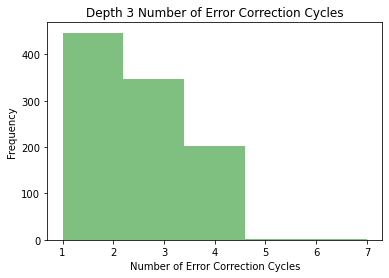

Mean: 2.534
Standard Deviation: 1.069038820623461


In [8]:
#look at the distributions for all 
import matplotlib.pyplot as plt
import statistics
#do this for depth 3:
num_bins_3 = 5
plt.hist(d3_dist, num_bins_3, color='g', alpha=.5)
plt.gca().set(title='Depth 3 Number of Error Correction Cycles', xlabel = "Number of Error Correction Cycles", ylabel='Frequency')
plt.show()
mean_d3 = sum(d3_dist) / len(d3_dist)
sd_d3 = statistics.pstdev(d3_dist) 
print('Mean: ' + str(mean_d3))
print('Standard Deviation: ' + str(sd_d3))

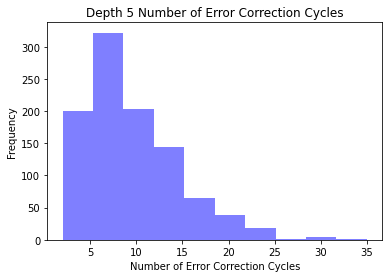

Mean: 9.518
Standard Deviation: 4.962829434909082


In [9]:
num_bins_5 = 10
plt.hist(d5_dist, num_bins_5, facecolor='blue', alpha=.5)
plt.gca().set(title='Depth 5 Number of Error Correction Cycles', xlabel = "Number of Error Correction Cycles", ylabel='Frequency')
plt.show()
mean_d5 = sum(d5_dist) / len(d5_dist)
mean_d5 = sum(d5_dist) / len(d5_dist)
sd_d5 = statistics.pstdev(d5_dist) 
print('Mean: ' + str(mean_d5))
print('Standard Deviation: ' + str(sd_d5))

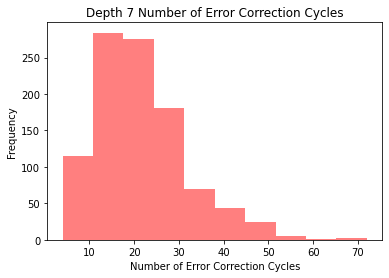

Mean: 21.381
Standard Deviation: 10.082154482053923


In [10]:
num_bins_7 = 10
plt.hist(d7_dist, num_bins_7, facecolor='r', alpha=.5)
plt.gca().set(title='Depth 7 Number of Error Correction Cycles', xlabel = "Number of Error Correction Cycles", ylabel='Frequency')
plt.show()
mean_d7 = sum(d7_dist) / len(d7_dist)
mean_d3 = sum(d3_dist) / len(d3_dist)
sd_d7 = statistics.pstdev(d7_dist) 
print('Mean: ' + str(mean_d7))
print('Standard Deviation: ' + str(sd_d7))